In [16]:
from pathlib import Path
from sklearn.model_selection import KFold
import shutil
from ultralytics import YOLO
import pandas as pd
import os

In [3]:
import torch
torch.backends.cudnn.benchmark = True


En este notebook vamos a realizar el entrenamiento de los modelos. Primero vamos a revisar un approach inicial con los modelos de los filtrados y no filtrados para 80 epocas. En el notebook del procesamiento intentamos hacer lo mismo pero mediante los de preprocesamiento incluido con operaciones morfologicas sobre las imagenes.

In [4]:
from pathlib import Path

# Nombres de las clases (sin incluir background)
class_names = [
    "Vehiculos",
    "Bodegas",
    "Caminos",
    "Rios",
    "Zonas de mineria ilegal"
]

for dataset_name in ["modelo_yolov11_dataset_filtrado", "modelo_yolov11_dataset_completo"]:
    DATA_ROOT = Path(dataset_name)

    yaml_content = f"""\
        path: {DATA_ROOT.resolve()}
        train: train
        val: val
        test: test
        nc: {len(class_names)}
        names: {class_names}
        """


    yaml_path = DATA_ROOT / "dataset.yaml"
    with open(yaml_path, "w", encoding="utf-8") as f:
        f.write(yaml_content)

    print(f"✅ YAML generado en: {yaml_path}")


✅ YAML generado en: modelo_yolov11_dataset_filtrado\dataset.yaml
✅ YAML generado en: modelo_yolov11_dataset_completo\dataset.yaml


Realizamos la creacion de las funciones para hacer kfold y el entrenamiento inicial

In [5]:
from pathlib import Path
from sklearn.model_selection import KFold
import shutil
from ultralytics import YOLO
import pandas as pd

def ejecutar_kfold_yolov8(
    dataset_name: str,
    class_names: list,
    model_weights: str = "yolov8s.pt",
    num_folds: int = 5,
    epochs: int = 40,
    batch_size: int = 16,
    img_size: int = 640,
    patience: int = 5
):
    DATA_ROOT = Path(dataset_name)
    IMAGES_DIR = DATA_ROOT / "train" / "images"
    LABELS_DIR = DATA_ROOT / "train" / "labels"
    CV_ROOT = Path(f"kfold_results_{dataset_name}")
    CV_ROOT.mkdir(parents=True, exist_ok=True)

    all_images = sorted(IMAGES_DIR.glob("*.jpg"))
    all_labels = [LABELS_DIR / (img.stem + ".txt") for img in all_images]
    assert all([lbl.exists() for lbl in all_labels]), "❌ Faltan archivos .txt para algunas imágenes."

    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    results_summary = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(all_images)):
        print(f"\n🔁 Entrenando fold {fold_idx + 1}/{num_folds}...")

        fold_dir = CV_ROOT / f"fold_{fold_idx}"
        train_img_dir = fold_dir / "images" / "train"
        val_img_dir = fold_dir / "images" / "val"
        train_lbl_dir = fold_dir / "labels" / "train"
        val_lbl_dir = fold_dir / "labels" / "val"
        for d in [train_img_dir, val_img_dir, train_lbl_dir, val_lbl_dir]:
            d.mkdir(parents=True, exist_ok=True)

        for idx in train_idx:
            shutil.copy(all_images[idx], train_img_dir)
            shutil.copy(all_labels[idx], train_lbl_dir)
        for idx in val_idx:
            shutil.copy(all_images[idx], val_img_dir)
            shutil.copy(all_labels[idx], val_lbl_dir)

        yaml_content = f"""\
            path: {fold_dir.resolve()}
            train: images/train
            val: images/val
            nc: {len(class_names)}
            names: {class_names}
            """


        yaml_path = fold_dir / "dataset.yaml"
        with open(yaml_path, "w", encoding="utf-8") as f:
            f.write(yaml_content)

        run_name = f"{dataset_name}_cv_fold_{fold_idx}"
        project_dir = Path("runs/detect")
        last_ckpt = project_dir / run_name / "weights" / "last.pt"

        if last_ckpt.exists():
            # Verificamos si ya se entrenaron todos los epochs
            completed_flag = (project_dir / run_name / "results.csv").exists()

            if completed_flag:
                print(f"✅ Fold {fold_idx} ya completado previamente. Saltando...")
                continue  # Saltamos al siguiente fold
            else:
                print(f"🔄 Reanudando fold {fold_idx} desde checkpoint: {last_ckpt}")
                model = YOLO(str(last_ckpt))
                results = model.train(
                    resume=True,
                    epochs=epochs,
                    name=run_name
                )

        else:
            print(f"🚀 Entrenando fold {fold_idx} desde cero...")
            model = YOLO(model_weights)
            results = model.train(
                data=str(yaml_path),
                epochs=epochs,
                imgsz=img_size,
                batch=batch_size,
                name=run_name,
                patience=patience
            )

        metrics = model.val(data=str(yaml_path)).results_dict
        metrics["fold"] = fold_idx
        results_summary.append(metrics)

    df_results = pd.DataFrame(results_summary)
    csv_output = CV_ROOT / "cv_results_summary.csv"
    df_results.to_csv(csv_output, index=False)
    print(f"\n✅ Cross-validation completa. Resultados guardados en: {csv_output}")

def entrenar_modelo_final(
    dataset_name: str,
    class_names: list,
    model_weights: str = "yolov8s.pt",
    epochs: int = 80,
    batch_size: int = 16,
    img_size: int = 640,
    patience: int = 10
):
    DATA_ROOT = Path(dataset_name)
    FINAL_OUTPUT_DIR = Path(f"final_model_{dataset_name}")
    FINAL_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

    yaml_path = DATA_ROOT / "dataset.yaml"
    run_name = f"{dataset_name}_final"
    project_dir = Path("runs/detect")
    last_ckpt = project_dir / run_name / "weights" / "last.pt"

    if last_ckpt.exists():
        print(f"🔄 Reanudando modelo final desde checkpoint: {last_ckpt}")
        model = YOLO(str(last_ckpt))
        results = model.train(
            resume=True,
            epochs=epochs,
            name=run_name
        )
    else:
        print(f"🚀 Entrenando modelo final sobre todo el dataset: {dataset_name}...")
        model = YOLO(model_weights)
        results = model.train(
            data=str(yaml_path),
            epochs=epochs,
            imgsz=img_size,
            batch=batch_size,
            name=run_name,
            patience=patience
        )

    final_model_path = FINAL_OUTPUT_DIR / f"{dataset_name}_final_model.pt"
    model.save(str(final_model_path))
    print(f"\n✅ Modelo final guardado en: {final_model_path}")

# Entrenamiento del multiclass para dataset filtrado

Vamos a centrarnos primero en el entrenamiento kfold para filtrado y revisar sus resultados

## K-fold Filtrado

In [6]:
ejecutar_kfold_yolov8(
    dataset_name="modelo_yolov11_dataset_filtrado",
    class_names=["Vehiculos", "Bodegas", "Caminos", "Rios", "Zonas de mineria ilegal"]
)


🔁 Entrenando fold 1/5...
🚀 Entrenando fold 0 desde cero...
New https://pypi.org/project/ultralytics/8.3.134 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=kfold_results_modelo_yolov11_dataset_filtrado\fold_0\dataset.yaml, epochs=40, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=modelo_yolov11_dataset_filtrado_cv_fold_05, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_filtrado\fold_0\labels\train.cache... 6606 images, 1638 backgrounds, 0 corrupt: 100%|██████████| 6606/6606 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 29.816.0 MB/s, size: 323.1 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_filtrado\fold_0\labels\val.cache... 1652 images, 424 backgrounds, 0 corrupt: 100%|██████████| 1652/1652 [00:00<?, ?it/s]


Plotting labels to runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_05\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/14 16:00:34 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/14 16:00:38 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(2fe0be57745948dfb228f7f3aa44cf7f) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_05
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40     0.748G       2.21      3.096      2.075         46        640: 100%|██████████| 413/413 [01:44<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.17it/s]

                   all       1652       1936      0.426      0.335      0.289      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40       3.8G      2.101      2.377      2.023         27        640: 100%|██████████| 413/413 [01:35<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.50it/s]


                   all       1652       1936      0.317      0.361      0.258     0.0851

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      3.98G      2.047      2.259      1.985         45        640: 100%|██████████| 413/413 [01:32<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.80it/s]


                   all       1652       1936      0.396      0.359      0.302      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40         4G      1.995      2.153      1.974         24        640: 100%|██████████| 413/413 [01:32<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.18it/s]

                   all       1652       1936      0.412      0.465      0.382      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40         4G      1.892      1.987      1.885         51        640: 100%|██████████| 413/413 [01:34<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.36it/s]


                   all       1652       1936      0.504      0.529      0.463      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40         4G      1.807      1.859      1.802         47        640: 100%|██████████| 413/413 [01:35<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.29it/s]


                   all       1652       1936      0.547      0.533      0.527      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40         4G      1.764      1.755      1.769         31        640: 100%|██████████| 413/413 [01:35<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.54it/s]


                   all       1652       1936      0.542      0.577      0.557      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40         4G      1.685      1.635      1.687         33        640: 100%|██████████| 413/413 [01:40<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.42it/s]

                   all       1652       1936      0.596      0.615       0.62      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40         4G      1.614      1.559      1.643         23        640: 100%|██████████| 413/413 [01:43<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.64it/s]

                   all       1652       1936       0.65      0.618      0.643      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40         4G      1.571      1.485      1.597         31        640: 100%|██████████| 413/413 [01:37<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.32it/s]


                   all       1652       1936      0.637      0.659      0.662      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40         4G      1.525      1.427      1.569         37        640: 100%|██████████| 413/413 [01:38<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.53it/s]


                   all       1652       1936      0.618      0.661      0.664      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40         4G      1.487      1.374      1.531         28        640: 100%|██████████| 413/413 [01:34<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.56it/s]


                   all       1652       1936      0.672      0.695      0.708      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40         4G      1.455      1.313      1.509         27        640: 100%|██████████| 413/413 [01:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.66it/s]


                   all       1652       1936      0.648       0.71      0.713      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40         4G      1.419       1.27      1.475         50        640: 100%|██████████| 413/413 [01:34<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.67it/s]

                   all       1652       1936      0.703      0.683      0.716      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40         4G      1.368      1.226      1.438         24        640: 100%|██████████| 413/413 [01:35<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.64it/s]


                   all       1652       1936      0.709      0.708      0.747      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40         4G       1.35      1.183      1.425         24        640: 100%|██████████| 413/413 [01:38<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.66it/s]


                   all       1652       1936      0.678      0.715      0.728      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40         4G      1.329       1.16      1.408         28        640: 100%|██████████| 413/413 [01:36<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.35it/s]

                   all       1652       1936      0.704      0.735      0.748      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40         4G      1.277      1.114      1.379         40        640: 100%|██████████| 413/413 [01:38<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.69it/s]

                   all       1652       1936      0.709      0.769      0.769      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40         4G      1.261      1.086      1.362         31        640: 100%|██████████| 413/413 [01:35<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.35it/s]

                   all       1652       1936      0.723       0.73       0.76      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40         4G      1.244      1.061      1.348         44        640: 100%|██████████| 413/413 [01:34<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.79it/s]


                   all       1652       1936      0.714      0.772      0.779      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40         4G      1.222       1.04      1.335         40        640: 100%|██████████| 413/413 [01:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.75it/s]


                   all       1652       1936      0.722      0.775      0.784      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40         4G      1.194      1.005      1.314         49        640: 100%|██████████| 413/413 [01:35<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.73it/s]


                   all       1652       1936      0.733      0.762      0.778      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40         4G      1.187     0.9957      1.309         34        640: 100%|██████████| 413/413 [01:36<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.70it/s]


                   all       1652       1936      0.727      0.783      0.784      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40         4G      1.147     0.9485      1.285         18        640: 100%|██████████| 413/413 [01:33<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.45it/s]

                   all       1652       1936      0.749      0.767      0.799       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40         4G      1.125     0.9374      1.275         40        640: 100%|██████████| 413/413 [01:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.79it/s]

                   all       1652       1936      0.747      0.781      0.799      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40         4G      1.119     0.9237      1.265         22        640: 100%|██████████| 413/413 [01:34<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.36it/s]

                   all       1652       1936      0.752      0.782      0.808      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40         4G      1.084     0.8924       1.24         34        640: 100%|██████████| 413/413 [01:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.82it/s]

                   all       1652       1936      0.768      0.785      0.817      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40         4G      1.074     0.8791      1.234         66        640: 100%|██████████| 413/413 [01:34<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.39it/s]

                   all       1652       1936       0.77      0.792      0.819      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40         4G      1.047     0.8558      1.219         36        640: 100%|██████████| 413/413 [01:35<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.49it/s]

                   all       1652       1936      0.771      0.797       0.82      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40         4G      1.033     0.8348      1.201         51        640: 100%|██████████| 413/413 [01:38<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.36it/s]

                   all       1652       1936      0.756      0.803      0.818      0.591


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40         4G     0.9455     0.7352      1.167          8        640: 100%|██████████| 413/413 [01:38<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.65it/s]

                   all       1652       1936      0.795      0.793      0.833      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40         4G     0.9241     0.7048      1.151         13        640: 100%|██████████| 413/413 [01:34<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.72it/s]

                   all       1652       1936      0.766      0.804      0.831        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40         4G     0.8921     0.6844      1.131          9        640: 100%|██████████| 413/413 [01:36<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.41it/s]

                   all       1652       1936      0.793      0.795      0.832      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40         4G     0.8686     0.6724      1.125         24        640: 100%|██████████| 413/413 [01:41<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.01it/s]

                   all       1652       1936      0.799      0.793      0.841      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40         4G     0.8437     0.6449      1.108         23        640: 100%|██████████| 413/413 [01:39<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.44it/s]

                   all       1652       1936      0.773       0.83      0.845      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40         4G     0.8178     0.6309      1.088         17        640: 100%|██████████| 413/413 [01:40<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.37it/s]


                   all       1652       1936      0.794      0.809      0.844      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40         4G     0.7988     0.6112      1.079         24        640: 100%|██████████| 413/413 [01:35<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.20it/s]

                   all       1652       1936      0.799      0.821       0.85      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40         4G     0.7704     0.5935      1.062         20        640: 100%|██████████| 413/413 [01:35<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.70it/s]


                   all       1652       1936      0.792      0.831      0.854       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40         4G     0.7486     0.5837      1.054         20        640: 100%|██████████| 413/413 [01:35<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:14<00:00,  3.67it/s]

                   all       1652       1936      0.803      0.831      0.855      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40         4G     0.7387     0.5731      1.046         13        640: 100%|██████████| 413/413 [01:32<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.96it/s]

                   all       1652       1936      0.808       0.82      0.858      0.648



40 epochs completed in 1.218 hours.
Optimizer stripped from runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_05\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_05\weights\best.pt, 22.5MB

Validating runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_05\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.51it/s]


                   all       1652       1936      0.808       0.82      0.858      0.647
             Vehiculos        311        318      0.838      0.997      0.944      0.901
               Bodegas        134        425      0.653      0.632      0.701      0.352
               Caminos        262        429      0.771      0.758      0.795      0.455
                  Rios        249        422      0.833      0.852       0.89      0.612
Zonas de mineria ilegal        325        342      0.943      0.863      0.958      0.917
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_05
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, rea

val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_filtrado\fold_0\labels\val.cache... 1652 images, 424 backgrounds, 0 corrupt: 100%|██████████| 1652/1652 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:14<00:00,  7.41it/s]


                   all       1652       1936      0.808       0.82      0.857      0.648
             Vehiculos        311        318      0.838      0.997      0.944      0.901
               Bodegas        134        425      0.652      0.631      0.701      0.352
               Caminos        262        429      0.773      0.758      0.795      0.456
                  Rios        249        422      0.833      0.851       0.89      0.612
Zonas de mineria ilegal        325        342      0.945      0.863      0.958      0.919
Speed: 0.1ms preprocess, 4.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_052

🔁 Entrenando fold 2/5...
✅ Fold 1 ya completado previamente. Saltando...

🔁 Entrenando fold 3/5...
✅ Fold 2 ya completado previamente. Saltando...

🔁 Entrenando fold 4/5...
✅ Fold 3 ya completado previamente. Saltando...

🔁 Entrenando fold 5/5...
🚀 Entrenando fold 4 desde cero...
New https://pypi.org/project

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_filtrado\fold_4\labels\train... 6607 images, 1680 backgrounds, 0 corrupt: 100%|██████████| 6607/6607 [00:14<00:00, 453.32it/s]


train: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_filtrado\fold_4\labels\train.cache
val: Fast image access  (ping: 0.20.1 ms, read: 17.16.1 MB/s, size: 320.4 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_filtrado\fold_4\labels\val... 1651 images, 382 backgrounds, 0 corrupt: 100%|██████████| 1651/1651 [00:04<00:00, 381.51it/s]


val: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_filtrado\fold_4\labels\val.cache
Plotting labels to runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/14 17:18:06 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/14 17:18:06 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(ac07c0a620e0441e8addac9d1fceb6bd) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_4
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40       1.2G      2.199      3.097      2.061         32        640: 100%|██████████| 413/413 [01:43<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.28it/s]


                   all       1651       1888      0.318      0.304      0.233     0.0878

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      3.81G      2.097      2.367      2.015         31        640: 100%|██████████| 413/413 [01:35<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.54it/s]


                   all       1651       1888      0.263      0.362      0.236     0.0821

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      3.99G      2.061      2.266      1.993         34        640: 100%|██████████| 413/413 [01:33<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.55it/s]


                   all       1651       1888      0.399      0.418      0.318      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40         4G      1.988      2.141      1.927         33        640: 100%|██████████| 413/413 [01:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.70it/s]


                   all       1651       1888      0.488      0.466      0.434      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40         4G      1.902      1.981      1.856         28        640: 100%|██████████| 413/413 [01:31<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.75it/s]


                   all       1651       1888      0.562       0.47      0.495      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40         4G       1.82      1.849      1.774         34        640: 100%|██████████| 413/413 [01:31<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.45it/s]


                   all       1651       1888      0.521      0.552      0.544      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40         4G      1.737      1.739      1.719         55        640: 100%|██████████| 413/413 [01:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.73it/s]


                   all       1651       1888       0.56      0.601      0.595      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40         4G      1.686      1.641      1.677         21        640: 100%|██████████| 413/413 [01:33<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.36it/s]

                   all       1651       1888      0.633      0.585      0.627      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40         4G      1.645       1.56      1.645         43        640: 100%|██████████| 413/413 [01:35<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.66it/s]


                   all       1651       1888      0.634      0.631      0.651       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40         4G      1.594        1.5      1.595         40        640: 100%|██████████| 413/413 [01:34<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.70it/s]


                   all       1651       1888       0.65      0.656      0.663      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40         4G      1.544      1.443      1.564         31        640: 100%|██████████| 413/413 [01:34<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:13<00:00,  3.85it/s]

                   all       1651       1888       0.67      0.681      0.701      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40         4G      1.501      1.382       1.53         27        640: 100%|██████████| 413/413 [01:36<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.16it/s]

                   all       1651       1888      0.707      0.657      0.721      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40         4G      1.474       1.32        1.5         55        640: 100%|██████████| 413/413 [01:37<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.16it/s]

                   all       1651       1888      0.717      0.683      0.727      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40         4G      1.409      1.261      1.464         32        640: 100%|██████████| 413/413 [01:38<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.41it/s]


                   all       1651       1888      0.684      0.705       0.72      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40         4G       1.38      1.214      1.441         27        640: 100%|██████████| 413/413 [01:35<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.04it/s]


                   all       1651       1888      0.704       0.69      0.733      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40         4G      1.361      1.182       1.42         40        640: 100%|██████████| 413/413 [01:33<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.72it/s]

                   all       1651       1888       0.67      0.734       0.73      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40         4G      1.331      1.145      1.395         30        640: 100%|██████████| 413/413 [01:32<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.44it/s]

                   all       1651       1888      0.708      0.722      0.748      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40         4G       1.31      1.129      1.393         44        640: 100%|██████████| 413/413 [01:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.59it/s]

                   all       1651       1888      0.719      0.743      0.762      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40         4G      1.285      1.095      1.371         35        640: 100%|██████████| 413/413 [01:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.61it/s]


                   all       1651       1888      0.727      0.764      0.784      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40         4G       1.26      1.077      1.353         45        640: 100%|██████████| 413/413 [01:33<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.68it/s]


                   all       1651       1888      0.732      0.759      0.784       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40         4G      1.235      1.038      1.331         30        640: 100%|██████████| 413/413 [01:36<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:14<00:00,  3.64it/s]

                   all       1651       1888      0.749      0.755       0.79      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40         4G       1.21      1.012      1.321         25        640: 100%|██████████| 413/413 [01:35<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.55it/s]

                   all       1651       1888      0.743      0.771      0.797      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40         4G      1.188     0.9863      1.299         35        640: 100%|██████████| 413/413 [01:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.59it/s]

                   all       1651       1888      0.734      0.793        0.8      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40         4G      1.163     0.9583      1.283         27        640: 100%|██████████| 413/413 [01:33<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.45it/s]


                   all       1651       1888      0.759       0.77      0.794      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40         4G      1.137     0.9461      1.266         31        640: 100%|██████████| 413/413 [01:36<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.51it/s]

                   all       1651       1888      0.766      0.765      0.801      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40         4G      1.113     0.9196      1.255         32        640: 100%|██████████| 413/413 [01:35<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.52it/s]

                   all       1651       1888      0.735      0.806      0.807      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40         4G      1.099     0.8945      1.236         33        640: 100%|██████████| 413/413 [01:34<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.54it/s]

                   all       1651       1888      0.766      0.795      0.818      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40         4G      1.078     0.8812      1.227         78        640: 100%|██████████| 413/413 [01:34<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.53it/s]


                   all       1651       1888      0.762      0.803       0.82      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40         4G      1.059     0.8681      1.211         50        640: 100%|██████████| 413/413 [01:36<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.51it/s]


                   all       1651       1888      0.775        0.8      0.829      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40         4G      1.035     0.8352      1.197         26        640: 100%|██████████| 413/413 [01:34<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.60it/s]

                   all       1651       1888      0.774      0.806      0.826      0.596


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40         4G     0.9769     0.7491      1.175         27        640: 100%|██████████| 413/413 [01:32<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.66it/s]

                   all       1651       1888      0.788      0.793      0.826      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40         4G     0.9418     0.7108      1.153         13        640: 100%|██████████| 413/413 [01:32<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.65it/s]

                   all       1651       1888       0.77      0.814      0.838      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40         4G      0.911      0.694      1.144         18        640: 100%|██████████| 413/413 [01:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.50it/s]

                   all       1651       1888      0.798      0.794       0.84      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40         4G     0.8891     0.6728      1.122         17        640: 100%|██████████| 413/413 [01:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.49it/s]


                   all       1651       1888      0.797      0.796      0.836      0.614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40         4G     0.8539     0.6498      1.102         12        640: 100%|██████████| 413/413 [01:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.39it/s]


                   all       1651       1888      0.782      0.816      0.842      0.626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40         4G     0.8304     0.6323      1.092         15        640: 100%|██████████| 413/413 [01:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.38it/s]

                   all       1651       1888      0.792      0.818       0.85      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40         4G     0.8096     0.6093      1.074         16        640: 100%|██████████| 413/413 [01:38<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.46it/s]

                   all       1651       1888      0.804       0.81      0.842      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40         4G     0.7909     0.6002      1.064         16        640: 100%|██████████| 413/413 [01:33<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.69it/s]

                   all       1651       1888      0.806      0.811      0.848      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40         4G     0.7707     0.5873      1.054         18        640: 100%|██████████| 413/413 [01:32<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.67it/s]

                   all       1651       1888      0.798      0.814      0.846       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40         4G     0.7518     0.5741      1.045         14        640: 100%|██████████| 413/413 [01:31<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.62it/s]

                   all       1651       1888      0.806      0.813      0.848      0.645



40 epochs completed in 1.201 hours.
Optimizer stripped from runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_4\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_4\weights\best.pt, 22.5MB

Validating runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_4\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.32it/s]


                   all       1651       1888      0.807      0.812      0.848      0.645
             Vehiculos        380        392      0.886          1      0.952      0.913
               Bodegas        111        375      0.638      0.549      0.638      0.327
               Caminos        231        354       0.75      0.749      0.805      0.478
                  Rios        247        401      0.845      0.863      0.894      0.599
Zonas de mineria ilegal        341        366      0.916      0.899      0.952      0.908
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_4
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read

val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_filtrado\fold_4\labels\val.cache... 1651 images, 382 backgrounds, 0 corrupt: 100%|██████████| 1651/1651 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:14<00:00,  7.18it/s]


                   all       1651       1888      0.809      0.811      0.848      0.645
             Vehiculos        380        392      0.888          1      0.952      0.915
               Bodegas        111        375      0.641      0.547      0.636      0.327
               Caminos        231        354       0.75      0.749      0.804      0.478
                  Rios        247        401      0.846      0.863      0.894      0.598
Zonas de mineria ilegal        341        366      0.919      0.899      0.953      0.907
Speed: 0.1ms preprocess, 3.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_42

✅ Cross-validation completa. Resultados guardados en: kfold_results_modelo_yolov11_dataset_filtrado\cv_results_summary.csv


Los resultados en general observamos que se comportan bien para todos los folds

In [3]:
import pandas as pd

In [6]:
df = pd.read_csv('models/kfold_results_modelo_yolov11_dataset_filtrado/cv_results_summary.csv')
df

metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0              0.808178           0.819752          0.857483   
1              0.808821           0.811384          0.847934   

   metrics/mAP50-95(B)   fitness  fold  
0             0.647960  0.668912     0  
1             0.644956  0.665253     4

Las metricas se comportan muy parecido

## Modelo Final - Filtrado

Ahora realizamos el modelo para el filtrado

In [7]:
entrenar_modelo_final(
    dataset_name="modelo_yolov11_dataset_filtrado",
    class_names=["Vehiculos", "Bodegas", "Caminos", "Rios", "Zonas de mineria ilegal"]
)


🚀 Entrenando modelo final sobre todo el dataset: modelo_yolov11_dataset_filtrado...
New https://pypi.org/project/ultralytics/8.3.134 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=modelo_yolov11_dataset_filtrado\dataset.yaml, epochs=80, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=modelo_yolov11_dataset_filtrado_final3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_filtrado\train\labels.cache... 8258 images, 2062 backgrounds, 0 corrupt: 100%|██████████| 8258/8258 [00:00<?, ?it/s]


val: Fast image access  (ping: 1.01.1 ms, read: 13.15.1 MB/s, size: 271.5 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_filtrado\val\labels.cache... 984 images, 237 backgrounds, 0 corrupt: 100%|██████████| 984/984 [00:00<?, ?it/s]


Plotting labels to runs\detect\modelo_yolov11_dataset_filtrado_final3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/14 18:37:21 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/14 18:37:21 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(8577d3595ccc4677bf556e6f4d60ab2f) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\modelo_yolov11_dataset_filtrado_final3
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80     0.514G      2.301      3.328      2.122          2        640: 100%|██████████| 517/517 [02:03<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.13it/s]

                   all        984       1103      0.354      0.398      0.342      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80      3.47G      1.965      2.088      1.791          6        640: 100%|██████████| 517/517 [01:58<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.15it/s]

                   all        984       1103      0.485      0.491      0.466      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80      3.67G      1.973      2.059      1.803          2        640: 100%|██████████| 517/517 [01:56<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.42it/s]

                   all        984       1103      0.412      0.413      0.369      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      3.67G      1.999       2.08      1.824          3        640: 100%|██████████| 517/517 [01:57<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.42it/s]

                   all        984       1103      0.434      0.454      0.415      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      3.67G      1.926      1.962       1.77          7        640: 100%|██████████| 517/517 [02:01<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.30it/s]

                   all        984       1103      0.456      0.502      0.466      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      3.67G       1.84      1.828      1.719          4        640: 100%|██████████| 517/517 [02:02<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.15it/s]

                   all        984       1103      0.588       0.57      0.581      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      3.67G      1.759      1.718      1.648          6        640: 100%|██████████| 517/517 [01:58<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.48it/s]

                   all        984       1103      0.554      0.604      0.603      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80      3.67G      1.717      1.631      1.616          1        640: 100%|██████████| 517/517 [02:01<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.19it/s]

                   all        984       1103      0.583      0.587      0.592      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      3.67G      1.658       1.56      1.577          7        640: 100%|██████████| 517/517 [02:02<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.44it/s]

                   all        984       1103      0.641      0.622      0.648       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      3.67G      1.599      1.498      1.534          7        640: 100%|██████████| 517/517 [02:00<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.52it/s]

                   all        984       1103      0.628      0.663      0.687      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      3.67G      1.571      1.417      1.503          3        640: 100%|██████████| 517/517 [02:01<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.21it/s]

                   all        984       1103      0.677       0.68      0.738      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80      3.67G       1.51      1.371      1.466          3        640: 100%|██████████| 517/517 [02:00<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.48it/s]

                   all        984       1103      0.651      0.698      0.714       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      3.67G      1.498      1.329      1.454          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.62it/s]

                   all        984       1103      0.676      0.706      0.747      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80      3.67G      1.466      1.285       1.43          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.61it/s]

                   all        984       1103       0.74      0.724      0.776      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      3.67G      1.442      1.277       1.41          1        640: 100%|██████████| 517/517 [01:58<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.32it/s]

                   all        984       1103      0.736      0.723      0.782      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80      3.67G      1.401      1.227      1.391          2        640: 100%|██████████| 517/517 [02:00<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.25it/s]

                   all        984       1103      0.758      0.736      0.783      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80      3.67G      1.381      1.188      1.376          1        640: 100%|██████████| 517/517 [02:02<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.13it/s]

                   all        984       1103      0.752      0.733      0.789      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80      3.67G      1.342      1.143      1.352          1        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.59it/s]

                   all        984       1103       0.72      0.764      0.792      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80      3.67G      1.328      1.126      1.338          4        640: 100%|██████████| 517/517 [01:55<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.56it/s]

                   all        984       1103      0.714      0.757      0.797      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80      3.67G      1.311      1.103      1.326          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.63it/s]

                   all        984       1103      0.732      0.765      0.807      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80      3.67G      1.281      1.094      1.312          1        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.58it/s]


                   all        984       1103      0.762      0.796      0.816      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80      3.67G      1.276      1.072      1.302          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.66it/s]


                   all        984       1103      0.778      0.785      0.814      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80      3.67G      1.251      1.032      1.285          2        640: 100%|██████████| 517/517 [01:56<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.66it/s]

                   all        984       1103      0.749      0.795      0.815      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80      3.67G      1.216      1.009      1.263          4        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.12it/s]

                   all        984       1103      0.767      0.793      0.824      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      3.67G      1.209     0.9954      1.261          3        640: 100%|██████████| 517/517 [02:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.13it/s]

                   all        984       1103      0.786      0.803      0.839      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80      3.67G      1.195      0.984      1.251          6        640: 100%|██████████| 517/517 [02:07<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.33it/s]

                   all        984       1103       0.77      0.812      0.846      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80      3.67G      1.168     0.9579      1.235          4        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.58it/s]


                   all        984       1103      0.778       0.81      0.834      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80      3.67G      1.166     0.9546      1.234          8        640: 100%|██████████| 517/517 [01:59<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.52it/s]

                   all        984       1103      0.776      0.807      0.831      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80      3.67G      1.146     0.9275      1.218         12        640: 100%|██████████| 517/517 [01:59<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.58it/s]

                   all        984       1103      0.775      0.809      0.841      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80      3.67G      1.132     0.9066      1.206          6        640: 100%|██████████| 517/517 [01:56<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.52it/s]

                   all        984       1103      0.784      0.824      0.844      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80      3.67G      1.117     0.8971      1.202          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.70it/s]

                   all        984       1103      0.786      0.823      0.853      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80      3.67G      1.099     0.8862      1.196          5        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.72it/s]

                   all        984       1103        0.8      0.831      0.865      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80      3.67G      1.091     0.8805      1.187          1        640: 100%|██████████| 517/517 [01:56<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.48it/s]

                   all        984       1103      0.781       0.83      0.857      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80      3.67G      1.089     0.8637      1.179          1        640: 100%|██████████| 517/517 [01:57<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.85it/s]


                   all        984       1103      0.773      0.841      0.852      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80      3.67G      1.069     0.8555      1.172          9        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.75it/s]

                   all        984       1103       0.78      0.836      0.856       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80      3.67G      1.053     0.8387      1.168          3        640: 100%|██████████| 517/517 [01:57<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.83it/s]

                   all        984       1103        0.8      0.834      0.852       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80      3.67G      1.045     0.8314      1.155          5        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.78it/s]

                   all        984       1103       0.81      0.843      0.871      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80      3.67G       1.04     0.8293       1.16          7        640: 100%|██████████| 517/517 [01:55<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.75it/s]

                   all        984       1103      0.797      0.844      0.867      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80      3.67G      1.028     0.8186       1.15          0        640: 100%|██████████| 517/517 [01:56<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.67it/s]

                   all        984       1103      0.825      0.846       0.87      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80      3.67G      1.011     0.8087      1.145         12        640: 100%|██████████| 517/517 [01:56<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.68it/s]

                   all        984       1103      0.813      0.839      0.869      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80      3.67G      1.009     0.7964      1.139          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.71it/s]

                   all        984       1103      0.814      0.846      0.869      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80      3.67G     0.9842     0.7777       1.12          0        640: 100%|██████████| 517/517 [01:55<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.73it/s]


                   all        984       1103      0.813      0.857      0.871      0.647

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80      3.67G      0.988     0.7732      1.126          9        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.75it/s]

                   all        984       1103      0.817      0.841      0.874      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80      3.67G     0.9656     0.7647      1.115          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.74it/s]

                   all        984       1103      0.813      0.832      0.875      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80      3.67G     0.9564     0.7493      1.108          6        640: 100%|██████████| 517/517 [01:56<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.58it/s]

                   all        984       1103      0.846      0.844      0.883      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80      3.67G     0.9576     0.7544      1.109          9        640: 100%|██████████| 517/517 [01:57<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.64it/s]

                   all        984       1103      0.835      0.851      0.887      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80      3.67G     0.9324     0.7328      1.096          5        640: 100%|██████████| 517/517 [01:58<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.47it/s]

                   all        984       1103      0.817      0.852      0.878      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80      3.67G     0.9222     0.7293      1.088          8        640: 100%|██████████| 517/517 [01:57<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.64it/s]

                   all        984       1103      0.833      0.859      0.883      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80      3.67G     0.9209     0.7243      1.089          5        640: 100%|██████████| 517/517 [01:57<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.76it/s]

                   all        984       1103       0.83      0.849      0.881      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80      3.67G     0.9143      0.714      1.085          5        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.74it/s]

                   all        984       1103      0.842      0.857      0.881      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80      3.67G     0.9026     0.7058       1.08          4        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.71it/s]

                   all        984       1103      0.825      0.852      0.882      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80      3.67G     0.8851     0.6913       1.07          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.70it/s]

                   all        984       1103      0.828       0.85      0.878      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80      3.67G     0.8843     0.6975      1.072          9        640: 100%|██████████| 517/517 [01:57<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.55it/s]

                   all        984       1103      0.833      0.843      0.883      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      3.67G      0.876      0.678      1.064          1        640: 100%|██████████| 517/517 [01:58<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.47it/s]

                   all        984       1103       0.84      0.861      0.888      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80      3.67G      0.867     0.6801       1.06          2        640: 100%|██████████| 517/517 [01:57<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.61it/s]

                   all        984       1103      0.825      0.865      0.889      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80      3.67G      0.863     0.6743      1.058          2        640: 100%|██████████| 517/517 [01:57<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.59it/s]

                   all        984       1103      0.837      0.865      0.891      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80      3.67G     0.8532     0.6625      1.052          6        640: 100%|██████████| 517/517 [01:56<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.67it/s]


                   all        984       1103      0.844      0.859      0.893      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80      3.67G     0.8308     0.6458      1.041          0        640: 100%|██████████| 517/517 [01:56<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.76it/s]

                   all        984       1103      0.841      0.857      0.889      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80      3.67G     0.8256     0.6494      1.042          7        640: 100%|██████████| 517/517 [01:55<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.78it/s]

                   all        984       1103       0.84      0.861      0.894      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80      3.67G     0.8173     0.6458      1.043          4        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.70it/s]


                   all        984       1103      0.835       0.87      0.893        0.7

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80      3.67G     0.8058     0.6324      1.036          2        640: 100%|██████████| 517/517 [01:55<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.64it/s]


                   all        984       1103      0.849      0.854      0.894      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80      3.67G     0.8101     0.6337      1.034          6        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.80it/s]

                   all        984       1103      0.841      0.868      0.894      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80      3.67G     0.7941     0.6183      1.025          4        640: 100%|██████████| 517/517 [01:55<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.73it/s]

                   all        984       1103      0.839      0.875      0.896       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80      3.67G     0.7987      0.627      1.027          3        640: 100%|██████████| 517/517 [01:52<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.08it/s]


                   all        984       1103      0.851      0.854      0.894      0.709

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80      3.67G     0.7718     0.6142      1.021          3        640: 100%|██████████| 517/517 [01:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.03it/s]

                   all        984       1103      0.851      0.854      0.896      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/80      3.67G     0.7707     0.6093      1.017          3        640: 100%|██████████| 517/517 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.07it/s]

                   all        984       1103      0.844      0.869      0.892       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/80      3.67G      0.754     0.5985      1.011          3        640: 100%|██████████| 517/517 [01:51<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.06it/s]

                   all        984       1103       0.84      0.871      0.895      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/80      3.67G     0.7565     0.6032      1.012          4        640: 100%|██████████| 517/517 [01:51<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.94it/s]

                   all        984       1103      0.849      0.866      0.896      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/80      3.67G     0.7415     0.5835      1.005          4        640: 100%|██████████| 517/517 [01:55<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.62it/s]

                   all        984       1103      0.849      0.859      0.894      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/80      3.67G     0.7324     0.5818     0.9991          8        640: 100%|██████████| 517/517 [01:58<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.17it/s]

                   all        984       1103      0.844      0.863      0.898      0.718


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80      3.67G     0.6541     0.4974      0.958          2        640: 100%|██████████| 517/517 [02:03<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.34it/s]

                   all        984       1103      0.851      0.854      0.897      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/80      3.67G     0.6221     0.4833     0.9425          7        640: 100%|██████████| 517/517 [02:03<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.07it/s]

                   all        984       1103       0.86      0.855      0.897      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80      3.67G     0.6035     0.4746     0.9418          1        640: 100%|██████████| 517/517 [02:03<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.40it/s]

                   all        984       1103      0.854       0.85      0.896      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/80      3.67G     0.5915     0.4635     0.9362          1        640: 100%|██████████| 517/517 [02:07<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  3.90it/s]

                   all        984       1103      0.851      0.857      0.892      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/80      3.67G     0.5859     0.4587      0.928          0        640: 100%|██████████| 517/517 [02:08<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.86it/s]

                   all        984       1103      0.847      0.859      0.892      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/80      3.67G     0.5745     0.4535     0.9268          1        640: 100%|██████████| 517/517 [02:07<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  3.96it/s]

                   all        984       1103      0.851      0.861      0.897      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/80      3.67G      0.564     0.4428     0.9183          1        640: 100%|██████████| 517/517 [02:06<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.04it/s]

                   all        984       1103      0.843      0.862      0.898      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/80      3.67G     0.5514     0.4329     0.9176          2        640: 100%|██████████| 517/517 [02:02<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.15it/s]

                   all        984       1103      0.845       0.86      0.896      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/80      3.67G     0.5446     0.4358     0.9118          1        640: 100%|██████████| 517/517 [01:59<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  3.97it/s]

                   all        984       1103      0.846      0.862      0.899       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/80      3.67G      0.538     0.4266     0.9085          1        640: 100%|██████████| 517/517 [02:05<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  3.92it/s]

                   all        984       1103      0.838      0.866      0.897      0.729



80 epochs completed in 2.805 hours.
Optimizer stripped from runs\detect\modelo_yolov11_dataset_filtrado_final3\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\modelo_yolov11_dataset_filtrado_final3\weights\best.pt, 22.5MB

Validating runs\detect\modelo_yolov11_dataset_filtrado_final3\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.46it/s]


                   all        984       1103      0.846      0.861      0.897       0.73
             Vehiculos        233        238      0.861          1      0.942       0.93
               Bodegas         65        218      0.686      0.702      0.733      0.372
               Caminos        134        222      0.816      0.806      0.881      0.627
                  Rios        137        205      0.926      0.951      0.977      0.776
Zonas de mineria ilegal        207        220      0.941      0.845      0.955      0.946
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_filtrado_final3
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'

✅ Modelo final guardado en: final_model_modelo_yolov11_dataset_filtrado\modelo_yolov11_dataset_filtrado_final_model.pt


En general las metricas estan bastante bien para no aplicar ningun preprocesamiento a las imagenes

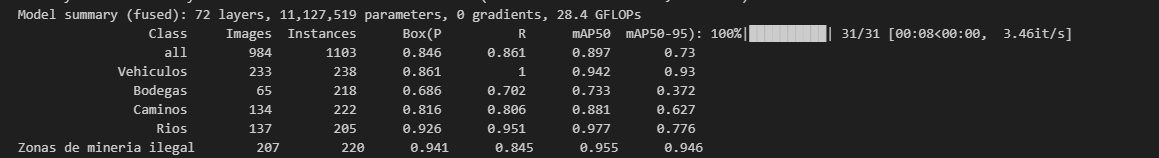

# Entrenamiento del multiclass para dataset completo

## K-fold Completo

Ahora realizamos el k-fold completo para el dataset completo

In [8]:
ejecutar_kfold_yolov8(
    dataset_name="modelo_yolov11_dataset_completo",
    class_names=["Vehiculos", "Bodegas", "Caminos", "Rios", "Zonas de mineria ilegal"]
)


🔁 Entrenando fold 1/5...
🚀 Entrenando fold 0 desde cero...
New https://pypi.org/project/ultralytics/8.3.134 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=kfold_results_modelo_yolov11_dataset_completo\fold_0\dataset.yaml, epochs=40, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=modelo_yolov11_dataset_completo_cv_fold_0, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=F

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_0\labels\train... 6586 images, 1613 backgrounds, 0 corrupt: 100%|██████████| 6586/6586 [00:14<00:00, 453.28it/s]


train: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_0\labels\train.cache
val: Fast image access  (ping: 0.20.0 ms, read: 10.64.3 MB/s, size: 284.4 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_0\labels\val... 1647 images, 421 backgrounds, 0 corrupt: 100%|██████████| 1647/1647 [00:04<00:00, 399.10it/s]


val: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_0\labels\val.cache
Plotting labels to runs\detect\modelo_yolov11_dataset_completo_cv_fold_0\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/14 21:30:01 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/14 21:30:01 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(6dc5d2e47afe40f4ae4748efa0599500) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\modelo_yolov11_dataset_completo_cv_fold_0
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      1.11G      2.202      3.099      2.052         19        640: 100%|██████████| 412/412 [01:47<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:13<00:00,  3.87it/s]

                   all       1647       1987      0.297      0.345      0.245     0.0788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      3.67G      2.115      2.393      2.016         23        640: 100%|██████████| 412/412 [01:42<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.18it/s]


                   all       1647       1987      0.303      0.433      0.295      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      3.87G      2.041      2.255      1.967         45        640: 100%|██████████| 412/412 [01:39<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.05it/s]


                   all       1647       1987      0.388      0.429      0.357      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      3.87G      1.958      2.103      1.897         21        640: 100%|██████████| 412/412 [01:35<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.36it/s]


                   all       1647       1987      0.461      0.504      0.446       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      3.87G      1.876      1.968       1.83         32        640: 100%|██████████| 412/412 [01:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.32it/s]

                   all       1647       1987      0.542      0.529      0.514      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      3.87G      1.817      1.838      1.767         36        640: 100%|██████████| 412/412 [01:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.40it/s]


                   all       1647       1987      0.565      0.527      0.539      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      3.87G      1.739      1.736      1.709         26        640: 100%|██████████| 412/412 [01:35<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.26it/s]


                   all       1647       1987      0.604      0.522      0.549      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      3.87G      1.668      1.628      1.657         11        640: 100%|██████████| 412/412 [01:33<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.38it/s]

                   all       1647       1987       0.61      0.611      0.613      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      3.87G      1.626       1.56       1.62         19        640: 100%|██████████| 412/412 [01:33<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.41it/s]

                   all       1647       1987      0.588      0.597      0.589      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      3.87G      1.575      1.491      1.574         25        640: 100%|██████████| 412/412 [01:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.42it/s]

                   all       1647       1987      0.648       0.63       0.66       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      3.87G      1.518      1.408      1.541         22        640: 100%|██████████| 412/412 [01:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.47it/s]

                   all       1647       1987      0.679       0.65      0.684      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      3.87G      1.473      1.346      1.507         33        640: 100%|██████████| 412/412 [01:32<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.38it/s]

                   all       1647       1987       0.66      0.673      0.697      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      3.87G      1.452        1.3      1.488         25        640: 100%|██████████| 412/412 [01:29<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.73it/s]


                   all       1647       1987      0.687      0.673      0.716      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      3.87G        1.4       1.26      1.451         29        640: 100%|██████████| 412/412 [01:29<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.91it/s]

                   all       1647       1987      0.701      0.711       0.73       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      3.87G      1.368      1.216      1.426         22        640: 100%|██████████| 412/412 [01:29<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.90it/s]

                   all       1647       1987      0.706      0.701      0.733      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      3.87G      1.323      1.163        1.4         16        640: 100%|██████████| 412/412 [01:29<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.93it/s]

                   all       1647       1987      0.694      0.733      0.751      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      3.87G      1.302      1.133      1.374         23        640: 100%|██████████| 412/412 [01:29<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.90it/s]

                   all       1647       1987      0.705      0.753      0.763      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      3.87G      1.297      1.128      1.367         21        640: 100%|██████████| 412/412 [01:29<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.94it/s]

                   all       1647       1987      0.744      0.733      0.767      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      3.87G      1.261      1.086      1.348         26        640: 100%|██████████| 412/412 [01:29<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.78it/s]

                   all       1647       1987      0.741      0.758      0.788      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      3.87G      1.219      1.037      1.322         41        640: 100%|██████████| 412/412 [01:29<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.92it/s]

                   all       1647       1987      0.746      0.734      0.778      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      3.87G      1.204      1.016      1.307         21        640: 100%|██████████| 412/412 [01:29<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.94it/s]

                   all       1647       1987      0.755      0.763      0.794      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      3.87G      1.185      1.007      1.297         25        640: 100%|██████████| 412/412 [01:29<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.77it/s]

                   all       1647       1987      0.746      0.779      0.795      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      3.87G      1.164     0.9826      1.283         19        640: 100%|██████████| 412/412 [01:29<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.89it/s]

                   all       1647       1987      0.761      0.774        0.8      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      3.87G      1.139     0.9472      1.265         16        640: 100%|██████████| 412/412 [01:29<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.91it/s]

                   all       1647       1987      0.756      0.778      0.802      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      3.87G      1.119     0.9193       1.25         33        640: 100%|██████████| 412/412 [01:31<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.76it/s]

                   all       1647       1987      0.737      0.805      0.805      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      3.87G      1.085     0.8977      1.225         22        640: 100%|██████████| 412/412 [01:31<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.91it/s]

                   all       1647       1987       0.76      0.778      0.812      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      3.87G      1.069     0.8925      1.219         31        640: 100%|██████████| 412/412 [01:29<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.93it/s]

                   all       1647       1987      0.757      0.776      0.811       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      3.87G      1.054     0.8683      1.209         22        640: 100%|██████████| 412/412 [01:32<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.17it/s]

                   all       1647       1987      0.766      0.789      0.818      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      3.87G      1.026     0.8471      1.194         18        640: 100%|██████████| 412/412 [01:39<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:14<00:00,  3.64it/s]

                   all       1647       1987      0.766      0.803      0.824      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      3.87G      1.012     0.8194      1.178         26        640: 100%|██████████| 412/412 [01:40<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.38it/s]

                   all       1647       1987       0.77      0.798      0.826      0.589


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      3.87G     0.9564     0.7328      1.155          9        640: 100%|██████████| 412/412 [01:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.29it/s]

                   all       1647       1987      0.781      0.778      0.818      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      3.87G     0.9072     0.6967       1.13         14        640: 100%|██████████| 412/412 [01:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.39it/s]

                   all       1647       1987      0.793       0.79       0.83      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      3.87G     0.8844     0.6721      1.117         13        640: 100%|██████████| 412/412 [01:34<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:14<00:00,  3.63it/s]


                   all       1647       1987      0.778      0.793      0.827      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      3.87G     0.8577     0.6584      1.101         16        640: 100%|██████████| 412/412 [01:38<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.12it/s]


                   all       1647       1987      0.797      0.794       0.84      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      3.87G     0.8271     0.6276      1.082          8        640: 100%|██████████| 412/412 [01:35<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.42it/s]

                   all       1647       1987      0.789      0.807       0.84      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      3.87G     0.8034     0.6145      1.067          8        640: 100%|██████████| 412/412 [01:34<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.31it/s]

                   all       1647       1987      0.788      0.796      0.841      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      3.87G     0.7765     0.5922      1.058          8        640: 100%|██████████| 412/412 [01:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.36it/s]

                   all       1647       1987      0.795      0.807      0.843      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      3.87G      0.757     0.5777      1.042          8        640: 100%|██████████| 412/412 [01:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.42it/s]

                   all       1647       1987      0.784      0.812      0.847      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      3.87G     0.7386     0.5721      1.039         10        640: 100%|██████████| 412/412 [01:34<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.53it/s]

                   all       1647       1987      0.803       0.81      0.849      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      3.87G     0.7231     0.5595      1.031          3        640: 100%|██████████| 412/412 [01:33<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.47it/s]

                   all       1647       1987      0.787      0.822       0.85       0.64



40 epochs completed in 1.187 hours.
Optimizer stripped from runs\detect\modelo_yolov11_dataset_completo_cv_fold_0\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\modelo_yolov11_dataset_completo_cv_fold_0\weights\best.pt, 22.5MB

Validating runs\detect\modelo_yolov11_dataset_completo_cv_fold_0\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.17it/s]


                   all       1647       1987      0.787      0.822       0.85       0.64
             Vehiculos        348        355      0.866      0.994      0.947       0.91
               Bodegas        129        497      0.662       0.61      0.681      0.328
               Caminos        247        404      0.693      0.767      0.775      0.458
                  Rios        233        384      0.838      0.849      0.891      0.595
Zonas de mineria ilegal        327        347      0.875      0.889      0.955      0.909
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_completo_cv_fold_0
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.1 ms, read

val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_0\labels\val.cache... 1647 images, 421 backgrounds, 0 corrupt: 100%|██████████| 1647/1647 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 103/103 [00:13<00:00,  7.44it/s]


                   all       1647       1987      0.786      0.822      0.849       0.64
             Vehiculos        348        355      0.866      0.994      0.948      0.911
               Bodegas        129        497      0.662       0.61       0.68      0.327
               Caminos        247        404       0.69      0.765      0.772      0.458
                  Rios        233        384      0.837      0.852      0.891      0.596
Zonas de mineria ilegal        327        347      0.875       0.89      0.955      0.909
Speed: 0.1ms preprocess, 3.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_completo_cv_fold_02

🔁 Entrenando fold 2/5...
🚀 Entrenando fold 1 desde cero...
New https://pypi.org/project/ultralytics/8.3.134 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=yolov8s

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_1\labels\train... 6586 images, 1616 backgrounds, 0 corrupt: 100%|██████████| 6586/6586 [00:13<00:00, 497.80it/s]


train: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_1\labels\train.cache
val: Fast image access  (ping: 0.30.1 ms, read: 12.95.1 MB/s, size: 268.9 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_1\labels\val... 1647 images, 418 backgrounds, 0 corrupt: 100%|██████████| 1647/1647 [00:03<00:00, 417.83it/s]


val: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_1\labels\val.cache
Plotting labels to runs\detect\modelo_yolov11_dataset_completo_cv_fold_1\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/14 22:46:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/14 22:46:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(597d7fdb00694f1f85dd2cbed24155ac) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\modelo_yolov11_dataset_completo_cv_fold_1
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      3.83G      2.212      3.109      2.052         17        640: 100%|██████████| 412/412 [01:39<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.40it/s]


                   all       1647       1812      0.269      0.339      0.211     0.0737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      4.02G      2.099      2.387      1.998         14        640: 100%|██████████| 412/412 [01:34<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.42it/s]


                   all       1647       1812      0.299      0.381      0.244     0.0832

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      4.04G      2.052      2.259      1.994         38        640: 100%|██████████| 412/412 [01:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.38it/s]


                   all       1647       1812      0.359      0.353       0.31      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      4.04G      1.987      2.137      1.926         25        640: 100%|██████████| 412/412 [01:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.30it/s]


                   all       1647       1812      0.464      0.467      0.431      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      4.04G      1.896      1.986      1.844         26        640: 100%|██████████| 412/412 [01:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.30it/s]


                   all       1647       1812      0.465      0.497      0.476      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      4.04G      1.832      1.873      1.793         28        640: 100%|██████████| 412/412 [01:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.31it/s]


                   all       1647       1812      0.552      0.533      0.533      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      4.04G       1.75      1.744      1.727         23        640: 100%|██████████| 412/412 [01:34<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.47it/s]

                   all       1647       1812       0.56      0.574      0.578       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      4.04G      1.711      1.672      1.682         13        640: 100%|██████████| 412/412 [01:32<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.43it/s]

                   all       1647       1812      0.591      0.595      0.587      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      4.04G      1.645      1.571      1.634         18        640: 100%|██████████| 412/412 [01:32<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.45it/s]

                   all       1647       1812       0.58      0.635      0.622      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      4.04G      1.587      1.503      1.588         21        640: 100%|██████████| 412/412 [01:32<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.52it/s]

                   all       1647       1812      0.658      0.667       0.68      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      4.04G       1.53      1.416      1.552         18        640: 100%|██████████| 412/412 [01:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.35it/s]


                   all       1647       1812      0.644      0.669      0.679      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      4.04G      1.493      1.365      1.524         39        640: 100%|██████████| 412/412 [01:34<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.27it/s]

                   all       1647       1812      0.677      0.689      0.704      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      4.04G      1.468      1.329      1.496         23        640: 100%|██████████| 412/412 [01:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.25it/s]


                   all       1647       1812      0.656       0.73      0.711       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      4.04G      1.403      1.262      1.447         46        640: 100%|██████████| 412/412 [01:34<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.36it/s]

                   all       1647       1812      0.702      0.731       0.74       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      4.04G      1.373      1.219      1.432         18        640: 100%|██████████| 412/412 [01:42<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.13it/s]

                   all       1647       1812      0.717      0.745      0.757      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      4.04G      1.346      1.186      1.406         18        640: 100%|██████████| 412/412 [01:40<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:13<00:00,  3.99it/s]

                   all       1647       1812      0.676      0.738      0.743      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      4.04G      1.323      1.156       1.39         20        640: 100%|██████████| 412/412 [01:50<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.01it/s]

                   all       1647       1812      0.705      0.755      0.751      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      4.04G      1.291       1.12      1.371         26        640: 100%|██████████| 412/412 [01:38<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.19it/s]

                   all       1647       1812      0.732      0.742      0.767      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      4.04G      1.277      1.109      1.355         24        640: 100%|██████████| 412/412 [01:38<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.22it/s]

                   all       1647       1812      0.703      0.756      0.762      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      4.04G      1.242      1.049      1.333         40        640: 100%|██████████| 412/412 [01:40<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.08it/s]

                   all       1647       1812      0.737      0.773      0.781      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      4.04G      1.224      1.033      1.322         22        640: 100%|██████████| 412/412 [01:40<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.03it/s]

                   all       1647       1812      0.751      0.786      0.788      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      4.04G      1.202       1.02      1.309         27        640: 100%|██████████| 412/412 [01:44<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:13<00:00,  3.96it/s]


                   all       1647       1812      0.737      0.777      0.789      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      4.04G      1.187     0.9946      1.302         20        640: 100%|██████████| 412/412 [01:48<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.05it/s]


                   all       1647       1812      0.751      0.777      0.803      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      4.04G       1.15     0.9673      1.276         15        640: 100%|██████████| 412/412 [01:42<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.14it/s]

                   all       1647       1812      0.765      0.791      0.806      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      4.04G      1.144     0.9499      1.262         38        640: 100%|██████████| 412/412 [01:42<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.18it/s]

                   all       1647       1812      0.748       0.81      0.806      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      4.04G      1.113     0.9239       1.25         19        640: 100%|██████████| 412/412 [01:39<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.17it/s]

                   all       1647       1812      0.749      0.819      0.814      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      4.04G      1.091     0.9014      1.237         22        640: 100%|██████████| 412/412 [01:40<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.08it/s]


                   all       1647       1812      0.792      0.809      0.828      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      4.04G      1.076     0.8919      1.224         25        640: 100%|██████████| 412/412 [01:40<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.01it/s]

                   all       1647       1812      0.778      0.807      0.825      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      4.04G      1.056     0.8742      1.205         19        640: 100%|██████████| 412/412 [01:40<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.08it/s]

                   all       1647       1812       0.76      0.838      0.832      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      4.04G       1.04     0.8425      1.195         36        640: 100%|██████████| 412/412 [01:38<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.46it/s]

                   all       1647       1812      0.784      0.809      0.838      0.603


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      4.04G     0.9673     0.7453      1.169          8        640: 100%|██████████| 412/412 [01:31<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.94it/s]

                   all       1647       1812      0.789      0.811       0.84        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      4.04G     0.9255      0.718       1.15          8        640: 100%|██████████| 412/412 [01:28<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.99it/s]

                   all       1647       1812      0.786      0.814      0.842      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      4.04G     0.9083     0.6968      1.135         12        640: 100%|██████████| 412/412 [01:29<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.77it/s]

                   all       1647       1812      0.766      0.834      0.842      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      4.04G      0.882     0.6786      1.115          5        640: 100%|██████████| 412/412 [01:30<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.81it/s]

                   all       1647       1812      0.784      0.827      0.844      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      4.04G     0.8534     0.6593      1.104          7        640: 100%|██████████| 412/412 [01:30<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.84it/s]

                   all       1647       1812      0.794      0.821       0.85      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      4.04G     0.8252      0.634      1.084          8        640: 100%|██████████| 412/412 [01:30<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.66it/s]

                   all       1647       1812        0.8      0.833      0.859      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      4.04G     0.8054     0.6136      1.075          9        640: 100%|██████████| 412/412 [01:29<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.98it/s]

                   all       1647       1812      0.781      0.846      0.854      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      4.04G     0.7834     0.6001       1.06          9        640: 100%|██████████| 412/412 [01:29<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.02it/s]

                   all       1647       1812      0.808      0.829      0.861      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      4.04G     0.7653     0.5886       1.05          8        640: 100%|██████████| 412/412 [01:29<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.00it/s]

                   all       1647       1812       0.79      0.849      0.863      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      4.04G     0.7504      0.578      1.044          3        640: 100%|██████████| 412/412 [01:28<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.12it/s]

                   all       1647       1812      0.796      0.845      0.863      0.654



40 epochs completed in 1.217 hours.
Optimizer stripped from runs\detect\modelo_yolov11_dataset_completo_cv_fold_1\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\modelo_yolov11_dataset_completo_cv_fold_1\weights\best.pt, 22.5MB

Validating runs\detect\modelo_yolov11_dataset_completo_cv_fold_1\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.77it/s]


                   all       1647       1812      0.797      0.845      0.864      0.654
             Vehiculos        334        341      0.899          1      0.966      0.925
               Bodegas        100        289      0.593      0.731      0.693      0.333
               Caminos        263        419      0.776      0.716      0.785       0.47
                  Rios        239        404      0.805      0.874      0.908      0.615
Zonas de mineria ilegal        334        359      0.913      0.905      0.967      0.926
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_completo_cv_fold_1
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read

val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_1\labels\val.cache... 1647 images, 418 backgrounds, 0 corrupt: 100%|██████████| 1647/1647 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 103/103 [00:12<00:00,  8.11it/s]


                   all       1647       1812      0.797      0.845      0.864      0.654
             Vehiculos        334        341      0.899          1      0.966      0.928
               Bodegas        100        289      0.593      0.731      0.693      0.333
               Caminos        263        419      0.774      0.716      0.785      0.468
                  Rios        239        404      0.804      0.874      0.908      0.616
Zonas de mineria ilegal        334        359      0.913      0.905      0.967      0.926
Speed: 0.1ms preprocess, 3.3ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_completo_cv_fold_12

🔁 Entrenando fold 3/5...
🚀 Entrenando fold 2 desde cero...
New https://pypi.org/project/ultralytics/8.3.134 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=yolov8s

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_2\labels\train... 6586 images, 1640 backgrounds, 0 corrupt: 100%|██████████| 6586/6586 [00:10<00:00, 631.39it/s]


train: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_2\labels\train.cache
val: Fast image access  (ping: 0.30.1 ms, read: 16.04.9 MB/s, size: 267.7 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_2\labels\val... 1647 images, 394 backgrounds, 0 corrupt: 100%|██████████| 1647/1647 [00:03<00:00, 485.91it/s]


val: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_2\labels\val.cache
Plotting labels to runs\detect\modelo_yolov11_dataset_completo_cv_fold_2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/15 00:03:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/15 00:03:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(a755dd10d26a4865ae0ea84936b7dd10) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\modelo_yolov11_dataset_completo_cv_fold_2
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      3.69G      2.206      3.074      2.014         19        640: 100%|██████████| 412/412 [01:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.86it/s]


                   all       1647       1827      0.288      0.324      0.222     0.0724

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      3.88G      2.095      2.373      1.985         27        640: 100%|██████████| 412/412 [01:29<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.89it/s]


                   all       1647       1827      0.416      0.411      0.337      0.121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      3.89G      2.048      2.273      1.963         42        640: 100%|██████████| 412/412 [01:27<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.95it/s]


                   all       1647       1827      0.347      0.433      0.343      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      3.89G      1.982      2.148      1.907         20        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.87it/s]


                   all       1647       1827      0.465      0.485      0.426      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      3.89G      1.898      1.996      1.842         28        640: 100%|██████████| 412/412 [01:27<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.88it/s]


                   all       1647       1827      0.475      0.533      0.476      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      3.89G       1.81      1.869      1.768         38        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.86it/s]

                   all       1647       1827      0.587       0.57       0.58       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      3.89G      1.739      1.766      1.716         19        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.92it/s]

                   all       1647       1827      0.573      0.584      0.577      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      3.89G      1.676      1.643      1.665         17        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.95it/s]

                   all       1647       1827      0.607      0.614      0.624      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      3.89G      1.622       1.58      1.623         24        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.98it/s]

                   all       1647       1827      0.644      0.606      0.641      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      3.89G      1.587      1.509      1.588         17        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.00it/s]

                   all       1647       1827       0.63      0.651      0.663      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      3.89G      1.522      1.453      1.549         22        640: 100%|██████████| 412/412 [01:28<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.92it/s]


                   all       1647       1827      0.659      0.653      0.684      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      3.89G      1.486      1.387      1.518         29        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.87it/s]

                   all       1647       1827      0.658       0.69      0.707      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      3.89G      1.457      1.329       1.49         27        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.95it/s]

                   all       1647       1827      0.662      0.735      0.737      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      3.89G      1.402      1.266      1.448         41        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.02it/s]

                   all       1647       1827        0.7       0.73      0.747      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      3.89G      1.378      1.224      1.432         26        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.03it/s]

                   all       1647       1827      0.698      0.735      0.752      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      3.89G      1.348      1.182      1.414         22        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.00it/s]

                   all       1647       1827      0.675      0.767      0.748      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      3.89G      1.315      1.165      1.385         21        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.96it/s]

                   all       1647       1827      0.683       0.75      0.751      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      3.89G      1.296      1.128      1.372         26        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.05it/s]

                   all       1647       1827      0.732      0.729      0.761        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      3.89G      1.262      1.101      1.352         30        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.02it/s]

                   all       1647       1827      0.737      0.767      0.779      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      3.89G      1.235      1.065      1.328         37        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.02it/s]

                   all       1647       1827      0.749      0.801      0.796      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      3.89G      1.209      1.041      1.311         22        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.10it/s]

                   all       1647       1827      0.743      0.798      0.789      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      3.89G      1.196      1.019      1.302         32        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.01it/s]

                   all       1647       1827      0.745      0.798      0.791      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      3.89G      1.178     0.9813      1.289         20        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.95it/s]

                   all       1647       1827      0.747      0.801      0.803      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      3.89G      1.159     0.9656      1.274         16        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.00it/s]

                   all       1647       1827      0.764      0.798      0.813      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      3.89G      1.127     0.9483      1.254         39        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.08it/s]

                   all       1647       1827      0.766      0.782      0.806      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      3.89G      1.108      0.912      1.239         25        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.07it/s]

                   all       1647       1827       0.76      0.803      0.818      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      3.89G      1.095     0.9027      1.232         20        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.16it/s]

                   all       1647       1827      0.754      0.819      0.821      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      3.89G      1.083     0.8811      1.221         25        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.12it/s]

                   all       1647       1827      0.769      0.802      0.819      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      3.89G       1.05      0.859        1.2         20        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.10it/s]

                   all       1647       1827      0.756      0.825      0.829      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      3.89G      1.042     0.8448      1.196         27        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.06it/s]

                   all       1647       1827      0.776      0.821      0.835      0.604


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      3.89G     0.9578     0.7469      1.156          8        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.05it/s]

                   all       1647       1827      0.789      0.815      0.837      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      3.89G     0.9236     0.7004       1.14          9        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.02it/s]

                   all       1647       1827      0.782       0.81      0.834      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      3.89G     0.8952     0.6902      1.119         10        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.04it/s]

                   all       1647       1827      0.796      0.808      0.839       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      3.89G     0.8676     0.6684      1.107         15        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.05it/s]

                   all       1647       1827      0.794      0.816      0.837      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      3.89G     0.8406     0.6442      1.089          8        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.04it/s]

                   all       1647       1827      0.806      0.807      0.841       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      3.89G     0.8232     0.6248      1.075          7        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.07it/s]

                   all       1647       1827      0.811      0.809      0.846      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      3.89G     0.7922      0.607      1.064         10        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.09it/s]

                   all       1647       1827      0.802      0.833      0.853      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      3.89G     0.7695     0.5977      1.048         12        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.15it/s]


                   all       1647       1827       0.81      0.821      0.851      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      3.89G     0.7637     0.5869      1.047         10        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.09it/s]

                   all       1647       1827      0.816      0.819       0.85      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      3.89G     0.7426     0.5783      1.039          4        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.12it/s]

                   all       1647       1827      0.821      0.818      0.851      0.656



40 epochs completed in 1.106 hours.
Optimizer stripped from runs\detect\modelo_yolov11_dataset_completo_cv_fold_2\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\modelo_yolov11_dataset_completo_cv_fold_2\weights\best.pt, 22.5MB

Validating runs\detect\modelo_yolov11_dataset_completo_cv_fold_2\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.74it/s]


                   all       1647       1827      0.821      0.819      0.851      0.656
             Vehiculos        334        339      0.884          1      0.951      0.914
               Bodegas        119        347      0.694      0.591      0.667       0.35
               Caminos        229        379      0.756      0.752      0.779      0.461
                  Rios        233        369      0.857      0.851      0.911       0.65
Zonas de mineria ilegal        368        393      0.916      0.903      0.945      0.906
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_completo_cv_fold_2
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read

val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_2\labels\val.cache... 1647 images, 394 backgrounds, 0 corrupt: 100%|██████████| 1647/1647 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 103/103 [00:12<00:00,  8.11it/s]


                   all       1647       1827      0.822      0.818      0.851      0.656
             Vehiculos        334        339      0.884          1      0.951      0.916
               Bodegas        119        347      0.694      0.588      0.667       0.35
               Caminos        229        379      0.757      0.752      0.779      0.461
                  Rios        233        369      0.858      0.848      0.911       0.65
Zonas de mineria ilegal        368        393      0.916      0.903      0.945      0.906
Speed: 0.1ms preprocess, 3.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_completo_cv_fold_22

🔁 Entrenando fold 4/5...
🚀 Entrenando fold 3 desde cero...
New https://pypi.org/project/ultralytics/8.3.134 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=yolov8s

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_3\labels\train... 6587 images, 1603 backgrounds, 0 corrupt: 100%|██████████| 6587/6587 [00:10<00:00, 621.05it/s]


train: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_3\labels\train.cache
val: Fast image access  (ping: 0.30.2 ms, read: 25.311.4 MB/s, size: 341.6 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_3\labels\val... 1646 images, 431 backgrounds, 0 corrupt: 100%|██████████| 1646/1646 [00:03<00:00, 535.02it/s]


val: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_3\labels\val.cache
Plotting labels to runs\detect\modelo_yolov11_dataset_completo_cv_fold_3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/15 01:14:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/15 01:14:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(269805824eb54c1e99f035097cea8ea6) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\modelo_yolov11_dataset_completo_cv_fold_3
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      1.42G      2.193      3.122      2.036         27        640: 100%|██████████| 412/412 [01:35<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.71it/s]

                   all       1646       1844      0.235      0.309        0.2     0.0703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40       3.9G      2.113      2.417      2.005         18        640: 100%|██████████| 412/412 [01:29<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.98it/s]


                   all       1646       1844      0.256      0.344      0.218     0.0745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      4.09G      2.057      2.268      1.958         23        640: 100%|██████████| 412/412 [01:28<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.92it/s]


                   all       1646       1844      0.345      0.383      0.315      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40       4.1G      1.992      2.147      1.914         21        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.97it/s]

                   all       1646       1844      0.525      0.475      0.473      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40       4.1G      1.892      1.992      1.834         21        640: 100%|██████████| 412/412 [01:28<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.95it/s]

                   all       1646       1844      0.465      0.524      0.473      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40       4.1G      1.834       1.88      1.791         34        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.88it/s]

                   all       1646       1844      0.587      0.542      0.555      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40       4.1G      1.752       1.75       1.71         28        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.94it/s]

                   all       1646       1844      0.587      0.594      0.594      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40       4.1G      1.676      1.648      1.654         28        640: 100%|██████████| 412/412 [01:27<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.00it/s]

                   all       1646       1844      0.596      0.594      0.604      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40       4.1G      1.633      1.569      1.631         25        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.08it/s]

                   all       1646       1844      0.601      0.672       0.65      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40       4.1G      1.579      1.498      1.572         38        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.96it/s]

                   all       1646       1844      0.666      0.645      0.676      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40       4.1G      1.527      1.418      1.536         32        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.13it/s]

                   all       1646       1844      0.658      0.664      0.695      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40       4.1G       1.48      1.375      1.505         20        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.04it/s]

                   all       1646       1844      0.689      0.675      0.703       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40       4.1G      1.452      1.316       1.48         40        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.08it/s]

                   all       1646       1844      0.705      0.699      0.712      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40       4.1G      1.413      1.278      1.452         37        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.15it/s]

                   all       1646       1844       0.72      0.688      0.728      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40       4.1G      1.392      1.229      1.433         42        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.06it/s]

                   all       1646       1844      0.716      0.732      0.753      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40       4.1G      1.328      1.177      1.394         27        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.13it/s]

                   all       1646       1844      0.739      0.719      0.761      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40       4.1G       1.33      1.168      1.393         19        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.10it/s]

                   all       1646       1844      0.735      0.733      0.756      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40       4.1G      1.293       1.11      1.364         26        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.13it/s]

                   all       1646       1844      0.731      0.762      0.776      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40       4.1G      1.274      1.093      1.346         31        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.11it/s]

                   all       1646       1844      0.729      0.765      0.773      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40       4.1G      1.251      1.059      1.323         23        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.06it/s]

                   all       1646       1844      0.738      0.767      0.784      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40       4.1G      1.222      1.048      1.323         38        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.12it/s]

                   all       1646       1844      0.756      0.772      0.798       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40       4.1G      1.208      1.018      1.303         21        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.10it/s]

                   all       1646       1844      0.744      0.767      0.794      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40       4.1G      1.164     0.9859      1.283         18        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.08it/s]

                   all       1646       1844      0.768      0.784      0.804      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40       4.1G      1.142     0.9587      1.264         28        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.09it/s]

                   all       1646       1844      0.776      0.784      0.808      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40       4.1G      1.133     0.9439      1.257         18        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.13it/s]

                   all       1646       1844      0.773      0.782      0.809      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40       4.1G      1.118     0.9212      1.244         27        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.14it/s]

                   all       1646       1844      0.779      0.776      0.815      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40       4.1G      1.094     0.9024       1.23         28        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.16it/s]

                   all       1646       1844      0.799      0.781      0.824       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40       4.1G      1.082     0.8838      1.219         28        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.07it/s]

                   all       1646       1844      0.788      0.806       0.82      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40       4.1G      1.053     0.8463      1.199         24        640: 100%|██████████| 412/412 [01:27<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.08it/s]

                   all       1646       1844      0.787      0.804      0.827      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40       4.1G      1.031     0.8388      1.186         27        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.10it/s]

                   all       1646       1844      0.775      0.807      0.827      0.604


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40       4.1G     0.9607     0.7408      1.154         19        640: 100%|██████████| 412/412 [01:27<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.05it/s]

                   all       1646       1844      0.763      0.809      0.826      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40       4.1G      0.927     0.7134      1.139          8        640: 100%|██████████| 412/412 [01:27<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.13it/s]

                   all       1646       1844      0.802      0.802      0.833      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40       4.1G      0.893     0.6826      1.115         10        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.12it/s]

                   all       1646       1844      0.784      0.803      0.835      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40       4.1G     0.8709     0.6634      1.109         11        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.17it/s]

                   all       1646       1844      0.784      0.815      0.839      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40       4.1G      0.846     0.6406      1.091          8        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.11it/s]

                   all       1646       1844      0.814      0.794      0.845      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40       4.1G     0.8222     0.6283      1.078         18        640: 100%|██████████| 412/412 [01:27<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.12it/s]


                   all       1646       1844      0.789      0.828      0.847      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40       4.1G     0.8052     0.6184      1.067         15        640: 100%|██████████| 412/412 [01:27<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.14it/s]

                   all       1646       1844      0.813      0.813      0.851      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40       4.1G     0.7805     0.5982      1.053         17        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.13it/s]

                   all       1646       1844      0.812      0.812       0.85       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40       4.1G     0.7577     0.5746      1.038         13        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.18it/s]

                   all       1646       1844      0.805      0.813      0.852      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40       4.1G     0.7475       0.57      1.037         19        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.12it/s]

                   all       1646       1844      0.807      0.822      0.851      0.656



40 epochs completed in 1.106 hours.
Optimizer stripped from runs\detect\modelo_yolov11_dataset_completo_cv_fold_3\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\modelo_yolov11_dataset_completo_cv_fold_3\weights\best.pt, 22.5MB

Validating runs\detect\modelo_yolov11_dataset_completo_cv_fold_3\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.70it/s]


                   all       1646       1844      0.807      0.812      0.852      0.656
             Vehiculos        351        359      0.873      0.997      0.935      0.896
               Bodegas        115        370       0.69      0.566        0.7      0.344
               Caminos        232        378      0.741      0.743      0.778      0.492
                  Rios        225        381      0.833      0.853      0.888      0.625
Zonas de mineria ilegal        332        356      0.895      0.902       0.96      0.921
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_completo_cv_fold_3
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read

val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_3\labels\val.cache... 1646 images, 431 backgrounds, 0 corrupt: 100%|██████████| 1646/1646 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 103/103 [00:13<00:00,  7.70it/s]


                   all       1646       1844      0.806      0.813      0.852      0.655
             Vehiculos        351        359      0.873      0.997      0.935      0.896
               Bodegas        115        370      0.689      0.569        0.7      0.344
               Caminos        232        378      0.741      0.743      0.779      0.492
                  Rios        225        381      0.833      0.853      0.888      0.624
Zonas de mineria ilegal        332        356      0.895      0.902       0.96       0.92
Speed: 0.1ms preprocess, 3.7ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_completo_cv_fold_32

🔁 Entrenando fold 5/5...
🚀 Entrenando fold 4 desde cero...
New https://pypi.org/project/ultralytics/8.3.134 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=yolov8s

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_4\labels\train... 6587 images, 1664 backgrounds, 0 corrupt: 100%|██████████| 6587/6587 [00:10<00:00, 616.77it/s]


train: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_4\labels\train.cache
val: Fast image access  (ping: 0.20.1 ms, read: 16.69.2 MB/s, size: 227.9 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_4\labels\val... 1646 images, 370 backgrounds, 0 corrupt: 100%|██████████| 1646/1646 [00:03<00:00, 468.13it/s]


val: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_4\labels\val.cache
Plotting labels to runs\detect\modelo_yolov11_dataset_completo_cv_fold_4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/15 02:23:55 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/15 02:23:55 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(de744d9579a04bdb9b605621a849f0c5) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\modelo_yolov11_dataset_completo_cv_fold_4
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      3.69G      2.221      3.178      2.098         27        640: 100%|██████████| 412/412 [01:33<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.96it/s]


                   all       1646       1935      0.233      0.336      0.209     0.0672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      3.89G      2.123      2.406      2.086         30        640: 100%|██████████| 412/412 [01:29<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.91it/s]

                   all       1646       1935      0.303      0.361      0.265     0.0982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40       3.9G       2.07      2.287      2.041         18        640: 100%|██████████| 412/412 [01:27<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.94it/s]

                   all       1646       1935      0.361      0.423      0.326      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40       3.9G      1.988      2.159      1.969         18        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.96it/s]

                   all       1646       1935      0.459      0.468      0.428      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40       3.9G      1.895      1.998      1.883         19        640: 100%|██████████| 412/412 [01:28<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.86it/s]


                   all       1646       1935      0.512      0.499       0.49      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40       3.9G      1.841      1.865      1.827         27        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.93it/s]

                   all       1646       1935      0.567      0.512       0.53      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40       3.9G      1.759      1.762      1.763         28        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.95it/s]

                   all       1646       1935      0.566      0.544      0.559       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40       3.9G      1.691      1.671      1.721         30        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.93it/s]

                   all       1646       1935      0.621      0.597      0.624      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40       3.9G       1.63      1.578      1.672         26        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.94it/s]

                   all       1646       1935      0.591      0.641      0.645      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40       3.9G      1.584      1.526      1.631         33        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.93it/s]

                   all       1646       1935      0.625      0.639      0.661       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40       3.9G      1.534      1.453      1.591         25        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.02it/s]


                   all       1646       1935      0.628      0.654      0.678      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40       3.9G      1.484      1.364      1.559         19        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.99it/s]

                   all       1646       1935      0.611      0.663      0.666      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40       3.9G      1.464      1.343      1.531         21        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.90it/s]

                   all       1646       1935      0.643      0.685      0.708      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40       3.9G      1.419      1.297      1.497         42        640: 100%|██████████| 412/412 [01:30<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.82it/s]

                   all       1646       1935      0.697      0.725      0.731      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40       3.9G      1.395      1.251      1.482         29        640: 100%|██████████| 412/412 [01:29<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.86it/s]

                   all       1646       1935      0.692      0.722      0.738      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40       3.9G      1.338       1.19      1.436         32        640: 100%|██████████| 412/412 [01:29<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.79it/s]

                   all       1646       1935      0.692      0.743      0.757       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40       3.9G      1.324      1.169      1.425         17        640: 100%|██████████| 412/412 [01:29<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.94it/s]


                   all       1646       1935      0.711      0.717      0.748      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40       3.9G      1.297      1.137       1.41         40        640: 100%|██████████| 412/412 [01:29<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.91it/s]

                   all       1646       1935      0.728      0.757       0.77        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40       3.9G      1.287      1.122       1.39         25        640: 100%|██████████| 412/412 [01:29<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.86it/s]

                   all       1646       1935      0.715       0.74      0.767      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40       3.9G      1.247      1.085      1.365         23        640: 100%|██████████| 412/412 [01:29<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.97it/s]

                   all       1646       1935      0.721      0.761      0.774      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40       3.9G      1.236      1.053      1.359         37        640: 100%|██████████| 412/412 [01:29<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.88it/s]

                   all       1646       1935      0.752      0.762      0.775      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40       3.9G       1.22      1.043      1.344         36        640: 100%|██████████| 412/412 [01:29<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.92it/s]

                   all       1646       1935       0.72      0.782      0.785       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40       3.9G      1.175          1      1.317         28        640: 100%|██████████| 412/412 [01:28<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.01it/s]

                   all       1646       1935      0.739      0.801      0.804      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40       3.9G      1.155     0.9768      1.297         26        640: 100%|██████████| 412/412 [01:28<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.94it/s]

                   all       1646       1935      0.719      0.802      0.798       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40       3.9G      1.136     0.9572      1.287         26        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.88it/s]

                   all       1646       1935      0.755      0.795      0.806      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40       3.9G       1.13     0.9312      1.277         25        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.02it/s]

                   all       1646       1935      0.763      0.804      0.808      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40       3.9G      1.094     0.9118      1.257         30        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.05it/s]

                   all       1646       1935      0.755      0.798      0.808      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40       3.9G      1.084     0.9005      1.248         31        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.02it/s]

                   all       1646       1935      0.768      0.793      0.808      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40       3.9G      1.056     0.8583      1.234         22        640: 100%|██████████| 412/412 [01:28<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.03it/s]

                   all       1646       1935      0.768      0.809      0.812      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40       3.9G      1.037     0.8452      1.217         29        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.05it/s]

                   all       1646       1935      0.745      0.815      0.826      0.596


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40       3.9G     0.9642     0.7451      1.196         21        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.96it/s]

                   all       1646       1935      0.767      0.807      0.825      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40       3.9G     0.9251     0.7181      1.168          6        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.02it/s]

                   all       1646       1935      0.779      0.797      0.828      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40       3.9G     0.8985     0.6939      1.149          9        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.01it/s]

                   all       1646       1935      0.771      0.812      0.835      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40       3.9G     0.8799     0.6755       1.14         10        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.03it/s]

                   all       1646       1935      0.793      0.825      0.845      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40       3.9G     0.8505     0.6523      1.123         13        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.05it/s]

                   all       1646       1935      0.785      0.821      0.841      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40       3.9G      0.825      0.635      1.103         17        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.02it/s]

                   all       1646       1935      0.795      0.825      0.848      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40       3.9G     0.8152     0.6243      1.104         12        640: 100%|██████████| 412/412 [01:27<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.04it/s]

                   all       1646       1935      0.821      0.811       0.85      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40       3.9G     0.7818      0.607      1.077         12        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.09it/s]

                   all       1646       1935      0.817      0.808      0.852      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40       3.9G     0.7622     0.5878      1.064         17        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.09it/s]

                   all       1646       1935      0.803      0.824      0.856      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40       3.9G     0.7465     0.5773      1.059         14        640: 100%|██████████| 412/412 [01:27<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.01it/s]

                   all       1646       1935      0.815      0.822      0.859       0.65



40 epochs completed in 1.114 hours.
Optimizer stripped from runs\detect\modelo_yolov11_dataset_completo_cv_fold_4\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\modelo_yolov11_dataset_completo_cv_fold_4\weights\best.pt, 22.5MB

Validating runs\detect\modelo_yolov11_dataset_completo_cv_fold_4\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.55it/s]


                   all       1646       1935      0.814      0.825      0.859       0.65
             Vehiculos        378        387       0.89      0.997      0.957      0.913
               Bodegas        118        376      0.641      0.577      0.672      0.318
               Caminos        233        380      0.752      0.776      0.787      0.456
                  Rios        244        424      0.873      0.875      0.914      0.642
Zonas de mineria ilegal        347        368      0.915      0.897      0.965       0.92
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_completo_cv_fold_4
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read

val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_4\labels\val.cache... 1646 images, 370 backgrounds, 0 corrupt: 100%|██████████| 1646/1646 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 103/103 [00:13<00:00,  7.83it/s]


                   all       1646       1935      0.822       0.82      0.859       0.65
             Vehiculos        378        387       0.89      0.997      0.957      0.915
               Bodegas        118        376      0.657      0.572      0.671      0.318
               Caminos        233        380       0.76      0.765      0.788      0.455
                  Rios        244        424      0.881      0.869      0.914      0.641
Zonas de mineria ilegal        347        368      0.921      0.897      0.965       0.92
Speed: 0.1ms preprocess, 3.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_completo_cv_fold_42

✅ Cross-validation completa. Resultados guardados en: kfold_results_modelo_yolov11_dataset_completo\cv_results_summary.csv


In [7]:
df = pd.read_csv('models/kfold_results_modelo_yolov11_dataset_completo/cv_results_summary.csv')
df

metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0              0.786120           0.822148          0.848958   
1              0.796505           0.845305          0.863781   
2              0.821638           0.818407          0.850590   
3              0.806202           0.812811          0.852288   
4              0.821638           0.820114          0.858776   

   metrics/mAP50-95(B)   fitness  fold  
0             0.640215  0.661089     0  
1             0.654080  0.675050     1  
2             0.656306  0.675735     2  
3             0.655341  0.675036     3  
4             0.649948  0.670831     4

En general se comportan de la misma forma

## Modelo Final - Completo

Realizamos el entrenamiento para 80 epocas

In [10]:
entrenar_modelo_final(
    dataset_name="modelo_yolov11_dataset_completo",
    class_names=["Vehiculos", "Bodegas", "Caminos", "Rios", "Zonas de mineria ilegal"]
)


🚀 Entrenando modelo final sobre todo el dataset: modelo_yolov11_dataset_completo...
New https://pypi.org/project/ultralytics/8.3.134 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=modelo_yolov11_dataset_completo\dataset.yaml, epochs=80, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=modelo_yolov11_dataset_completo_final2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_completo\train\labels... 8233 images, 2034 backgrounds, 0 corrupt: 100%|██████████| 8233/8233 [00:10<00:00, 775.83it/s] 


train: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_completo\train\labels.cache
val: Fast image access  (ping: 0.60.2 ms, read: 15.43.6 MB/s, size: 306.9 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_completo\val\labels... 984 images, 240 backgrounds, 0 corrupt: 100%|██████████| 984/984 [00:03<00:00, 301.02it/s]


val: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_completo\val\labels.cache
Plotting labels to runs\detect\modelo_yolov11_dataset_completo_final2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/15 06:15:34 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/15 06:15:34 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(d78ea573534349d89a30507caa1076ee) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\modelo_yolov11_dataset_completo_final2
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80       1.1G      2.257      3.291      2.115         14        640: 100%|██████████| 515/515 [02:06<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.37it/s]

                   all        984       1154      0.353      0.397      0.347      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80      3.79G      1.959      2.097      1.806         27        640: 100%|██████████| 515/515 [01:59<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.55it/s]

                   all        984       1154       0.46      0.478      0.431      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80      3.79G      1.971      2.053      1.787         35        640: 100%|██████████| 515/515 [01:58<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.59it/s]

                   all        984       1154      0.422       0.44      0.392      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      3.79G      1.993      2.083      1.809         17        640: 100%|██████████| 515/515 [01:57<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.48it/s]


                   all        984       1154      0.444      0.446      0.409      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      3.79G      1.911      1.934      1.744         34        640: 100%|██████████| 515/515 [01:57<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.62it/s]


                   all        984       1154       0.53      0.553      0.529      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      3.79G      1.841      1.813        1.7         17        640: 100%|██████████| 515/515 [01:58<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.44it/s]

                   all        984       1154      0.555      0.594      0.562      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      3.79G      1.767      1.728      1.653         29        640: 100%|██████████| 515/515 [01:54<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.70it/s]

                   all        984       1154      0.562      0.575      0.566      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80      3.79G      1.718      1.651      1.605         14        640: 100%|██████████| 515/515 [01:52<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.77it/s]


                   all        984       1154      0.581      0.605      0.614      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80       3.8G      1.641      1.549      1.546         10        640: 100%|██████████| 515/515 [01:51<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.64it/s]


                   all        984       1154      0.626      0.615      0.645      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80       3.8G      1.609       1.49      1.514         16        640: 100%|██████████| 515/515 [01:51<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.77it/s]


                   all        984       1154      0.607      0.663      0.654      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80       3.8G      1.557      1.435      1.486         20        640: 100%|██████████| 515/515 [01:51<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.83it/s]


                   all        984       1154      0.636      0.673      0.689      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80       3.8G      1.531      1.379      1.465         24        640: 100%|██████████| 515/515 [01:51<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.90it/s]

                   all        984       1154      0.648      0.672      0.701      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80       3.8G      1.477      1.326      1.435         22        640: 100%|██████████| 515/515 [01:52<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.94it/s]


                   all        984       1154      0.668      0.677       0.71      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80       3.8G      1.442      1.282        1.4         32        640: 100%|██████████| 515/515 [01:51<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.97it/s]

                   all        984       1154      0.661      0.673      0.713      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80       3.8G      1.417      1.252      1.398         20        640: 100%|██████████| 515/515 [01:51<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.90it/s]

                   all        984       1154      0.688      0.683      0.729      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80       3.8G      1.401      1.216      1.382         35        640: 100%|██████████| 515/515 [01:52<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.91it/s]

                   all        984       1154      0.677      0.733      0.755      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80       3.8G      1.363      1.182      1.357         21        640: 100%|██████████| 515/515 [01:52<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.88it/s]

                   all        984       1154      0.721      0.705      0.745      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80       3.8G      1.333      1.143      1.335         15        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.75it/s]

                   all        984       1154      0.698      0.732      0.762      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80       3.8G      1.321      1.119       1.33         21        640: 100%|██████████| 515/515 [01:52<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.74it/s]


                   all        984       1154      0.705      0.749      0.774      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80       3.8G      1.291      1.087        1.3         20        640: 100%|██████████| 515/515 [01:52<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.78it/s]

                   all        984       1154      0.733      0.756      0.778       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80       3.8G       1.28      1.082      1.295         21        640: 100%|██████████| 515/515 [01:52<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.74it/s]

                   all        984       1154      0.726      0.753      0.778      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80       3.8G      1.257      1.046      1.282         27        640: 100%|██████████| 515/515 [01:51<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.84it/s]

                   all        984       1154      0.731      0.764      0.796      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80       3.8G      1.229      1.017      1.264         22        640: 100%|██████████| 515/515 [01:51<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.91it/s]


                   all        984       1154      0.743      0.768      0.801      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80       3.8G      1.221      1.006      1.258         28        640: 100%|██████████| 515/515 [01:51<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.97it/s]

                   all        984       1154      0.712      0.801      0.811       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80       3.8G      1.194     0.9789      1.244         12        640: 100%|██████████| 515/515 [01:57<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.62it/s]

                   all        984       1154      0.724      0.763      0.793      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80       3.8G      1.188      0.961      1.235         25        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.80it/s]


                   all        984       1154      0.779      0.763      0.813      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80       3.8G      1.166     0.9528      1.221         16        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.73it/s]


                   all        984       1154      0.772      0.747      0.813      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80       3.8G      1.147     0.9342      1.211         20        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.61it/s]


                   all        984       1154      0.762      0.798      0.832      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80       3.8G      1.133     0.9211      1.206         21        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.73it/s]

                   all        984       1154      0.797      0.755      0.825      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80       3.8G      1.116     0.9123      1.192         26        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.75it/s]


                   all        984       1154      0.775      0.786      0.833      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80       3.8G      1.104     0.8866      1.187         18        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.62it/s]


                   all        984       1154      0.761      0.812      0.831      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80       3.8G       1.09     0.8753      1.182         28        640: 100%|██████████| 515/515 [01:54<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.73it/s]

                   all        984       1154      0.776      0.788      0.833      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80       3.8G      1.086     0.8653      1.174         30        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.83it/s]


                   all        984       1154       0.77      0.809      0.841      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80       3.8G      1.077     0.8629       1.17         17        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.85it/s]

                   all        984       1154      0.788       0.82      0.841      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80       3.8G       1.06     0.8444      1.161         23        640: 100%|██████████| 515/515 [01:54<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.86it/s]


                   all        984       1154      0.809      0.798      0.849      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80       3.8G      1.051     0.8388      1.155         18        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.83it/s]

                   all        984       1154      0.784      0.828      0.848      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80       3.8G      1.042     0.8284      1.151         27        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.78it/s]

                   all        984       1154      0.785      0.813      0.848      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80       3.8G      1.025     0.8173      1.144         27        640: 100%|██████████| 515/515 [01:52<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.79it/s]

                   all        984       1154      0.794      0.826      0.855      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80       3.8G      1.015     0.8038      1.133         21        640: 100%|██████████| 515/515 [01:52<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.97it/s]

                   all        984       1154       0.77      0.825      0.857      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80       3.8G      1.001     0.7905      1.129         30        640: 100%|██████████| 515/515 [01:56<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.88it/s]


                   all        984       1154      0.811      0.817      0.858      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80       3.8G      0.982     0.7814      1.118         24        640: 100%|██████████| 515/515 [01:52<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.92it/s]

                   all        984       1154      0.784       0.81      0.854      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80       3.8G     0.9841     0.7812      1.121          8        640: 100%|██████████| 515/515 [01:52<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.94it/s]

                   all        984       1154      0.787      0.844      0.862      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80       3.8G     0.9628     0.7619      1.109         24        640: 100%|██████████| 515/515 [01:51<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.03it/s]


                   all        984       1154      0.787      0.819       0.86      0.646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80       3.8G     0.9581     0.7557      1.103         18        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.11it/s]


                   all        984       1154       0.77      0.846      0.858      0.646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80       3.8G     0.9416     0.7393      1.093         20        640: 100%|██████████| 515/515 [01:51<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.09it/s]


                   all        984       1154      0.788      0.838      0.865      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80       3.8G     0.9341     0.7338      1.091         18        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.89it/s]

                   all        984       1154      0.795      0.821      0.861      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80       3.8G     0.9272     0.7268       1.09         40        640: 100%|██████████| 515/515 [01:51<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.80it/s]

                   all        984       1154      0.802      0.827      0.864      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80       3.8G     0.9154     0.7134      1.084         24        640: 100%|██████████| 515/515 [01:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.94it/s]

                   all        984       1154      0.793      0.831      0.862      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80       3.8G     0.9056     0.7008      1.077         16        640: 100%|██████████| 515/515 [01:51<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.90it/s]

                   all        984       1154       0.81      0.829      0.865      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80       3.8G     0.8947     0.7041       1.07         34        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.12it/s]

                   all        984       1154      0.804      0.842      0.871      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80       3.8G     0.8867     0.7036      1.065         27        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.01it/s]

                   all        984       1154      0.795      0.826      0.866      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80       3.8G     0.8815      0.698      1.063         32        640: 100%|██████████| 515/515 [01:50<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.92it/s]

                   all        984       1154      0.808      0.822      0.869      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80       3.8G     0.8705     0.6848      1.061         22        640: 100%|██████████| 515/515 [01:50<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.97it/s]

                   all        984       1154      0.796      0.841      0.873      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80       3.8G      0.861     0.6783      1.054         28        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.99it/s]

                   all        984       1154      0.807      0.843      0.872      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80       3.8G      0.867      0.675      1.061         23        640: 100%|██████████| 515/515 [01:51<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.15it/s]


                   all        984       1154      0.807      0.832      0.871      0.681

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80       3.8G     0.8375     0.6632      1.041         22        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.98it/s]

                   all        984       1154      0.802      0.836      0.869      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80       3.8G     0.8381     0.6577      1.045         18        640: 100%|██████████| 515/515 [01:51<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.95it/s]

                   all        984       1154      0.795      0.838      0.874      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80       3.8G     0.8363     0.6498      1.046         24        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.04it/s]

                   all        984       1154      0.806      0.835      0.875      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80       3.8G     0.8193     0.6367      1.032         23        640: 100%|██████████| 515/515 [01:50<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.00it/s]

                   all        984       1154      0.813      0.842      0.874      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80       3.8G     0.8107     0.6407      1.037         35        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.04it/s]


                   all        984       1154      0.806      0.836      0.872      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80       3.8G     0.8049     0.6335      1.024         20        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.95it/s]

                   all        984       1154      0.816      0.845      0.878      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80       3.8G     0.7955     0.6237       1.02         20        640: 100%|██████████| 515/515 [01:51<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.01it/s]

                   all        984       1154        0.8      0.844      0.875      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80       3.8G     0.7778     0.6148      1.022         30        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.07it/s]

                   all        984       1154      0.799      0.859      0.877      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80       3.8G     0.7789     0.6102      1.015         16        640: 100%|██████████| 515/515 [01:51<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.16it/s]

                   all        984       1154      0.793      0.862      0.877      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80       3.8G     0.7695     0.6052      1.008         26        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.97it/s]


                   all        984       1154      0.799      0.857      0.876      0.699

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/80       3.8G     0.7626      0.602      1.009         27        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.03it/s]


                   all        984       1154       0.81      0.843      0.878      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/80       3.8G     0.7394     0.5871     0.9973         18        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.93it/s]

                   all        984       1154      0.811      0.853      0.878      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/80       3.8G     0.7475     0.5897     0.9983         31        640: 100%|██████████| 515/515 [01:51<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.19it/s]

                   all        984       1154      0.806      0.854      0.879      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/80       3.8G     0.7348     0.5848     0.9945         43        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.10it/s]


                   all        984       1154      0.813      0.841      0.877      0.709

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/80       3.8G     0.7254     0.5772     0.9898         17        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.00it/s]

                   all        984       1154      0.812      0.848      0.879       0.71


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80       3.8G      0.645     0.4953     0.9498         15        640: 100%|██████████| 515/515 [01:50<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.04it/s]

                   all        984       1154      0.821      0.838      0.879      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/80       3.8G     0.6119      0.477     0.9329          5        640: 100%|██████████| 515/515 [01:51<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.04it/s]


                   all        984       1154      0.814      0.835      0.877      0.707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80       3.8G     0.6011     0.4637     0.9296          7        640: 100%|██████████| 515/515 [01:51<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.90it/s]

                   all        984       1154      0.812      0.842      0.876       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/80       3.8G     0.5813     0.4597     0.9228          8        640: 100%|██████████| 515/515 [01:51<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.09it/s]

                   all        984       1154       0.81       0.85      0.879      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/80       3.8G     0.5816     0.4529     0.9186         11        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.07it/s]

                   all        984       1154      0.814      0.841      0.879      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/80       3.8G     0.5698      0.446     0.9153         12        640: 100%|██████████| 515/515 [01:51<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.13it/s]

                   all        984       1154      0.815      0.847      0.879      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/80       3.8G     0.5562     0.4414     0.9134          9        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.01it/s]

                   all        984       1154      0.812       0.85      0.878      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/80       3.8G     0.5434     0.4344     0.9084          6        640: 100%|██████████| 515/515 [01:50<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.99it/s]

                   all        984       1154      0.811      0.854      0.879      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/80       3.8G     0.5325     0.4276     0.9028          9        640: 100%|██████████| 515/515 [01:51<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.03it/s]

                   all        984       1154      0.816       0.85       0.88      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/80       3.8G     0.5263     0.4208     0.9026          7        640: 100%|██████████| 515/515 [01:50<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.12it/s]

                   all        984       1154      0.815      0.852      0.878      0.718



80 epochs completed in 2.669 hours.
Optimizer stripped from runs\detect\modelo_yolov11_dataset_completo_final2\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\modelo_yolov11_dataset_completo_final2\weights\best.pt, 22.5MB

Validating runs\detect\modelo_yolov11_dataset_completo_final2\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.64it/s]


                   all        984       1154      0.816      0.853       0.88      0.718
             Vehiculos        234        241      0.856          1      0.941       0.93
               Bodegas         66        256       0.62      0.643      0.668      0.345
               Caminos        138        230      0.781      0.852      0.887      0.596
                  Rios        135        209      0.885      0.918      0.947      0.776
Zonas de mineria ilegal        206        218      0.941      0.853      0.956      0.945
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_completo_final2
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'

✅ Modelo final guardado en: final_model_modelo_yolov11_dataset_completo\modelo_yolov11_dataset_completo_final_model.pt


Los resultados estan un poco mejor frente al filtrado

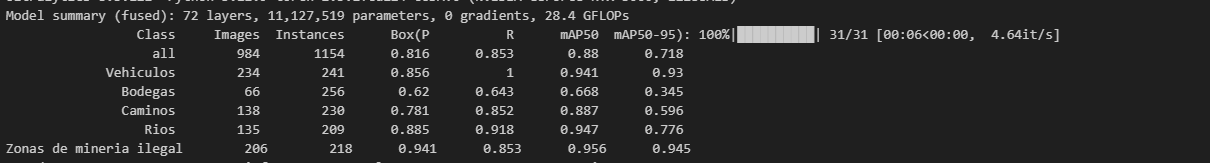

## Resultados sin fine tuning

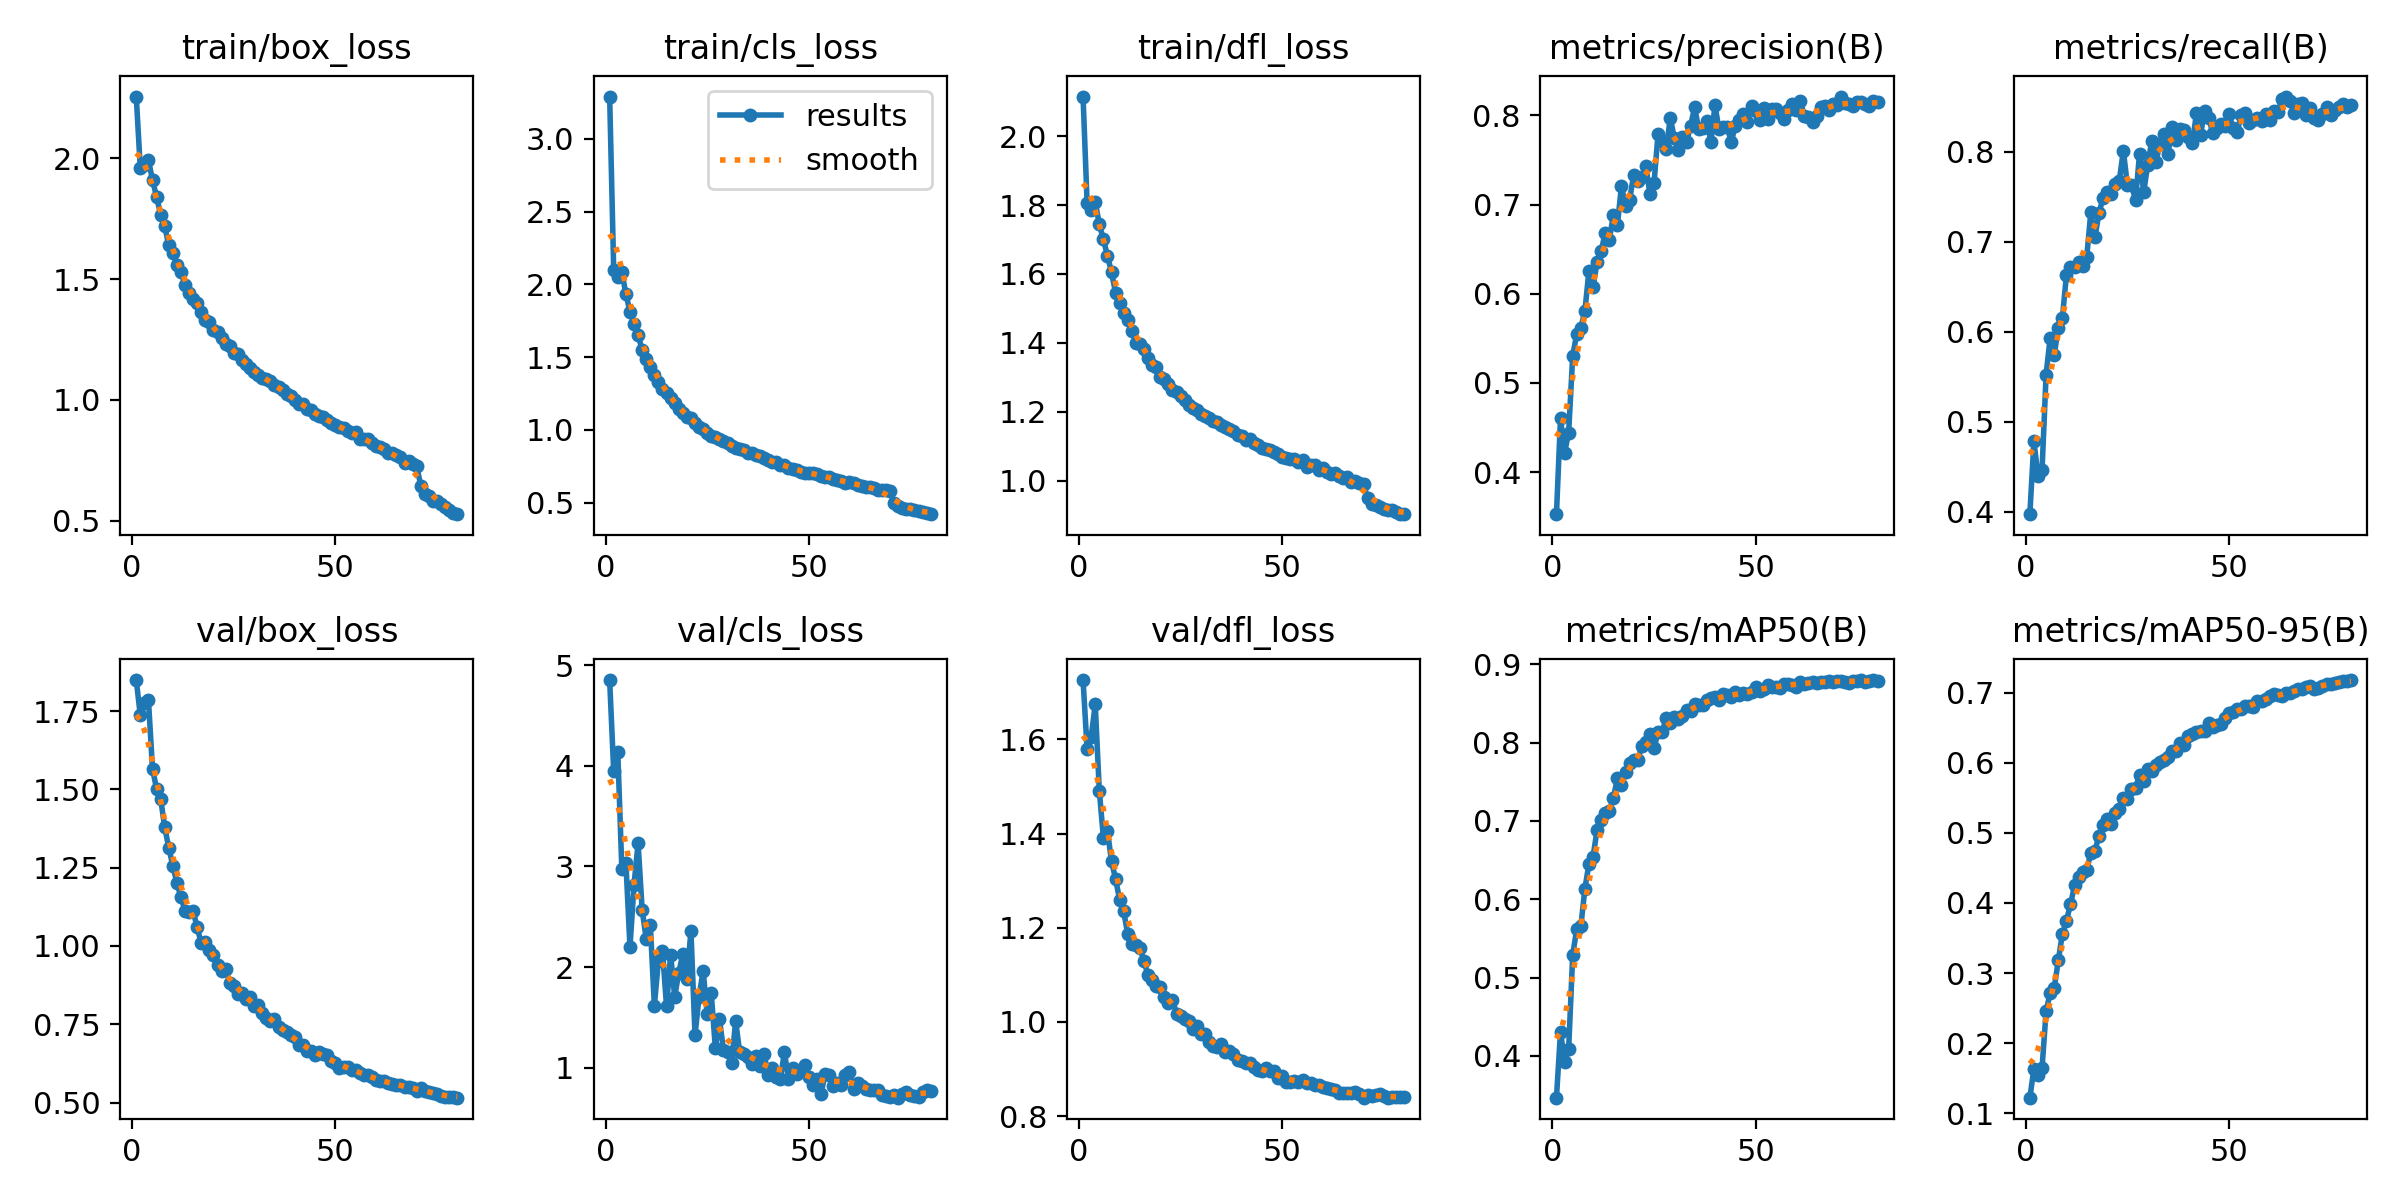

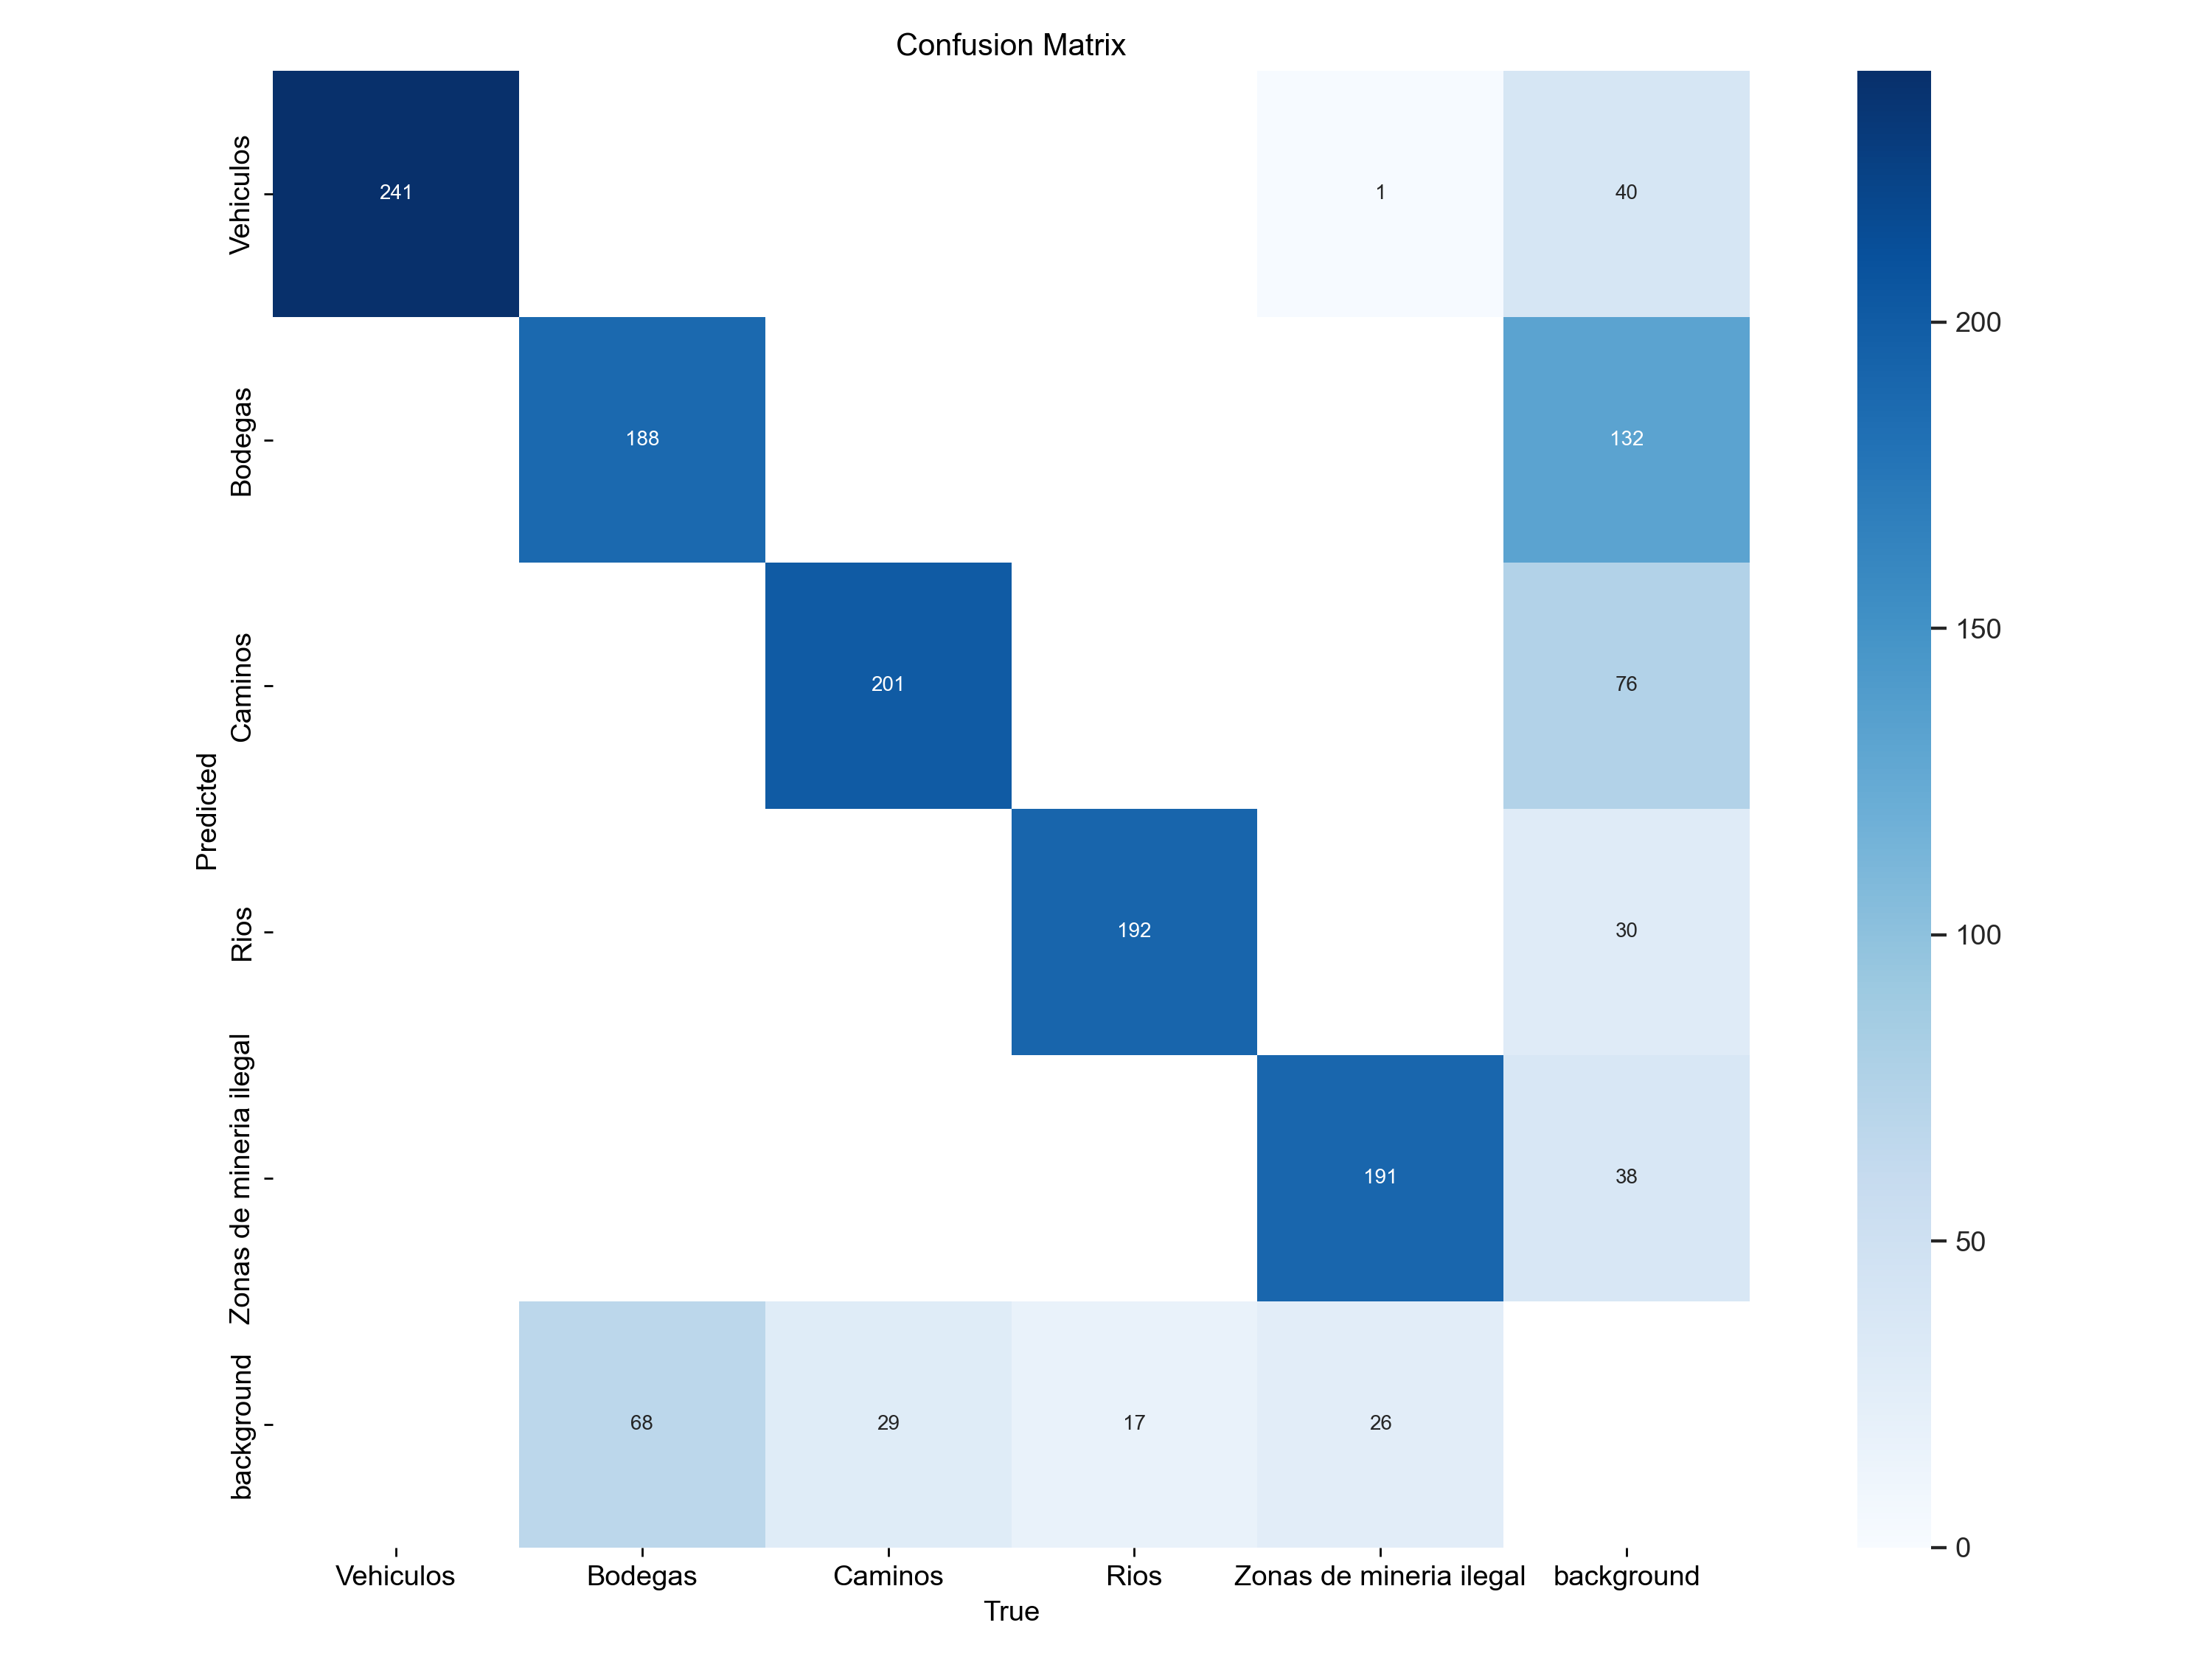

In [11]:
from PIL import Image as PImage
display(PImage.open('runs/detect/modelo_yolov11_dataset_completo_final2/results.png'))

display(PImage.open('runs/detect/modelo_yolov11_dataset_completo_final2/confusion_matrix.png'))

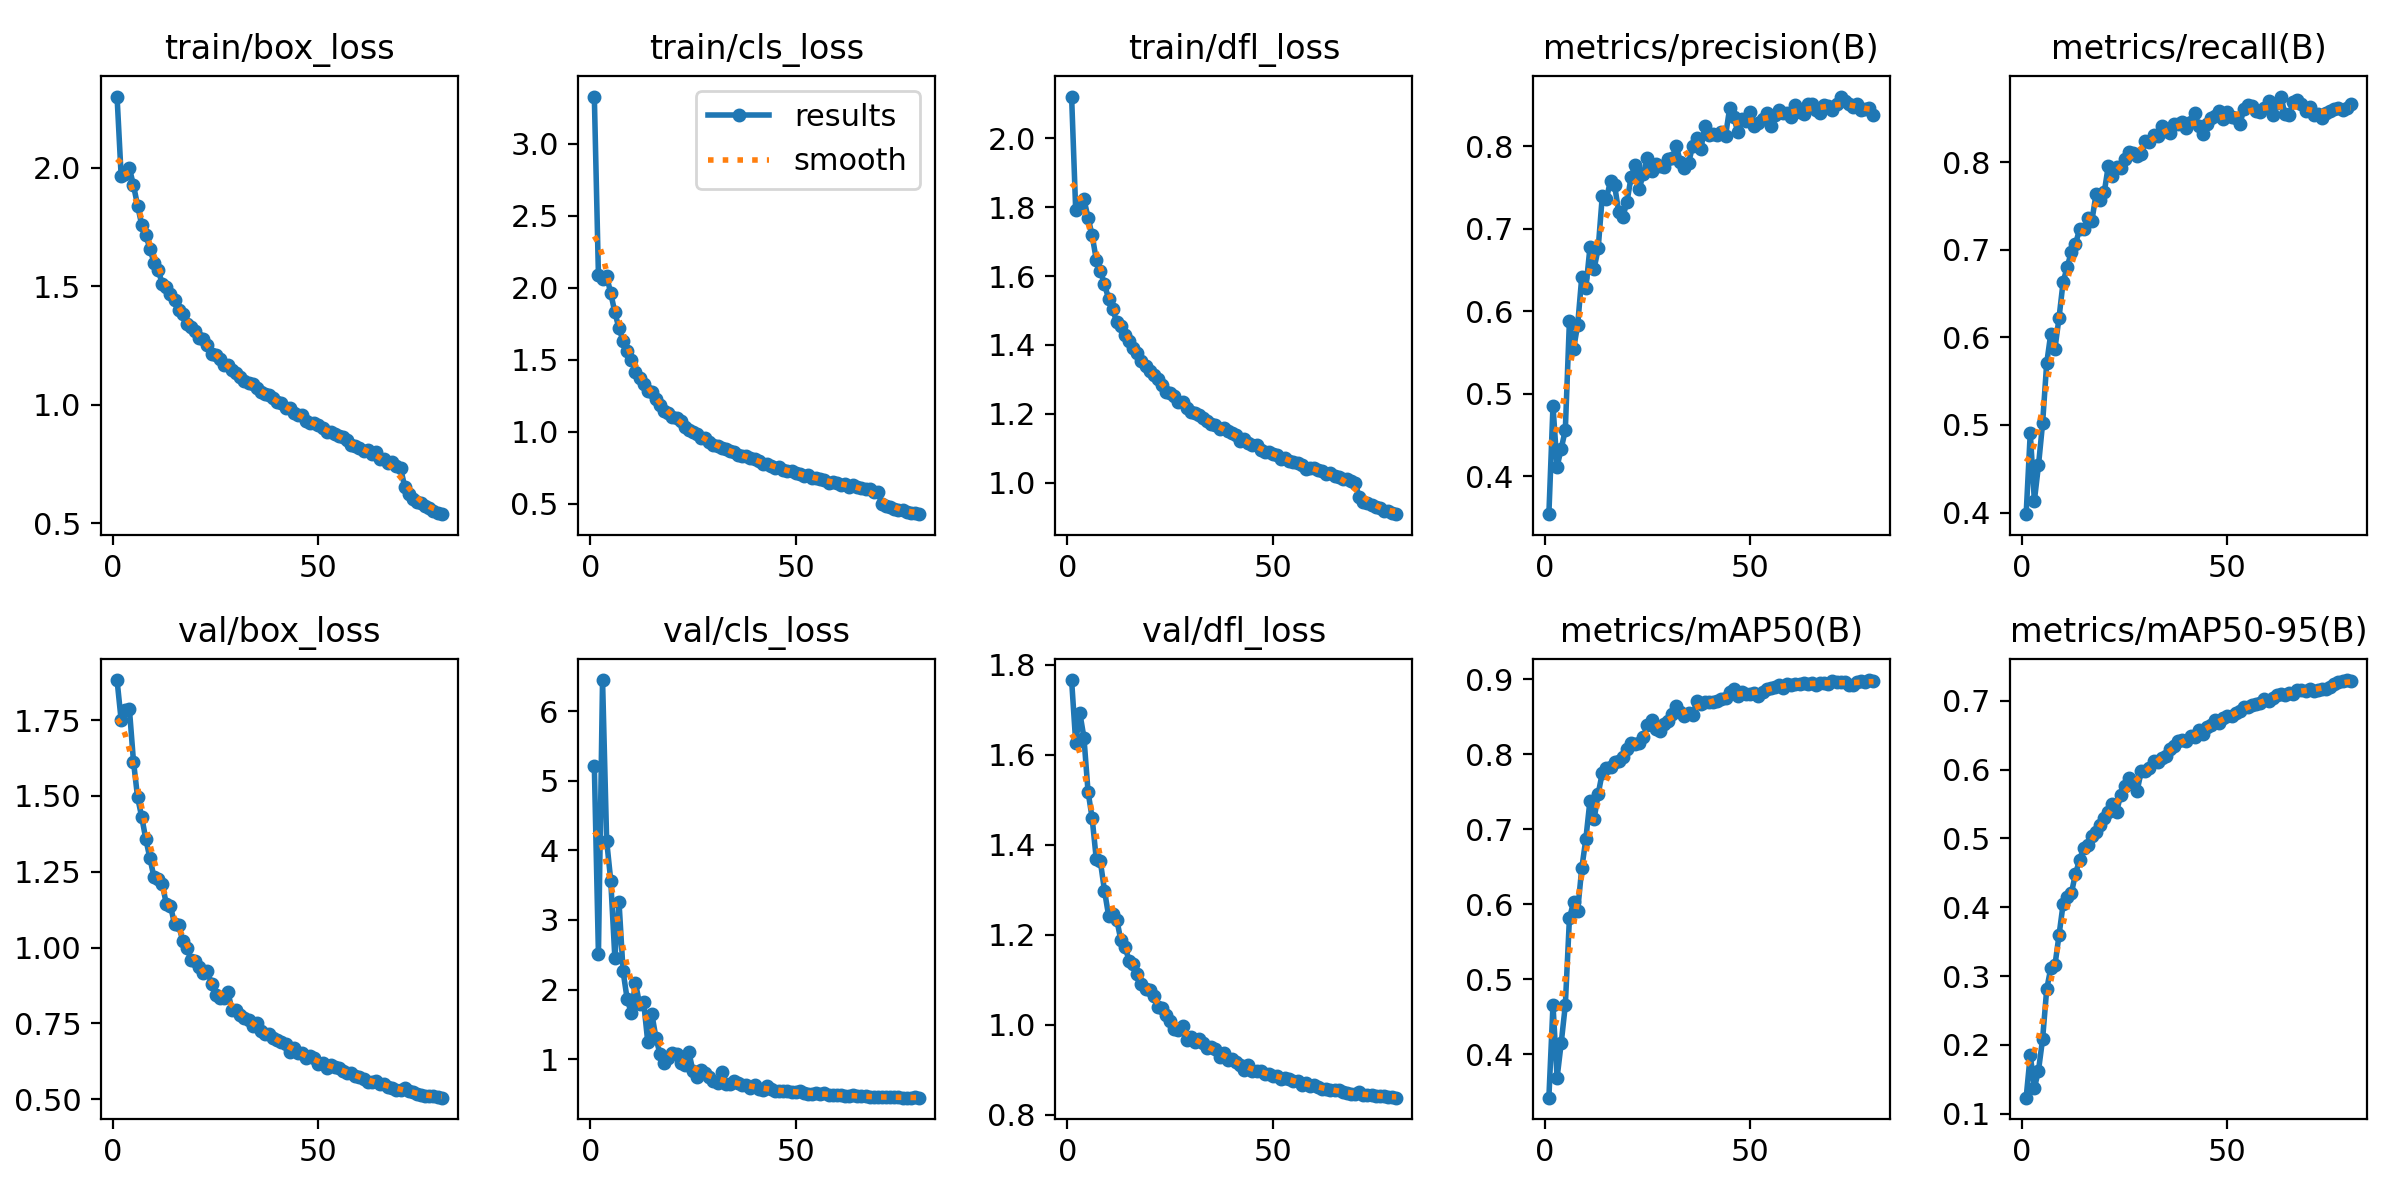

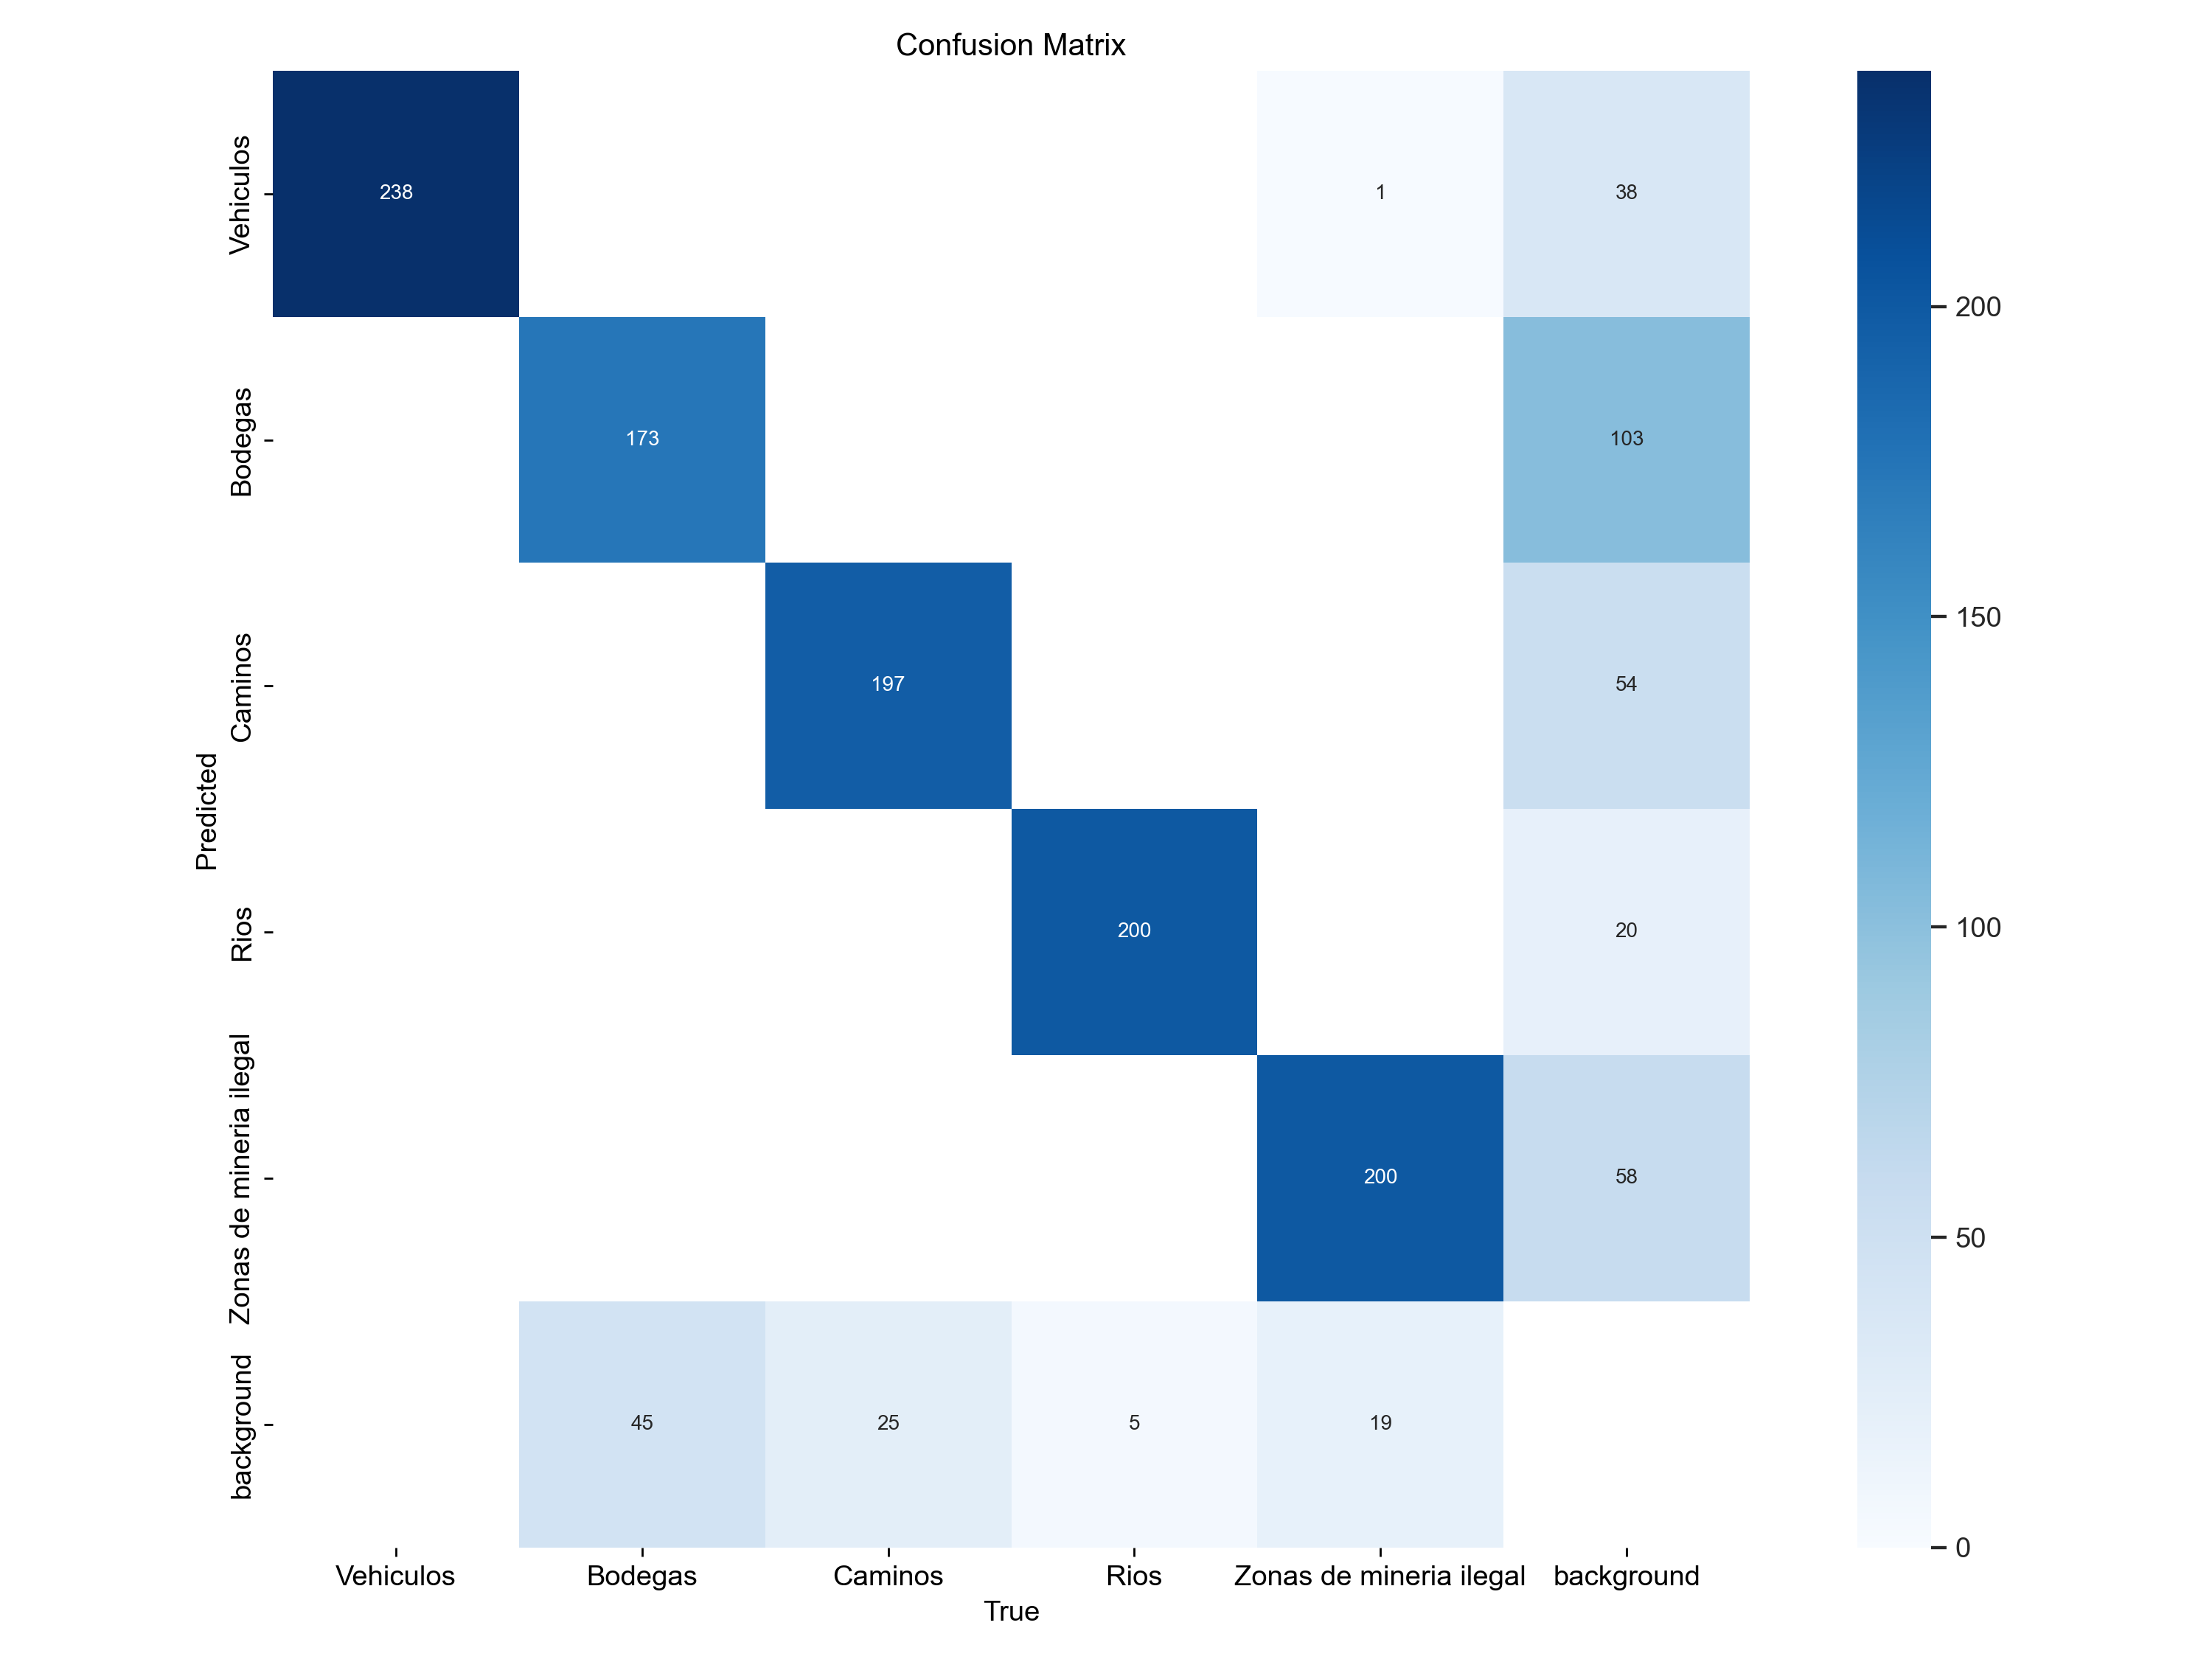

In [12]:
from PIL import Image as PImage
display(PImage.open('runs/detect/modelo_yolov11_dataset_filtrado_final3/results.png'))

display(PImage.open('runs/detect/modelo_yolov11_dataset_filtrado_final3/confusion_matrix.png'))

# Intentando con 150 epocas

Ahora vamos a intentar mejorar aun mas los modelos, ampliandolos a 150 epocas para ver en que punto se activa el early stopping y llegar al optimo

In [10]:
def entrenar_modelo_final(
    dataset_name: str,
    class_names: list,
    model_weights: str = "yolov8s.pt",
    epochs: int = 150,
    batch_size: int = 16,
    img_size: int = 640,
    patience: int = 10,
    output_name: str = "final_model",
    resume_from_ckpt: str = None,  
):
    from ultralytics import YOLO
    from pathlib import Path
    import re

    DATA_ROOT = Path(dataset_name)
    safe_name = re.sub(r"[^\w.-]", "_", output_name)
    FINAL_OUTPUT_DIR = Path(f"final_model_{safe_name}")
    FINAL_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

    yaml_path = DATA_ROOT / "dataset.yaml"
    run_name = f"{dataset_name}_final"
    project_dir = Path("runs/detect")
    best_ckpt = project_dir / run_name / "weights" / "best.pt"
    last_ckpt = project_dir / run_name / "weights" / "last.pt"

    # Opción 1: Reanudar desde checkpoint específico
    if resume_from_ckpt:
        resume_ckpt = Path(resume_from_ckpt)
        if not resume_ckpt.exists():
            raise FileNotFoundError(f"❌ Checkpoint no encontrado: {resume_ckpt}")
        print(f"🔁 Reentrenando desde checkpoint personalizado: {resume_ckpt}")
        model = YOLO(str(resume_ckpt))
        model.train(
            data=str(yaml_path),
            epochs=epochs,
            imgsz=img_size,
            batch=batch_size,
            name=run_name,
            patience=patience
        )

    # Opción 2: Ya entrenado
    elif best_ckpt.exists():
        print(f"✅ Modelo final ya entrenado. Usando best.pt: {best_ckpt}")
        model = YOLO(str(best_ckpt))

    # Opción 3: Reanudar automáticamente
    elif last_ckpt.exists():
        print(f"🔄 Reanudando entrenamiento desde last.pt: {last_ckpt}")
        model = YOLO(str(last_ckpt))
        model.train(resume=True, epochs=epochs, name=run_name)

        model = YOLO(str(best_ckpt))  # Recargar best al terminar

    # Opción 4: Entrenar desde cero
    else:
        print(f"🚀 Entrenando modelo final desde cero: {dataset_name}")
        model = YOLO(model_weights)
        model.train(
            data=str(yaml_path),
            epochs=epochs,
            imgsz=img_size,
            batch=batch_size,
            name=run_name,
            patience=patience
        )
        model = YOLO(str(best_ckpt))  # Recargar best al terminar

    # Guardar best.pt final
    final_model_path = FINAL_OUTPUT_DIR / "best_model_final.pt"
    model.save(str(final_model_path))
    print(f"\n✅ Modelo final guardado en: {final_model_path}")


# Sin preprocesamiento

In [20]:
entrenar_modelo_final(
    dataset_name="modelo_yolov11_dataset_completo",
    class_names=["Vehiculos", "Bodegas", "Caminos", "Rios", "Zonas de mineria ilegal"],
    output_name="modelo_yolov11_dataset_completo_final_v2",
)


✅ Modelo final ya entrenado. Usando best.pt: runs\detect\modelo_yolov11_dataset_completo_final\weights\best.pt

✅ Modelo final guardado en: final_model_modelo_yolov11_dataset_completo_final_v2\best_model_final.pt


In [21]:
entrenar_modelo_final(
    dataset_name="modelo_yolov11_dataset_filtrado",
    class_names=["Vehiculos", "Bodegas", "Caminos", "Rios", "Zonas de mineria ilegal"],
    output_name="modelo_yolov11_dataset_filtrado_final_v2",
)


🚀 Entrenando modelo final desde cero: modelo_yolov11_dataset_filtrado
New https://pypi.org/project/ultralytics/8.3.140 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=modelo_yolov11_dataset_filtrado\dataset.yaml, epochs=150, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=modelo_yolov11_dataset_filtrado_final, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visuali

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_filtrado\train\labels.cache... 8258 images, 2062 backgrounds, 0 corrupt: 100%|██████████| 8258/8258 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.70.5 ms, read: 16.85.4 MB/s, size: 271.5 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_filtrado\val\labels.cache... 984 images, 237 backgrounds, 0 corrupt: 100%|██████████| 984/984 [00:00<?, ?it/s]


Plotting labels to runs\detect\modelo_yolov11_dataset_filtrado_final\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/20 09:55:35 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(af75eb500c304c4fb17256b063d6ab54) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\modelo_yolov11_dataset_filtrado_final
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      3.59G      2.301       3.32      2.111          2        640: 100%|██████████| 517/517 [02:17<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.29it/s]


                   all        984       1103      0.324      0.381      0.298      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      3.78G      1.975      2.098      1.793          6        640: 100%|██████████| 517/517 [02:04<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.85it/s]

                   all        984       1103      0.372      0.455      0.385      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      3.78G      1.985      2.071      1.797          2        640: 100%|██████████| 517/517 [02:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.82it/s]

                   all        984       1103      0.424       0.43      0.379       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      3.78G      2.007        2.1      1.826          3        640: 100%|██████████| 517/517 [02:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.30it/s]

                   all        984       1103      0.494      0.445      0.443      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      3.78G       1.93      1.976      1.768          7        640: 100%|██████████| 517/517 [02:12<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.67it/s]

                   all        984       1103      0.547      0.524      0.521      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      3.78G      1.847      1.847      1.709          4        640: 100%|██████████| 517/517 [02:09<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.66it/s]

                   all        984       1103       0.51      0.521      0.511      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      3.78G      1.767      1.732      1.647          6        640: 100%|██████████| 517/517 [02:07<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  3.88it/s]

                   all        984       1103      0.585      0.565      0.581      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      3.78G      1.729       1.65       1.62          1        640: 100%|██████████| 517/517 [02:00<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.33it/s]

                   all        984       1103       0.61       0.59      0.615      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      3.78G      1.662      1.581      1.577          7        640: 100%|██████████| 517/517 [01:59<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.48it/s]

                   all        984       1103      0.625      0.636      0.665      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      3.78G       1.61      1.509      1.534          7        640: 100%|██████████| 517/517 [02:14<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.56it/s]

                   all        984       1103      0.645      0.643      0.683      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      3.78G      1.578      1.447      1.509          3        640: 100%|██████████| 517/517 [02:07<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.34it/s]

                   all        984       1103      0.627      0.664      0.698      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      3.78G      1.521      1.388      1.468          3        640: 100%|██████████| 517/517 [01:59<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.30it/s]

                   all        984       1103      0.693      0.679      0.725      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      3.78G      1.511      1.353      1.461          3        640: 100%|██████████| 517/517 [01:58<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.40it/s]

                   all        984       1103      0.699      0.719      0.744      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      3.78G      1.475      1.304      1.429          3        640: 100%|██████████| 517/517 [02:04<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.13it/s]

                   all        984       1103      0.684      0.731      0.759      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      3.78G      1.447       1.29      1.409          1        640: 100%|██████████| 517/517 [02:04<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.16it/s]

                   all        984       1103      0.695      0.736      0.761      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      3.78G      1.412      1.244      1.388          2        640: 100%|██████████| 517/517 [02:09<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  3.99it/s]

                   all        984       1103      0.725      0.704      0.764      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      3.78G      1.394      1.206       1.38          1        640: 100%|██████████| 517/517 [02:06<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.11it/s]

                   all        984       1103      0.691      0.757      0.765      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      3.78G      1.355      1.168      1.355          1        640: 100%|██████████| 517/517 [02:03<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.10it/s]

                   all        984       1103       0.74      0.738      0.792      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      3.78G      1.348      1.148      1.349          4        640: 100%|██████████| 517/517 [02:04<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.05it/s]

                   all        984       1103      0.736      0.763        0.8      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      3.78G      1.332      1.129      1.332          3        640: 100%|██████████| 517/517 [02:03<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.15it/s]

                   all        984       1103      0.763      0.728      0.797      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      3.78G      1.299      1.122      1.315          1        640: 100%|██████████| 517/517 [02:06<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.05it/s]

                   all        984       1103       0.75      0.789      0.815      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      3.78G      1.293      1.101      1.311          3        640: 100%|██████████| 517/517 [02:05<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.79it/s]

                   all        984       1103      0.732      0.777       0.78      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      3.78G      1.274      1.062      1.298          2        640: 100%|██████████| 517/517 [02:04<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.16it/s]


                   all        984       1103      0.759      0.775      0.807      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      3.78G      1.253      1.041      1.277          4        640: 100%|██████████| 517/517 [02:03<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.17it/s]

                   all        984       1103      0.768      0.794      0.815      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      3.78G      1.243      1.027      1.279          3        640: 100%|██████████| 517/517 [02:04<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.16it/s]

                   all        984       1103      0.743      0.802      0.828      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      3.78G      1.227      1.021      1.269          6        640: 100%|██████████| 517/517 [02:00<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.46it/s]

                   all        984       1103      0.784       0.79      0.832      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      3.78G      1.202      1.001      1.258          4        640: 100%|██████████| 517/517 [01:58<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.40it/s]


                   all        984       1103      0.796      0.788      0.836      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      3.78G      1.196     0.9893      1.254          8        640: 100%|██████████| 517/517 [02:00<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]

                   all        984       1103       0.76      0.816      0.834      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      3.78G      1.177     0.9633      1.238         12        640: 100%|██████████| 517/517 [02:01<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.43it/s]

                   all        984       1103      0.788      0.798      0.833       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      3.78G       1.17     0.9546      1.231          6        640: 100%|██████████| 517/517 [02:03<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.34it/s]


                   all        984       1103      0.794      0.782      0.837      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      3.78G      1.161     0.9438      1.227          3        640: 100%|██████████| 517/517 [02:00<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.36it/s]

                   all        984       1103      0.799      0.803      0.834      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      3.78G      1.141      0.927       1.22          5        640: 100%|██████████| 517/517 [02:00<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.40it/s]

                   all        984       1103       0.79      0.805      0.846      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      3.78G      1.136     0.9213      1.214          1        640: 100%|██████████| 517/517 [01:57<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.71it/s]


                   all        984       1103      0.749      0.832      0.836      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      3.78G      1.133     0.9057      1.205          1        640: 100%|██████████| 517/517 [01:56<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.76it/s]


                   all        984       1103      0.789      0.814      0.846      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      3.78G      1.114     0.8975      1.198          9        640: 100%|██████████| 517/517 [01:56<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.69it/s]


                   all        984       1103      0.801      0.819      0.856      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      3.78G      1.102     0.8881      1.197          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.60it/s]

                   all        984       1103      0.797      0.834      0.854      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      3.78G       1.09     0.8761      1.184          5        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.68it/s]

                   all        984       1103      0.821       0.82      0.855      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      3.78G      1.088     0.8715      1.185          7        640: 100%|██████████| 517/517 [01:56<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.76it/s]

                   all        984       1103      0.808       0.82      0.863      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      3.78G      1.087     0.8744      1.179          0        640: 100%|██████████| 517/517 [01:56<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.73it/s]

                   all        984       1103      0.787      0.855       0.86      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      3.78G      1.063     0.8524      1.171         12        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.70it/s]


                   all        984       1103      0.766      0.843       0.85      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      3.78G      1.067     0.8457       1.17          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.69it/s]

                   all        984       1103      0.808      0.825      0.864      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      3.78G      1.041     0.8269      1.151          0        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.75it/s]

                   all        984       1103       0.81      0.821      0.861      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      3.78G      1.052     0.8293      1.162          9        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.74it/s]

                   all        984       1103      0.826      0.811      0.854      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      3.78G      1.031     0.8272      1.147          3        640: 100%|██████████| 517/517 [01:59<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.69it/s]


                   all        984       1103      0.814      0.833      0.865      0.639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      3.78G      1.022     0.8075      1.147          6        640: 100%|██████████| 517/517 [01:57<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.73it/s]

                   all        984       1103      0.829      0.825      0.867      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      3.78G      1.021     0.8177      1.143          9        640: 100%|██████████| 517/517 [01:56<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.60it/s]

                   all        984       1103      0.826      0.836       0.87      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      3.78G      1.003     0.7951       1.13          5        640: 100%|██████████| 517/517 [01:56<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.69it/s]

                   all        984       1103      0.805      0.841      0.867      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      3.78G      1.002     0.7915      1.131          8        640: 100%|██████████| 517/517 [01:56<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.69it/s]

                   all        984       1103      0.825      0.841      0.875      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      3.78G     0.9977     0.7927      1.129          5        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.71it/s]

                   all        984       1103      0.822       0.85       0.88      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      3.78G     0.9903     0.7783      1.123          5        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.67it/s]

                   all        984       1103      0.838       0.86      0.881      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      3.78G     0.9767     0.7767      1.117          4        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.71it/s]

                   all        984       1103      0.823      0.844      0.878      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      3.78G       0.97     0.7613      1.111          3        640: 100%|██████████| 517/517 [01:56<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.69it/s]

                   all        984       1103      0.816      0.856      0.874      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      3.78G     0.9678     0.7667      1.116          9        640: 100%|██████████| 517/517 [01:56<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.76it/s]

                   all        984       1103      0.819      0.854      0.875       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      3.78G     0.9582       0.75      1.105          1        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.77it/s]

                   all        984       1103      0.849      0.849      0.882      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      3.78G     0.9604     0.7536      1.103          2        640: 100%|██████████| 517/517 [02:00<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.46it/s]

                   all        984       1103      0.833      0.858      0.883      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      3.78G     0.9544     0.7468      1.103          2        640: 100%|██████████| 517/517 [02:05<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]

                   all        984       1103      0.827      0.858      0.885      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      3.78G     0.9459     0.7406      1.098          6        640: 100%|██████████| 517/517 [02:04<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.21it/s]

                   all        984       1103      0.828      0.866      0.886       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      3.78G     0.9304     0.7319      1.091          0        640: 100%|██████████| 517/517 [02:08<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.40it/s]

                   all        984       1103      0.826      0.868      0.886      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      3.78G     0.9261     0.7304      1.092          7        640: 100%|██████████| 517/517 [02:05<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.00it/s]

                   all        984       1103      0.839      0.862      0.885      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      3.78G     0.9258     0.7269      1.092          4        640: 100%|██████████| 517/517 [02:04<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.23it/s]

                   all        984       1103      0.832      0.851      0.882      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      3.78G     0.9113     0.7146      1.081          2        640: 100%|██████████| 517/517 [02:03<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.14it/s]

                   all        984       1103      0.825       0.86      0.886      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      3.78G     0.9186     0.7193       1.08          6        640: 100%|██████████| 517/517 [02:04<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.25it/s]

                   all        984       1103       0.83      0.868      0.888      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      3.78G     0.9038     0.7082      1.073          4        640: 100%|██████████| 517/517 [02:05<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.37it/s]

                   all        984       1103      0.832      0.869      0.888      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      3.78G     0.9088     0.7112      1.075          3        640: 100%|██████████| 517/517 [02:06<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.31it/s]

                   all        984       1103      0.837      0.858      0.888      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      3.78G     0.8909     0.7053      1.074          3        640: 100%|██████████| 517/517 [02:04<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.00it/s]

                   all        984       1103       0.84      0.851      0.892      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      3.78G     0.8943     0.6999      1.072          3        640: 100%|██████████| 517/517 [02:00<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.56it/s]

                   all        984       1103      0.829      0.868      0.889      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      3.78G     0.8814     0.6888      1.066          3        640: 100%|██████████| 517/517 [02:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.19it/s]

                   all        984       1103      0.829      0.864      0.891      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      3.78G     0.8836     0.6988      1.068          4        640: 100%|██████████| 517/517 [02:04<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.20it/s]

                   all        984       1103      0.829       0.87       0.89      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      3.78G     0.8714       0.68      1.063          4        640: 100%|██████████| 517/517 [02:05<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.19it/s]

                   all        984       1103      0.827      0.872      0.891      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      3.78G     0.8694     0.6851      1.057          8        640: 100%|██████████| 517/517 [02:03<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.11it/s]

                   all        984       1103      0.823      0.876      0.891      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      3.78G       0.86     0.6754      1.051          6        640: 100%|██████████| 517/517 [02:05<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.39it/s]

                   all        984       1103       0.84      0.875      0.896      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      3.78G     0.8584       0.67      1.051          2        640: 100%|██████████| 517/517 [02:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.25it/s]

                   all        984       1103      0.837      0.869      0.892      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      3.78G     0.8522      0.664      1.047          4        640: 100%|██████████| 517/517 [02:04<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.19it/s]

                   all        984       1103      0.837       0.87      0.892      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      3.78G     0.8475     0.6629       1.05          1        640: 100%|██████████| 517/517 [02:04<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.31it/s]

                   all        984       1103      0.844      0.872      0.892      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      3.78G     0.8421     0.6574      1.047          4        640: 100%|██████████| 517/517 [02:04<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.20it/s]

                   all        984       1103      0.835      0.874      0.893       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      3.78G     0.8376     0.6601      1.043          6        640: 100%|██████████| 517/517 [02:04<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.25it/s]

                   all        984       1103      0.841      0.866      0.895      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      3.78G     0.8295     0.6492      1.038          3        640: 100%|██████████| 517/517 [02:03<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.24it/s]

                   all        984       1103      0.832      0.867      0.891      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      3.78G     0.8224     0.6533      1.036         13        640: 100%|██████████| 517/517 [01:59<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.62it/s]

                   all        984       1103      0.842      0.862      0.894      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      3.78G     0.8267     0.6433      1.033          2        640: 100%|██████████| 517/517 [01:59<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.42it/s]

                   all        984       1103      0.847      0.854      0.898      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      3.78G     0.8136     0.6369      1.028          1        640: 100%|██████████| 517/517 [02:03<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.23it/s]

                   all        984       1103      0.848      0.855      0.898      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      3.78G     0.8107     0.6322      1.027          2        640: 100%|██████████| 517/517 [02:03<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.60it/s]

                   all        984       1103      0.838      0.868      0.897      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      3.78G     0.8033     0.6339      1.026          3        640: 100%|██████████| 517/517 [01:59<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.50it/s]

                   all        984       1103      0.832      0.863      0.894      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      3.78G     0.8011     0.6281      1.022          3        640: 100%|██████████| 517/517 [02:04<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.25it/s]

                   all        984       1103       0.83      0.871      0.895       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      3.78G     0.7951     0.6213      1.018         10        640: 100%|██████████| 517/517 [02:05<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  3.96it/s]

                   all        984       1103      0.834      0.872      0.893       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      3.78G     0.7926     0.6297      1.018          3        640: 100%|██████████| 517/517 [02:02<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.48it/s]

                   all        984       1103      0.834      0.875      0.894      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      3.78G     0.7767     0.6172      1.008          4        640: 100%|██████████| 517/517 [02:03<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.27it/s]

                   all        984       1103      0.826      0.883      0.896      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      3.78G     0.7891     0.6166      1.014          3        640: 100%|██████████| 517/517 [01:59<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.51it/s]

                   all        984       1103      0.834      0.883      0.899      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      3.78G     0.7809     0.6135      1.013          4        640: 100%|██████████| 517/517 [01:59<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.61it/s]

                   all        984       1103      0.838      0.887      0.901      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      3.78G     0.7818      0.613      1.015          5        640: 100%|██████████| 517/517 [01:59<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.53it/s]

                   all        984       1103      0.836      0.884      0.899      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      3.78G      0.766     0.6068      1.006          2        640: 100%|██████████| 517/517 [01:59<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.33it/s]

                   all        984       1103      0.833      0.881      0.897      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      3.78G     0.7699     0.6097       1.01          2        640: 100%|██████████| 517/517 [01:59<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.63it/s]

                   all        984       1103      0.833      0.882      0.898      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      3.78G     0.7594     0.5982      1.002          5        640: 100%|██████████| 517/517 [01:59<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.42it/s]

                   all        984       1103       0.83      0.882      0.898      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      3.78G     0.7448     0.5842     0.9991          4        640: 100%|██████████| 517/517 [01:59<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.45it/s]

                   all        984       1103       0.83      0.882      0.899       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      3.78G     0.7576     0.5953      1.003          6        640: 100%|██████████| 517/517 [01:59<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.30it/s]

                   all        984       1103      0.831      0.885      0.901      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      3.78G     0.7563     0.5971      1.004          2        640: 100%|██████████| 517/517 [02:05<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.23it/s]

                   all        984       1103      0.837      0.879      0.899      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      3.78G     0.7454     0.5868     0.9949         15        640: 100%|██████████| 517/517 [02:04<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.23it/s]

                   all        984       1103      0.838      0.879      0.901      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      3.78G     0.7378     0.5896     0.9922          5        640: 100%|██████████| 517/517 [02:04<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.19it/s]

                   all        984       1103       0.84      0.878      0.902      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      3.78G     0.7418     0.5839     0.9939         12        640: 100%|██████████| 517/517 [02:04<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.17it/s]

                   all        984       1103      0.842      0.882      0.902      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      3.78G     0.7174      0.575     0.9821          3        640: 100%|██████████| 517/517 [02:03<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.48it/s]

                   all        984       1103      0.847      0.874      0.901      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      3.78G     0.7282     0.5729     0.9885          1        640: 100%|██████████| 517/517 [02:05<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.42it/s]

                   all        984       1103      0.844      0.874      0.901      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      3.78G     0.7251     0.5649     0.9867          4        640: 100%|██████████| 517/517 [01:59<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.46it/s]

                   all        984       1103      0.842      0.874      0.901      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      3.78G      0.714     0.5618       0.98          2        640: 100%|██████████| 517/517 [01:59<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.54it/s]

                   all        984       1103      0.843      0.872        0.9      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      3.78G     0.7148     0.5615     0.9757          2        640: 100%|██████████| 517/517 [01:58<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.54it/s]

                   all        984       1103      0.844      0.872        0.9      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      3.78G     0.7046     0.5583     0.9788          1        640: 100%|██████████| 517/517 [02:02<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  3.96it/s]

                   all        984       1103      0.844      0.869      0.899      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      3.78G     0.6973     0.5543     0.9755          8        640: 100%|██████████| 517/517 [02:02<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.58it/s]

                   all        984       1103      0.843      0.874        0.9      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      3.78G     0.6976     0.5501     0.9754          6        640: 100%|██████████| 517/517 [01:59<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.43it/s]

                   all        984       1103      0.843      0.873        0.9      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      3.78G     0.6927     0.5508     0.9717          9        640: 100%|██████████| 517/517 [02:02<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.23it/s]

                   all        984       1103      0.843      0.874      0.899      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      3.78G     0.6939     0.5482     0.9715         21        640: 100%|██████████| 517/517 [02:04<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.25it/s]

                   all        984       1103       0.84      0.876      0.899      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      3.78G     0.6819     0.5497     0.9681          5        640: 100%|██████████| 517/517 [02:05<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.20it/s]

                   all        984       1103      0.843      0.878      0.901       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      3.78G      0.674     0.5392     0.9623          2        640: 100%|██████████| 517/517 [02:04<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.25it/s]

                   all        984       1103      0.846      0.876      0.899       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      3.78G     0.6719     0.5384     0.9604          3        640: 100%|██████████| 517/517 [02:04<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.36it/s]

                   all        984       1103      0.846      0.874      0.899      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      3.78G     0.6674     0.5349     0.9607          2        640: 100%|██████████| 517/517 [02:05<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.29it/s]

                   all        984       1103      0.845      0.875      0.899      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      3.78G     0.6654     0.5301     0.9597          3        640: 100%|██████████| 517/517 [02:06<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.43it/s]

                   all        984       1103      0.847      0.873      0.899      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      3.78G     0.6591     0.5227     0.9587          5        640: 100%|██████████| 517/517 [02:07<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.10it/s]

                   all        984       1103      0.847      0.871      0.898      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      3.78G     0.6552      0.532     0.9577          7        640: 100%|██████████| 517/517 [02:04<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.25it/s]

                   all        984       1103      0.847      0.872      0.898      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      3.78G      0.653     0.5213     0.9559          3        640: 100%|██████████| 517/517 [02:04<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.34it/s]

                   all        984       1103      0.849      0.872      0.898      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      3.78G     0.6494     0.5184     0.9512          0        640: 100%|██████████| 517/517 [02:00<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.38it/s]


                   all        984       1103      0.845      0.871      0.898      0.742

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      3.78G     0.6411     0.5168     0.9516          6        640: 100%|██████████| 517/517 [02:00<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.48it/s]

                   all        984       1103       0.84      0.876      0.897      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      3.78G     0.6344     0.5195     0.9486          2        640: 100%|██████████| 517/517 [02:06<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.04it/s]

                   all        984       1103      0.845      0.871      0.897      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      3.78G     0.6375     0.5144     0.9492          5        640: 100%|██████████| 517/517 [02:08<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]

                   all        984       1103       0.84      0.875      0.897      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      3.78G     0.6298     0.5141     0.9427          7        640: 100%|██████████| 517/517 [01:59<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.57it/s]

                   all        984       1103      0.847      0.873      0.896      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      3.78G     0.6277     0.5097     0.9449          3        640: 100%|██████████| 517/517 [01:59<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.23it/s]

                   all        984       1103      0.837      0.876      0.896      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      3.78G     0.6292     0.5073     0.9465          5        640: 100%|██████████| 517/517 [02:00<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.56it/s]

                   all        984       1103      0.835      0.881      0.896      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      3.78G     0.6201     0.4981     0.9441          3        640: 100%|██████████| 517/517 [01:59<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.39it/s]

                   all        984       1103      0.834       0.88      0.896      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      3.78G     0.6125     0.4998     0.9397          4        640: 100%|██████████| 517/517 [02:00<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.52it/s]

                   all        984       1103      0.835       0.88      0.895      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      3.78G     0.6087     0.4907     0.9373          6        640: 100%|██████████| 517/517 [02:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.51it/s]


                   all        984       1103      0.838      0.877      0.894      0.747

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      3.78G      0.611     0.4918     0.9404          4        640: 100%|██████████| 517/517 [02:06<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.35it/s]

                   all        984       1103      0.837      0.881      0.894      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      3.78G     0.6025     0.4932     0.9339          8        640: 100%|██████████| 517/517 [02:00<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.53it/s]

                   all        984       1103      0.836      0.879      0.895      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      3.78G     0.5914     0.4911      0.933          7        640: 100%|██████████| 517/517 [01:59<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.49it/s]

                   all        984       1103      0.835      0.879      0.895      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      3.78G      0.596     0.4885     0.9307          0        640: 100%|██████████| 517/517 [01:59<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.53it/s]

                   all        984       1103      0.835      0.882      0.895      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      3.78G     0.5972     0.4917      0.935          8        640: 100%|██████████| 517/517 [01:59<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.38it/s]

                   all        984       1103      0.836      0.881      0.895      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      3.78G     0.5895      0.482     0.9285          5        640: 100%|██████████| 517/517 [01:59<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.64it/s]

                   all        984       1103      0.836      0.881      0.895      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      3.78G     0.5801     0.4826     0.9298          2        640: 100%|██████████| 517/517 [01:59<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.46it/s]

                   all        984       1103      0.836      0.879      0.895      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      3.78G     0.5851     0.4834     0.9297          3        640: 100%|██████████| 517/517 [01:59<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.78it/s]

                   all        984       1103      0.835      0.881      0.895      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      3.78G     0.5765     0.4673     0.9249          6        640: 100%|██████████| 517/517 [02:04<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.32it/s]

                   all        984       1103      0.836      0.881      0.895      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      3.78G     0.5665     0.4669     0.9237          3        640: 100%|██████████| 517/517 [02:04<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.32it/s]

                   all        984       1103      0.837       0.88      0.895      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      3.78G     0.5704     0.4663     0.9242          2        640: 100%|██████████| 517/517 [02:04<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.15it/s]

                   all        984       1103      0.829      0.885      0.895      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      3.78G     0.5637     0.4679     0.9245          8        640: 100%|██████████| 517/517 [02:04<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.36it/s]

                   all        984       1103      0.829      0.885      0.895       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      3.78G     0.5622     0.4643     0.9241          5        640: 100%|██████████| 517/517 [02:05<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.37it/s]

                   all        984       1103       0.83      0.885      0.894       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      3.78G     0.5551     0.4584     0.9176          5        640: 100%|██████████| 517/517 [02:05<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.15it/s]

                   all        984       1103      0.829      0.885      0.894       0.75


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      3.78G     0.4876     0.4047     0.8755          2        640: 100%|██████████| 517/517 [02:06<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]


                   all        984       1103       0.83      0.885      0.894       0.75

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      3.78G     0.4548     0.3812     0.8644          3        640: 100%|██████████| 517/517 [02:04<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]

                   all        984       1103       0.83      0.884      0.894       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      3.78G     0.4509     0.3753     0.8647          2        640: 100%|██████████| 517/517 [02:03<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.20it/s]

                   all        984       1103      0.829      0.884      0.894       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      3.78G     0.4389     0.3728     0.8603          1        640: 100%|██████████| 517/517 [02:04<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.32it/s]

                   all        984       1103      0.828      0.884      0.894       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      3.78G     0.4344     0.3669      0.861          2        640: 100%|██████████| 517/517 [02:00<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.30it/s]

                   all        984       1103      0.828      0.884      0.893       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      3.78G     0.4252     0.3612     0.8562          1        640: 100%|██████████| 517/517 [01:58<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.64it/s]


                   all        984       1103      0.829      0.884      0.893       0.75

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      3.78G     0.4213     0.3571     0.8528          2        640: 100%|██████████| 517/517 [01:58<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.59it/s]

                   all        984       1103      0.829      0.884      0.893       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      3.78G     0.4169     0.3591     0.8508          2        640: 100%|██████████| 517/517 [01:58<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.45it/s]

                   all        984       1103      0.836      0.878      0.892       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      3.78G      0.415     0.3579     0.8515          2        640: 100%|██████████| 517/517 [01:58<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.59it/s]

                   all        984       1103      0.836      0.878      0.892       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      3.78G     0.4068      0.351     0.8502          2        640: 100%|██████████| 517/517 [01:58<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.56it/s]

                   all        984       1103      0.836      0.878      0.892       0.75



150 epochs completed in 5.438 hours.
Optimizer stripped from runs\detect\modelo_yolov11_dataset_filtrado_final\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\modelo_yolov11_dataset_filtrado_final\weights\best.pt, 22.5MB

Validating runs\detect\modelo_yolov11_dataset_filtrado_final\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.16it/s]


                   all        984       1103      0.829      0.884      0.894       0.75
             Vehiculos        233        238      0.861          1      0.948      0.941
               Bodegas         65        218       0.62      0.734      0.681       0.36
               Caminos        134        222      0.815      0.869      0.905      0.669
                  Rios        137        205      0.918      0.951      0.974       0.83
Zonas de mineria ilegal        207        220      0.933      0.864      0.959      0.951
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_filtrado_final
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'

✅ Modelo final guardado en: final_model_modelo_yolov11_dataset_filtrado_final_v2\best_model_final.pt


# Con preprocesamiento

In [22]:

entrenar_modelo_final(
    dataset_name="preprocesamiento/modelo_yolov11_dataset_filtrado_preprocesado", 
    class_names=["Vehiculos", "Bodegas", "Caminos", "Rios", "Mineria ilegal"], 
    output_name="preprocesamiento/modelo_yolov11_dataset_filtrado_preprocesado_v2",
    epochs=150,
)

🚀 Entrenando modelo final desde cero: preprocesamiento/modelo_yolov11_dataset_filtrado_preprocesado
New https://pypi.org/project/ultralytics/8.3.140 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado\dataset.yaml, epochs=150, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=modelo_yolov11_dataset_filtrado_preprocesado_final, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=F

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado\train\labels.cache... 8258 images, 2062 backgrounds, 0 corrupt: 100%|██████████| 8258/8258 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.30.1 ms, read: 26.09.0 MB/s, size: 419.5 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado\val\labels.cache... 984 images, 237 backgrounds, 0 corrupt: 100%|██████████| 984/984 [00:00<?, ?it/s]


Plotting labels to runs\detect\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado_final\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/20 15:23:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(17f7e61ebc904c829a9d89cbe2bbd6eb) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado_final
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      4.05G      2.281      3.361      2.128          2        640: 100%|██████████| 517/517 [02:07<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.48it/s]

                   all        984       1103      0.335      0.373      0.293      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      4.23G      1.956      2.076      1.806          6        640: 100%|██████████| 517/517 [01:58<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.60it/s]

                   all        984       1103      0.478      0.514      0.469      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      4.23G      1.966      2.021      1.787          2        640: 100%|██████████| 517/517 [01:56<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.59it/s]


                   all        984       1103      0.319      0.269      0.215      0.085

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      4.23G       1.99      2.055      1.824          3        640: 100%|██████████| 517/517 [01:59<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.52it/s]


                   all        984       1103      0.444      0.504      0.439      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      4.23G      1.917      1.944      1.772          7        640: 100%|██████████| 517/517 [01:55<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.68it/s]

                   all        984       1103      0.485      0.473      0.441       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      4.23G      1.836      1.807      1.718          4        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.51it/s]

                   all        984       1103      0.546      0.589       0.56      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      4.23G      1.758      1.705      1.661          6        640: 100%|██████████| 517/517 [01:56<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.51it/s]

                   all        984       1103      0.488      0.435      0.393      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      4.23G      1.707      1.619       1.62          1        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.63it/s]


                   all        984       1103      0.653      0.622      0.664      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      4.23G      1.647      1.554      1.577          7        640: 100%|██████████| 517/517 [01:56<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.38it/s]


                   all        984       1103      0.624      0.639      0.657      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      4.23G      1.596      1.484      1.529          7        640: 100%|██████████| 517/517 [01:56<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.64it/s]

                   all        984       1103      0.661      0.614      0.682      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      4.23G      1.551      1.407      1.498          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.58it/s]

                   all        984       1103      0.716      0.633      0.719      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      4.23G      1.503       1.36      1.469          3        640: 100%|██████████| 517/517 [01:56<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.59it/s]

                   all        984       1103      0.643      0.706       0.72      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      4.23G      1.502      1.335      1.462          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.59it/s]

                   all        984       1103      0.708      0.683      0.743      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      4.23G      1.458      1.277       1.43          3        640: 100%|██████████| 517/517 [01:57<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.70it/s]

                   all        984       1103      0.729      0.728      0.761      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      4.23G      1.436      1.257      1.414          1        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.57it/s]


                   all        984       1103      0.714      0.734       0.78       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      4.23G      1.396      1.223      1.394          2        640: 100%|██████████| 517/517 [01:56<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.67it/s]

                   all        984       1103      0.712      0.744      0.763      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      4.23G      1.377      1.185      1.377          1        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.68it/s]

                   all        984       1103      0.726      0.767      0.779      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      4.23G      1.339      1.141      1.352          1        640: 100%|██████████| 517/517 [01:58<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.77it/s]

                   all        984       1103      0.736      0.767       0.79      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      4.23G      1.334      1.136       1.35          4        640: 100%|██████████| 517/517 [01:56<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.51it/s]

                   all        984       1103      0.715      0.776      0.796      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      4.23G      1.316      1.105      1.335          3        640: 100%|██████████| 517/517 [01:56<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.57it/s]

                   all        984       1103      0.762       0.75      0.792      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      4.23G      1.293      1.106      1.318          1        640: 100%|██████████| 517/517 [01:56<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.46it/s]

                   all        984       1103      0.742      0.771      0.809      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      4.23G      1.287      1.084      1.313          3        640: 100%|██████████| 517/517 [01:56<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.58it/s]


                   all        984       1103      0.759      0.774      0.807      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      4.23G      1.264      1.046      1.296          2        640: 100%|██████████| 517/517 [01:56<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.68it/s]

                   all        984       1103      0.751      0.794      0.814      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      4.23G      1.237      1.024      1.281          4        640: 100%|██████████| 517/517 [01:56<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.47it/s]

                   all        984       1103      0.757      0.801      0.813      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      4.23G      1.226      1.005      1.277          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.61it/s]


                   all        984       1103      0.773      0.807      0.825      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      4.23G      1.214     0.9994      1.264          6        640: 100%|██████████| 517/517 [01:56<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.72it/s]

                   all        984       1103      0.777      0.814      0.838       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      4.23G      1.187     0.9817       1.25          4        640: 100%|██████████| 517/517 [01:56<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.68it/s]

                   all        984       1103      0.781      0.806      0.834      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      4.23G      1.179     0.9665      1.247          8        640: 100%|██████████| 517/517 [01:57<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.32it/s]

                   all        984       1103      0.761      0.817      0.827       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      4.23G       1.16     0.9477      1.229         12        640: 100%|██████████| 517/517 [01:57<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.61it/s]


                   all        984       1103      0.752       0.81      0.824      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      4.23G      1.153      0.926      1.223          6        640: 100%|██████████| 517/517 [01:56<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.67it/s]

                   all        984       1103      0.796      0.802      0.842      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      4.23G      1.141     0.9192      1.218          3        640: 100%|██████████| 517/517 [01:56<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.75it/s]

                   all        984       1103        0.8      0.813      0.844      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      4.23G      1.129     0.9101      1.212          5        640: 100%|██████████| 517/517 [01:56<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.80it/s]


                   all        984       1103      0.815      0.818      0.865       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      4.23G      1.129     0.9105      1.212          1        640: 100%|██████████| 517/517 [02:07<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.00it/s]

                   all        984       1103      0.765      0.837      0.854      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      4.23G      1.116     0.8914      1.193          1        640: 100%|██████████| 517/517 [02:01<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.36it/s]

                   all        984       1103      0.804      0.808      0.853      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      4.23G        1.1      0.886      1.187          9        640: 100%|██████████| 517/517 [01:59<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.49it/s]

                   all        984       1103      0.782      0.836      0.854      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      4.23G      1.092     0.8697      1.189          3        640: 100%|██████████| 517/517 [01:59<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.32it/s]

                   all        984       1103      0.796       0.84      0.863      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      4.23G      1.079     0.8591      1.178          5        640: 100%|██████████| 517/517 [02:00<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.33it/s]


                   all        984       1103      0.816      0.837      0.868      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      4.23G       1.08     0.8625      1.178          7        640: 100%|██████████| 517/517 [02:00<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]

                   all        984       1103      0.806      0.835      0.868      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      4.23G      1.068     0.8557      1.169          0        640: 100%|██████████| 517/517 [01:59<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.07it/s]

                   all        984       1103      0.814      0.836      0.869      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      4.23G      1.047     0.8448      1.163         12        640: 100%|██████████| 517/517 [01:59<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.46it/s]

                   all        984       1103      0.817      0.813      0.868      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      4.23G       1.05     0.8297      1.158          3        640: 100%|██████████| 517/517 [01:56<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.65it/s]

                   all        984       1103      0.813      0.846      0.872      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      4.23G      1.028     0.8166      1.143          0        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.69it/s]

                   all        984       1103      0.826      0.824      0.864      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      4.23G      1.037     0.8156      1.154          9        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.59it/s]

                   all        984       1103      0.807      0.844      0.868      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      4.23G      1.017     0.8089      1.143          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.51it/s]

                   all        984       1103      0.826      0.829      0.875      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      4.23G      1.007     0.7939       1.14          6        640: 100%|██████████| 517/517 [01:55<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.75it/s]

                   all        984       1103      0.822      0.834      0.877      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      4.23G      1.012     0.8047      1.141          9        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.52it/s]


                   all        984       1103      0.834      0.835      0.878      0.659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      4.23G     0.9914     0.7854      1.132          5        640: 100%|██████████| 517/517 [01:59<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.66it/s]

                   all        984       1103      0.826       0.84      0.873      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      4.23G     0.9793     0.7791      1.122          8        640: 100%|██████████| 517/517 [01:56<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.63it/s]

                   all        984       1103      0.838      0.844      0.883      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      4.23G     0.9792     0.7731      1.122          5        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.68it/s]

                   all        984       1103      0.838      0.848      0.883      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      4.23G     0.9768     0.7693      1.116          5        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.76it/s]


                   all        984       1103      0.843      0.862      0.887      0.677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      4.23G     0.9636     0.7621      1.112          4        640: 100%|██████████| 517/517 [01:56<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.76it/s]

                   all        984       1103        0.8      0.859      0.881      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      4.23G     0.9551     0.7461      1.108          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.77it/s]


                   all        984       1103      0.834       0.86      0.877      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      4.23G     0.9531     0.7567      1.108          9        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.72it/s]


                   all        984       1103      0.826      0.854      0.879      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      4.23G     0.9512     0.7407      1.104          1        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.74it/s]

                   all        984       1103      0.841      0.853      0.883      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      4.23G     0.9457     0.7429      1.097          2        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.68it/s]

                   all        984       1103      0.842      0.852      0.884      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      4.23G     0.9403     0.7306      1.094          2        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.76it/s]

                   all        984       1103      0.839      0.856      0.884      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      4.23G     0.9341     0.7268       1.09          6        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.69it/s]

                   all        984       1103      0.834      0.864      0.888      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      4.23G     0.9144     0.7096      1.085          0        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.87it/s]

                   all        984       1103      0.832      0.861      0.887      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      4.23G     0.9117      0.717      1.081          7        640: 100%|██████████| 517/517 [01:56<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.81it/s]

                   all        984       1103      0.833      0.864      0.893      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      4.23G     0.9091     0.7127      1.085          4        640: 100%|██████████| 517/517 [01:56<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.59it/s]

                   all        984       1103      0.838      0.862       0.89      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      4.23G     0.8955        0.7      1.074          2        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.45it/s]

                   all        984       1103      0.837      0.855      0.883       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      4.23G     0.9095     0.7057      1.074          6        640: 100%|██████████| 517/517 [01:59<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.62it/s]


                   all        984       1103      0.832      0.856      0.886      0.694

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      4.23G     0.8903     0.6946      1.069          4        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.79it/s]

                   all        984       1103      0.848      0.846      0.887      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      4.23G     0.9019     0.7037      1.071          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.72it/s]

                   all        984       1103      0.825      0.861      0.885      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      4.23G     0.8754     0.6954      1.066          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.87it/s]


                   all        984       1103      0.821      0.865      0.888      0.694

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      4.23G     0.8821      0.688      1.068          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.70it/s]


                   all        984       1103      0.818      0.878       0.89        0.7

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      4.23G      0.865     0.6771      1.056          3        640: 100%|██████████| 517/517 [01:56<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.77it/s]

                   all        984       1103      0.817       0.87      0.888      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      4.23G     0.8672     0.6837      1.059          4        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.72it/s]

                   all        984       1103      0.824      0.868      0.891      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      4.23G      0.855     0.6638      1.051          4        640: 100%|██████████| 517/517 [01:55<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.77it/s]

                   all        984       1103      0.836       0.87      0.892      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      4.23G     0.8512     0.6698      1.045          8        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.76it/s]

                   all        984       1103      0.824      0.874      0.892      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      4.23G     0.8494     0.6605      1.045          6        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.73it/s]

                   all        984       1103      0.834      0.871      0.895      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      4.23G     0.8461     0.6607      1.046          2        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.93it/s]

                   all        984       1103      0.839      0.866      0.893      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      4.23G     0.8397     0.6586      1.044          4        640: 100%|██████████| 517/517 [01:55<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.74it/s]

                   all        984       1103       0.83      0.872      0.892      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      4.23G     0.8318     0.6543      1.041          1        640: 100%|██████████| 517/517 [01:54<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.79it/s]

                   all        984       1103      0.833       0.87      0.893      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      4.23G     0.8263      0.643      1.036          4        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.78it/s]

                   all        984       1103      0.836      0.859      0.895      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      4.23G      0.824     0.6463      1.035          6        640: 100%|██████████| 517/517 [01:58<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.80it/s]

                   all        984       1103      0.834      0.869      0.894      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      4.23G     0.8167      0.641      1.031          3        640: 100%|██████████| 517/517 [01:56<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.66it/s]

                   all        984       1103      0.832      0.872      0.893      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      4.23G     0.8079     0.6425      1.028         13        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.77it/s]

                   all        984       1103      0.822      0.874      0.894      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      4.23G     0.8142     0.6325       1.03          2        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.70it/s]

                   all        984       1103       0.84      0.869      0.895      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      4.23G     0.7998     0.6295      1.025          1        640: 100%|██████████| 517/517 [01:56<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.78it/s]


                   all        984       1103      0.844       0.86      0.896      0.722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      4.23G     0.7983     0.6226      1.019          2        640: 100%|██████████| 517/517 [01:56<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.74it/s]

                   all        984       1103      0.831      0.864      0.897      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      4.23G     0.7873     0.6196      1.016          3        640: 100%|██████████| 517/517 [02:04<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.81it/s]

                   all        984       1103      0.824      0.871      0.893      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      4.23G     0.7848     0.6207      1.014          3        640: 100%|██████████| 517/517 [02:03<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.05it/s]

                   all        984       1103      0.826      0.871      0.893      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      4.23G     0.7777     0.6068       1.01         10        640: 100%|██████████| 517/517 [02:08<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.33it/s]

                   all        984       1103      0.832      0.867      0.892      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      4.23G     0.7812     0.6136      1.015          3        640: 100%|██████████| 517/517 [02:12<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.47it/s]

                   all        984       1103      0.837      0.864      0.894      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      4.23G     0.7677     0.6036      1.006          4        640: 100%|██████████| 517/517 [02:07<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  3.97it/s]

                   all        984       1103      0.822      0.875      0.897       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      4.23G     0.7731     0.6075      1.009          3        640: 100%|██████████| 517/517 [02:02<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.60it/s]

                   all        984       1103      0.825      0.878      0.898      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      4.23G       0.77     0.6049      1.011          4        640: 100%|██████████| 517/517 [01:58<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.79it/s]


                   all        984       1103      0.833      0.875      0.899      0.734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      4.23G     0.7719     0.6009      1.008          5        640: 100%|██████████| 517/517 [01:58<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.70it/s]


                   all        984       1103      0.832      0.874      0.899      0.733

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      4.23G     0.7557     0.5944     0.9994          2        640: 100%|██████████| 517/517 [02:01<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.22it/s]


                   all        984       1103      0.834      0.868      0.897      0.733

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      4.23G     0.7515     0.5931     0.9973          2        640: 100%|██████████| 517/517 [02:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.71it/s]

                   all        984       1103      0.832      0.874      0.897      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      4.23G     0.7428     0.5837     0.9938          5        640: 100%|██████████| 517/517 [01:58<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.57it/s]

                   all        984       1103      0.836      0.879      0.897      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      4.23G      0.731     0.5745     0.9917          4        640: 100%|██████████| 517/517 [01:58<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.62it/s]

                   all        984       1103      0.835      0.876      0.897      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      4.23G      0.741     0.5834      0.994          6        640: 100%|██████████| 517/517 [01:58<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.76it/s]

                   all        984       1103      0.833      0.876      0.898      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      4.23G     0.7392      0.585     0.9954          2        640: 100%|██████████| 517/517 [01:58<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.71it/s]

                   all        984       1103      0.838      0.871      0.897      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      4.23G     0.7249      0.573     0.9859         15        640: 100%|██████████| 517/517 [01:58<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.70it/s]

                   all        984       1103       0.85      0.861      0.897      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      4.23G     0.7225     0.5749     0.9841          5        640: 100%|██████████| 517/517 [01:57<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.64it/s]


                   all        984       1103      0.846      0.865      0.897      0.736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      4.23G     0.7238     0.5745     0.9879         12        640: 100%|██████████| 517/517 [01:57<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.91it/s]

                   all        984       1103      0.835      0.873      0.897      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      4.23G     0.7078     0.5638     0.9803          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.06it/s]


                   all        984       1103      0.833      0.875      0.897      0.737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      4.23G     0.7138     0.5642     0.9843          1        640: 100%|██████████| 517/517 [01:54<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.91it/s]

                   all        984       1103      0.834      0.874      0.897      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      4.23G     0.7069     0.5581      0.981          4        640: 100%|██████████| 517/517 [01:55<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.96it/s]

                   all        984       1103      0.836      0.872      0.896      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      4.23G     0.6958     0.5497     0.9748          2        640: 100%|██████████| 517/517 [01:54<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.85it/s]

                   all        984       1103      0.839      0.868      0.895       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      4.23G     0.6972     0.5511     0.9711          2        640: 100%|██████████| 517/517 [01:55<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.85it/s]


                   all        984       1103      0.835      0.869      0.894      0.739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      4.23G       0.69     0.5488     0.9726          1        640: 100%|██████████| 517/517 [01:54<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.87it/s]


                   all        984       1103      0.833      0.878      0.894       0.74

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      4.23G     0.6836     0.5468     0.9706          8        640: 100%|██████████| 517/517 [01:57<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.72it/s]

                   all        984       1103      0.835      0.873      0.894       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      4.23G     0.6819     0.5392     0.9677          6        640: 100%|██████████| 517/517 [01:54<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.90it/s]

                   all        984       1103       0.83      0.879      0.895      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      4.23G     0.6782     0.5399     0.9628          9        640: 100%|██████████| 517/517 [01:54<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.94it/s]


                   all        984       1103      0.832      0.879      0.893      0.741

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      4.23G     0.6722     0.5359     0.9628         21        640: 100%|██████████| 517/517 [01:55<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.03it/s]


                   all        984       1103      0.836      0.875      0.894      0.741

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      4.23G      0.667     0.5376     0.9622          5        640: 100%|██████████| 517/517 [01:54<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.90it/s]

                   all        984       1103      0.835      0.874      0.893      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      4.23G     0.6624     0.5269     0.9599          2        640: 100%|██████████| 517/517 [01:55<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.87it/s]

                   all        984       1103      0.834      0.876      0.891      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      4.23G     0.6536     0.5252     0.9545          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.90it/s]

                   all        984       1103      0.835      0.872      0.892      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      4.23G     0.6526     0.5238     0.9583          2        640: 100%|██████████| 517/517 [01:54<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.98it/s]

                   all        984       1103      0.836      0.876      0.892      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      4.23G     0.6462     0.5166     0.9509          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.98it/s]

                   all        984       1103      0.837      0.877      0.893      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      4.23G     0.6389     0.5114     0.9497          5        640: 100%|██████████| 517/517 [01:54<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.02it/s]

                   all        984       1103      0.835      0.871      0.892      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      4.23G     0.6392     0.5191      0.951          7        640: 100%|██████████| 517/517 [01:54<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.85it/s]


                   all        984       1103      0.836      0.873      0.892      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      4.23G     0.6365      0.512     0.9478          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.92it/s]

                   all        984       1103      0.836      0.875      0.893      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      4.23G      0.636     0.5125     0.9466          0        640: 100%|██████████| 517/517 [01:54<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.88it/s]


                   all        984       1103      0.836       0.88      0.894      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      4.23G     0.6305     0.5078     0.9461          6        640: 100%|██████████| 517/517 [01:54<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.81it/s]

                   all        984       1103      0.836      0.883      0.894      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      4.23G     0.6229     0.5086     0.9446          2        640: 100%|██████████| 517/517 [01:56<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.20it/s]

                   all        984       1103      0.836      0.874      0.893      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      4.23G     0.6231     0.5036     0.9433          5        640: 100%|██████████| 517/517 [01:56<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.83it/s]

                   all        984       1103      0.838      0.875      0.893      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      4.23G     0.6218     0.5042     0.9399          7        640: 100%|██████████| 517/517 [01:55<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.85it/s]

                   all        984       1103      0.839      0.875      0.894      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      4.23G     0.6153     0.4975     0.9405          3        640: 100%|██████████| 517/517 [01:54<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.87it/s]

                   all        984       1103      0.838      0.875      0.894      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      4.23G     0.6147     0.4972     0.9421          5        640: 100%|██████████| 517/517 [01:54<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.08it/s]

                   all        984       1103      0.835       0.88      0.893      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      4.23G      0.605     0.4886     0.9353          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.09it/s]

                   all        984       1103      0.835       0.88      0.892      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      4.23G     0.5988     0.4882     0.9333          4        640: 100%|██████████| 517/517 [01:54<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.91it/s]

                   all        984       1103      0.836       0.88      0.893      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      4.23G     0.5906     0.4822     0.9312          6        640: 100%|██████████| 517/517 [01:54<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.93it/s]

                   all        984       1103       0.84      0.876      0.893      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      4.23G     0.5957     0.4836     0.9337          4        640: 100%|██████████| 517/517 [01:54<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.91it/s]

                   all        984       1103      0.841      0.875      0.893       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      4.23G     0.5828     0.4795     0.9271          8        640: 100%|██████████| 517/517 [01:54<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.88it/s]

                   all        984       1103      0.839      0.878      0.893       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      4.23G     0.5728     0.4824     0.9271          7        640: 100%|██████████| 517/517 [01:54<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.83it/s]


                   all        984       1103      0.838      0.877      0.893       0.75

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      4.23G     0.5794     0.4782     0.9251          0        640: 100%|██████████| 517/517 [01:55<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.99it/s]

                   all        984       1103      0.839      0.876      0.893      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      4.23G     0.5824     0.4802     0.9273          8        640: 100%|██████████| 517/517 [01:55<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.96it/s]

                   all        984       1103      0.838      0.878      0.893      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      4.23G     0.5701     0.4693     0.9214          5        640: 100%|██████████| 517/517 [01:55<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.89it/s]

                   all        984       1103      0.839      0.879      0.893      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      4.23G     0.5658     0.4721     0.9207          2        640: 100%|██████████| 517/517 [01:54<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.87it/s]

                   all        984       1103      0.839      0.877      0.892      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      4.23G     0.5692     0.4732     0.9232          3        640: 100%|██████████| 517/517 [01:57<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.87it/s]

                   all        984       1103      0.838      0.877      0.892      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      4.23G     0.5581      0.454     0.9182          6        640: 100%|██████████| 517/517 [01:55<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.86it/s]

                   all        984       1103      0.835      0.877      0.892      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      4.23G     0.5537     0.4565     0.9172          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.89it/s]

                   all        984       1103      0.834       0.88      0.892      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      4.23G     0.5565     0.4566     0.9185          2        640: 100%|██████████| 517/517 [01:55<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.95it/s]

                   all        984       1103      0.836       0.88      0.892      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      4.23G     0.5494     0.4583     0.9162          8        640: 100%|██████████| 517/517 [01:54<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.76it/s]


                   all        984       1103      0.835      0.879      0.891      0.752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      4.23G     0.5462     0.4513     0.9146          5        640: 100%|██████████| 517/517 [01:55<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.93it/s]

                   all        984       1103      0.834      0.879      0.891      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      4.23G     0.5417      0.448      0.911          5        640: 100%|██████████| 517/517 [01:54<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.94it/s]

                   all        984       1103      0.834      0.878      0.891      0.752


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      4.23G     0.4726     0.3923     0.8683          2        640: 100%|██████████| 517/517 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.97it/s]

                   all        984       1103      0.833      0.879      0.891      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      4.23G     0.4415      0.372      0.857          3        640: 100%|██████████| 517/517 [01:54<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.90it/s]

                   all        984       1103      0.832       0.88      0.891      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      4.23G     0.4334     0.3653     0.8561          2        640: 100%|██████████| 517/517 [01:59<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.74it/s]


                   all        984       1103      0.832      0.879      0.891      0.753

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      4.23G     0.4254     0.3693     0.8511          1        640: 100%|██████████| 517/517 [01:57<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.67it/s]

                   all        984       1103      0.832       0.88      0.891      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      4.23G     0.4177     0.3595      0.851          2        640: 100%|██████████| 517/517 [01:57<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.77it/s]

                   all        984       1103      0.832      0.879       0.89      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      4.23G     0.4133     0.3516     0.8494          1        640: 100%|██████████| 517/517 [01:57<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.76it/s]


                   all        984       1103      0.833       0.88      0.891      0.753

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      4.23G     0.4068     0.3508     0.8474          2        640: 100%|██████████| 517/517 [01:57<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.65it/s]

                   all        984       1103      0.833      0.881      0.891      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      4.23G     0.4043     0.3522     0.8461          2        640: 100%|██████████| 517/517 [01:59<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  3.92it/s]

                   all        984       1103      0.833      0.879       0.89      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      4.23G     0.3974      0.347     0.8429          2        640: 100%|██████████| 517/517 [01:58<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.76it/s]

                   all        984       1103      0.833      0.879       0.89      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      4.23G     0.3911     0.3421      0.843          2        640: 100%|██████████| 517/517 [01:57<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.79it/s]

                   all        984       1103      0.833      0.879       0.89      0.753



150 epochs completed in 5.188 hours.
Optimizer stripped from runs\detect\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado_final\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado_final\weights\best.pt, 22.5MB

Validating runs\detect\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado_final\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.23it/s]


                   all        984       1103      0.833      0.879       0.89      0.753
             Vehiculos        233        238      0.864          1      0.945      0.937
               Bodegas         65        218      0.648      0.719      0.694      0.373
               Caminos        134        222      0.814      0.867      0.891      0.671
                  Rios        137        205      0.909      0.956      0.965      0.832
Zonas de mineria ilegal        207        220      0.931      0.855      0.957      0.954
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado_final
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'

✅ Modelo final guardado en: final_model_preprocesamiento_modelo_yolov11_dataset_filtrado_preprocesado_v2\best_model_final.pt


In [23]:
entrenar_modelo_final(
    dataset_name="preprocesamiento/modelo_yolov11_dataset_completo_preprocesado", 
    class_names=["Vehiculos", "Bodegas", "Caminos", "Rios", "Mineria ilegal"], 
    model_weights="yolov8s.pt", 
    epochs=150,
    output_name="preprocesamiento/modelo_yolov11_dataset_completo_preprocesado_v2"
)

🚀 Entrenando modelo final desde cero: preprocesamiento/modelo_yolov11_dataset_completo_preprocesado
New https://pypi.org/project/ultralytics/8.3.141 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=preprocesamiento\modelo_yolov11_dataset_completo_preprocesado\dataset.yaml, epochs=150, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=modelo_yolov11_dataset_completo_preprocesado_final, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=F

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_completo_preprocesado\train\labels.cache... 8233 images, 2034 backgrounds, 0 corrupt: 100%|██████████| 8233/8233 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.0 ms, read: 34.45.3 MB/s, size: 437.1 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_completo_preprocesado\val\labels.cache... 984 images, 240 backgrounds, 0 corrupt: 100%|██████████| 984/984 [00:00<?, ?it/s]


Plotting labels to runs\detect\preprocesamiento\modelo_yolov11_dataset_completo_preprocesado_final\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/20 20:36:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(5b106e0319b14feda0ee3b2c3fc7dab6) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\preprocesamiento\modelo_yolov11_dataset_completo_preprocesado_final
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      4.03G      2.252      3.279      2.085         14        640: 100%|██████████| 515/515 [02:01<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.73it/s]

                   all        984       1154      0.383      0.408      0.356      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      4.21G      1.946      2.081      1.789         27        640: 100%|██████████| 515/515 [01:56<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.65it/s]


                   all        984       1154       0.44      0.466      0.429       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      4.21G      1.963      2.023      1.761         35        640: 100%|██████████| 515/515 [01:54<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.66it/s]

                   all        984       1154        0.4      0.416      0.375      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      4.21G      1.995      2.071      1.812         17        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.67it/s]

                   all        984       1154      0.447      0.504      0.449      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      4.21G      1.903      1.931      1.752         34        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.65it/s]


                   all        984       1154      0.524      0.477      0.481      0.222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      4.21G      1.823      1.795      1.686         17        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.76it/s]

                   all        984       1154      0.518      0.527      0.492      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      4.21G      1.747      1.701      1.637         29        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.83it/s]

                   all        984       1154      0.566      0.595      0.582      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      4.21G      1.692      1.628        1.6         14        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.74it/s]

                   all        984       1154      0.596      0.612       0.63       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      4.21G      1.619      1.519      1.547         10        640: 100%|██████████| 515/515 [01:54<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.72it/s]


                   all        984       1154      0.635      0.613      0.644      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      4.21G      1.601      1.478      1.524         16        640: 100%|██████████| 515/515 [01:54<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.81it/s]


                   all        984       1154      0.626      0.633      0.672      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      4.21G      1.545      1.427      1.491         20        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.84it/s]

                   all        984       1154      0.645       0.64      0.685      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      4.21G      1.518      1.368      1.471         24        640: 100%|██████████| 515/515 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  3.98it/s]

                   all        984       1154      0.644       0.68      0.704      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      4.21G       1.47      1.329      1.438         22        640: 100%|██████████| 515/515 [01:54<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.81it/s]

                   all        984       1154      0.691      0.655      0.718      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      4.21G      1.441      1.272      1.414         32        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.81it/s]


                   all        984       1154      0.652      0.683      0.708      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      4.21G      1.419      1.244      1.407         20        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.78it/s]


                   all        984       1154      0.697        0.7      0.738      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      4.21G        1.4      1.223      1.393         35        640: 100%|██████████| 515/515 [01:54<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.63it/s]


                   all        984       1154      0.708      0.711       0.74      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      4.21G      1.367      1.189      1.377         21        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]

                   all        984       1154      0.666      0.742      0.746      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      4.21G      1.338      1.148      1.349         15        640: 100%|██████████| 515/515 [01:54<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.83it/s]

                   all        984       1154      0.688      0.734      0.764      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      4.21G      1.324      1.133      1.341         21        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.90it/s]

                   all        984       1154      0.734      0.716      0.758      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      4.21G        1.3      1.104      1.317         20        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.81it/s]

                   all        984       1154      0.726      0.734      0.769      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      4.21G      1.278      1.082      1.311         21        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.84it/s]

                   all        984       1154      0.742      0.731      0.772      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      4.21G      1.265       1.06      1.297         27        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.77it/s]


                   all        984       1154      0.744      0.716      0.764        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      4.21G       1.25      1.037      1.281         22        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.56it/s]

                   all        984       1154      0.742      0.767      0.784      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      4.21G      1.229      1.025      1.273         28        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.78it/s]

                   all        984       1154      0.745      0.765      0.801      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      4.21G      1.201     0.9966      1.253         12        640: 100%|██████████| 515/515 [01:54<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.92it/s]


                   all        984       1154      0.747      0.763        0.8      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      4.21G      1.195     0.9852      1.251         25        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.01it/s]

                   all        984       1154      0.767      0.757      0.805      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      4.21G      1.178     0.9785      1.244         16        640: 100%|██████████| 515/515 [01:56<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.84it/s]


                   all        984       1154      0.752      0.763      0.803      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      4.21G      1.169     0.9617      1.237         20        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.71it/s]

                   all        984       1154      0.759      0.781      0.813      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      4.21G      1.158     0.9545      1.234         21        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.78it/s]


                   all        984       1154      0.764      0.765      0.809      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      4.21G      1.149     0.9455      1.222         26        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.70it/s]

                   all        984       1154      0.781      0.804      0.825      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      4.21G      1.133     0.9128      1.215         18        640: 100%|██████████| 515/515 [01:54<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.76it/s]


                   all        984       1154      0.784       0.78      0.819      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      4.21G      1.121     0.8992      1.211         28        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.84it/s]

                   all        984       1154      0.765      0.793      0.816      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      4.21G      1.101     0.9004      1.198         30        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.78it/s]

                   all        984       1154      0.773      0.777      0.819      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      4.21G      1.108     0.8836      1.196         17        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.83it/s]

                   all        984       1154      0.781       0.78      0.824      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      4.21G      1.097     0.8766      1.188         23        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.78it/s]

                   all        984       1154      0.771      0.799      0.836      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      4.21G      1.091     0.8748      1.186         18        640: 100%|██████████| 515/515 [01:54<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.92it/s]

                   all        984       1154      0.789       0.79      0.831      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      4.21G      1.076     0.8654      1.182         27        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.87it/s]

                   all        984       1154      0.765      0.803      0.832      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      4.21G      1.068     0.8571      1.172         27        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.86it/s]

                   all        984       1154      0.797      0.804      0.844      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      4.21G      1.052     0.8412      1.166         21        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.87it/s]


                   all        984       1154       0.75      0.836      0.843      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      4.21G      1.041     0.8306      1.159         30        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.92it/s]

                   all        984       1154      0.797      0.797      0.844      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      4.21G      1.026     0.8205      1.145         24        640: 100%|██████████| 515/515 [01:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.89it/s]

                   all        984       1154      0.798      0.789      0.844      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      4.21G      1.027      0.828      1.152          8        640: 100%|██████████| 515/515 [01:56<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.80it/s]


                   all        984       1154      0.769      0.831      0.847      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      4.21G      1.011     0.8054       1.14         24        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.83it/s]

                   all        984       1154      0.788      0.817      0.852      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      4.21G      1.006     0.8029      1.139         18        640: 100%|██████████| 515/515 [01:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.02it/s]


                   all        984       1154      0.782       0.82      0.848      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      4.21G     0.9911     0.7853       1.13         20        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.85it/s]

                   all        984       1154      0.813      0.797      0.857      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      4.21G     0.9877     0.7875      1.126         18        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.81it/s]

                   all        984       1154      0.814      0.797      0.852      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      4.21G     0.9839     0.7766      1.127         40        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.86it/s]


                   all        984       1154      0.796      0.812      0.853       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      4.21G     0.9821     0.7694      1.122         24        640: 100%|██████████| 515/515 [01:54<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.81it/s]

                   all        984       1154      0.772      0.839      0.853      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      4.21G     0.9699     0.7532      1.117         16        640: 100%|██████████| 515/515 [01:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.91it/s]

                   all        984       1154      0.802      0.823      0.855      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      4.21G     0.9604     0.7621      1.106         34        640: 100%|██████████| 515/515 [01:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.84it/s]

                   all        984       1154       0.79      0.821      0.856      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      4.21G     0.9511     0.7553      1.104         27        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.99it/s]


                   all        984       1154      0.805      0.814      0.858      0.657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      4.21G     0.9488     0.7548      1.103         32        640: 100%|██████████| 515/515 [01:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.02it/s]

                   all        984       1154      0.782      0.838      0.856      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      4.21G     0.9424     0.7499        1.1         22        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.91it/s]

                   all        984       1154      0.797      0.822      0.857      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      4.21G     0.9325     0.7439      1.099         28        640: 100%|██████████| 515/515 [01:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.08it/s]

                   all        984       1154      0.781      0.836      0.861       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      4.21G     0.9416     0.7422      1.104         23        640: 100%|██████████| 515/515 [01:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.99it/s]

                   all        984       1154      0.791      0.831      0.864      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      4.21G     0.9257       0.73      1.089         22        640: 100%|██████████| 515/515 [02:02<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.67it/s]

                   all        984       1154      0.794      0.831      0.864      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      4.21G     0.9212     0.7255      1.089         18        640: 100%|██████████| 515/515 [01:59<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.68it/s]

                   all        984       1154      0.784      0.834      0.872      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      4.21G     0.9172     0.7168      1.089         24        640: 100%|██████████| 515/515 [01:57<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.67it/s]

                   all        984       1154      0.808      0.827      0.868      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      4.21G     0.9084     0.7104      1.077         23        640: 100%|██████████| 515/515 [02:00<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.66it/s]

                   all        984       1154      0.802       0.83      0.869      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      4.21G     0.9043     0.7139      1.085         35        640: 100%|██████████| 515/515 [01:59<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.57it/s]


                   all        984       1154      0.809      0.825      0.868      0.676

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      4.21G     0.9017     0.7081      1.077         20        640: 100%|██████████| 515/515 [01:57<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.71it/s]

                   all        984       1154      0.801      0.839      0.869      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      4.21G     0.8934     0.7002      1.071         20        640: 100%|██████████| 515/515 [01:56<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.53it/s]

                   all        984       1154      0.814      0.833      0.878      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      4.21G     0.8802     0.6933       1.07         30        640: 100%|██████████| 515/515 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.03it/s]

                   all        984       1154      0.805      0.855      0.875      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      4.21G     0.8813       0.69      1.069         16        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.00it/s]

                   all        984       1154      0.797      0.853      0.877      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      4.21G     0.8739     0.6886      1.063         26        640: 100%|██████████| 515/515 [01:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.98it/s]

                   all        984       1154      0.792       0.86      0.876      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      4.21G     0.8674     0.6817      1.061         27        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.99it/s]

                   all        984       1154      0.813      0.837      0.874      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      4.21G      0.854     0.6688      1.054         18        640: 100%|██████████| 515/515 [01:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.88it/s]

                   all        984       1154      0.799      0.847      0.874      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      4.21G     0.8671     0.6754      1.056         31        640: 100%|██████████| 515/515 [01:54<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.79it/s]

                   all        984       1154      0.808      0.838      0.875      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      4.21G     0.8517     0.6765      1.052         43        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.02it/s]

                   all        984       1154      0.817      0.826       0.87      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      4.21G     0.8433     0.6653      1.048         17        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.95it/s]


                   all        984       1154      0.825      0.837      0.876      0.696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      4.21G     0.8349     0.6582      1.045         29        640: 100%|██████████| 515/515 [01:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.31it/s]

                   all        984       1154      0.826      0.844      0.876      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      4.21G     0.8281     0.6539      1.038         18        640: 100%|██████████| 515/515 [01:55<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.89it/s]

                   all        984       1154      0.812      0.846      0.874      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      4.21G     0.8246     0.6533      1.037         18        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.89it/s]

                   all        984       1154      0.809      0.847      0.874      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      4.21G     0.8198     0.6497      1.038         20        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.89it/s]

                   all        984       1154       0.81      0.844      0.876      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      4.21G     0.8155     0.6404      1.033         22        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.07it/s]

                   all        984       1154      0.815      0.841      0.875      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      4.21G     0.8104     0.6421      1.029         29        640: 100%|██████████| 515/515 [01:54<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.03it/s]

                   all        984       1154      0.806      0.845      0.869      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      4.21G     0.8007     0.6333      1.024         13        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.97it/s]


                   all        984       1154      0.815      0.852      0.876      0.703

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      4.21G     0.7941     0.6285      1.025         15        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.94it/s]

                   all        984       1154      0.819       0.84      0.876      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      4.21G     0.8085     0.6347      1.033         19        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.06it/s]

                   all        984       1154      0.819      0.839      0.874      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      4.21G     0.8047     0.6329      1.026         31        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.96it/s]

                   all        984       1154      0.808      0.849      0.874      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      4.21G     0.7937     0.6282      1.023         27        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.96it/s]

                   all        984       1154      0.808       0.85      0.876      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      4.21G      0.779     0.6202      1.016         23        640: 100%|██████████| 515/515 [01:54<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.66it/s]

                   all        984       1154      0.814      0.842      0.877      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      4.21G     0.7767     0.6083      1.013         14        640: 100%|██████████| 515/515 [01:54<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.03it/s]

                   all        984       1154      0.806      0.844      0.873      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      4.21G     0.7636     0.6073      1.009         16        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.93it/s]

                   all        984       1154      0.812      0.844      0.873      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      4.21G     0.7607     0.6067      1.009         25        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.10it/s]

                   all        984       1154      0.817      0.836      0.872      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      4.21G     0.7695      0.608      1.009         20        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.20it/s]

                   all        984       1154      0.811      0.842      0.874      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      4.21G     0.7567     0.5984      1.002         22        640: 100%|██████████| 515/515 [01:54<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.74it/s]

                   all        984       1154      0.816      0.843      0.877      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      4.21G     0.7641     0.5981      1.006         10        640: 100%|██████████| 515/515 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.83it/s]

                   all        984       1154      0.817      0.856      0.878      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      4.21G     0.7556     0.5953      1.003         17        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.03it/s]

                   all        984       1154       0.82      0.853      0.879      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      4.21G     0.7468     0.5946      0.997         22        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.95it/s]


                   all        984       1154      0.817      0.853       0.88       0.72

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      4.21G     0.7387     0.5879     0.9922         26        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.03it/s]

                   all        984       1154      0.813      0.852       0.88      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      4.21G     0.7271     0.5755     0.9902         19        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.96it/s]

                   all        984       1154      0.812      0.847      0.878      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      4.21G     0.7351     0.5838     0.9921         16        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.93it/s]

                   all        984       1154      0.813      0.848      0.876      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      4.21G     0.7314     0.5794     0.9883         20        640: 100%|██████████| 515/515 [01:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.02it/s]

                   all        984       1154      0.815      0.845      0.876       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      4.21G     0.7176     0.5756     0.9872         18        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.91it/s]

                   all        984       1154      0.799      0.861      0.877      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      4.21G     0.7157     0.5717     0.9845         21        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.95it/s]

                   all        984       1154      0.805      0.866      0.879      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      4.21G     0.7147     0.5663     0.9841         18        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.94it/s]

                   all        984       1154      0.808      0.859      0.878      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      4.21G     0.7126      0.563     0.9821         12        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.87it/s]

                   all        984       1154       0.81      0.854      0.878      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      4.21G     0.7078     0.5612     0.9795         21        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.06it/s]

                   all        984       1154      0.818      0.848      0.877      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      4.21G     0.6988     0.5556     0.9782         12        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.11it/s]

                   all        984       1154      0.813      0.853      0.876      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      4.21G     0.6999     0.5611      0.975         19        640: 100%|██████████| 515/515 [01:54<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]

                   all        984       1154      0.803      0.862      0.876      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      4.21G     0.6923     0.5562     0.9709         25        640: 100%|██████████| 515/515 [01:55<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.04it/s]


                   all        984       1154      0.805      0.865      0.876      0.724

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      4.21G     0.6851     0.5469     0.9682         28        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.08it/s]

                   all        984       1154      0.803      0.866      0.876      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      4.21G     0.6856     0.5491     0.9671         19        640: 100%|██████████| 515/515 [01:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.97it/s]

                   all        984       1154      0.806      0.868      0.876      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      4.21G     0.6848     0.5446     0.9683         22        640: 100%|██████████| 515/515 [01:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.93it/s]


                   all        984       1154      0.809      0.867      0.874      0.727

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      4.21G     0.6728     0.5446      0.963         20        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.98it/s]

                   all        984       1154      0.807      0.861      0.876      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      4.21G      0.671     0.5421     0.9607         22        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.92it/s]

                   all        984       1154      0.812       0.86      0.876       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      4.21G     0.6628     0.5357     0.9581         20        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.99it/s]

                   all        984       1154      0.813      0.861      0.876      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      4.21G      0.658     0.5294     0.9557         33        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.01it/s]

                   all        984       1154      0.812      0.858      0.876      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      4.21G     0.6574     0.5271      0.955         18        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.12it/s]

                   all        984       1154      0.806      0.864      0.876      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      4.21G      0.653     0.5276     0.9539         21        640: 100%|██████████| 515/515 [01:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.03it/s]

                   all        984       1154       0.81      0.863      0.877      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      4.21G     0.6465     0.5257     0.9509         13        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.08it/s]

                   all        984       1154      0.806      0.864      0.876      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      4.21G     0.6475     0.5212     0.9529         16        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.10it/s]


                   all        984       1154      0.808      0.863      0.877      0.734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      4.21G     0.6403     0.5177     0.9491         32        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.98it/s]

                   all        984       1154      0.809       0.86      0.876      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      4.21G     0.6397     0.5192     0.9518         20        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.98it/s]


                   all        984       1154      0.811       0.86      0.877      0.735

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      4.21G     0.6376     0.5129      0.949         25        640: 100%|██████████| 515/515 [01:54<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.36it/s]

                   all        984       1154      0.812      0.859      0.877      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      4.21G     0.6313     0.5063     0.9468         19        640: 100%|██████████| 515/515 [01:54<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.03it/s]

                   all        984       1154      0.812      0.861      0.878      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      4.21G     0.6258     0.5074     0.9427         32        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.11it/s]

                   all        984       1154      0.813      0.861      0.879      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      4.21G     0.6161     0.5032     0.9392         30        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.13it/s]

                   all        984       1154      0.813      0.865      0.878      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      4.21G     0.6122     0.4957      0.936         23        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.10it/s]

                   all        984       1154      0.811      0.864      0.878      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      4.21G     0.6174     0.5041     0.9439         18        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.05it/s]

                   all        984       1154      0.809      0.866      0.878      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      4.21G      0.604     0.4971     0.9384         14        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.98it/s]

                   all        984       1154      0.811      0.867      0.878      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      4.21G     0.6025     0.4913     0.9368         23        640: 100%|██████████| 515/515 [01:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.99it/s]

                   all        984       1154      0.811      0.868      0.878      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      4.21G     0.6018     0.4889     0.9364         19        640: 100%|██████████| 515/515 [01:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.91it/s]

                   all        984       1154      0.809      0.868      0.877      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      4.21G     0.5975     0.4956     0.9348         16        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.93it/s]

                   all        984       1154      0.808       0.87      0.877      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      4.21G     0.5883     0.4859     0.9292         10        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.92it/s]

                   all        984       1154      0.807       0.87      0.878      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      4.21G     0.5935     0.4893     0.9341         18        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.07it/s]

                   all        984       1154      0.807      0.871      0.878      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      4.21G     0.5863     0.4789     0.9285         15        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.93it/s]

                   all        984       1154      0.807       0.87      0.877      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      4.21G     0.5825     0.4846     0.9273         29        640: 100%|██████████| 515/515 [01:54<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.01it/s]


                   all        984       1154      0.808      0.868      0.877       0.74

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      4.21G     0.5788      0.476     0.9272         17        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.99it/s]

                   all        984       1154      0.807      0.868      0.878       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      4.21G     0.5702     0.4686     0.9235         25        640: 100%|██████████| 515/515 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]

                   all        984       1154      0.809      0.868      0.878       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      4.21G     0.5691       0.47     0.9241         21        640: 100%|██████████| 515/515 [01:54<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.90it/s]

                   all        984       1154      0.811      0.868      0.878       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      4.21G     0.5718     0.4738     0.9245         23        640: 100%|██████████| 515/515 [01:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.93it/s]

                   all        984       1154       0.81      0.868      0.878       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      4.21G      0.559     0.4615     0.9178         20        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.84it/s]

                   all        984       1154      0.811      0.869      0.878       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      4.21G     0.5533     0.4567     0.9191         17        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.00it/s]

                   all        984       1154      0.811       0.87      0.878      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      4.21G     0.5499     0.4568     0.9159         27        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.91it/s]

                   all        984       1154      0.811      0.872      0.878      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      4.21G     0.5437     0.4501     0.9172         26        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.07it/s]

                   all        984       1154       0.81      0.873      0.878      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      4.21G     0.5495     0.4568      0.916         14        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.09it/s]

                   all        984       1154       0.81      0.873      0.878      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      4.21G     0.5371     0.4518      0.914         36        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.05it/s]


                   all        984       1154      0.809      0.873      0.878      0.742

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      4.21G     0.5364     0.4507     0.9106         15        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.93it/s]

                   all        984       1154      0.808      0.873      0.878      0.742


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      4.21G     0.4641     0.3836     0.8622         19        640: 100%|██████████| 515/515 [01:52<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.05it/s]

                   all        984       1154      0.807      0.873      0.877      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      4.21G     0.4374     0.3715     0.8557         13        640: 100%|██████████| 515/515 [01:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.94it/s]


                   all        984       1154      0.809      0.872      0.877      0.742

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      4.21G      0.427      0.366     0.8541          7        640: 100%|██████████| 515/515 [01:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.98it/s]

                   all        984       1154      0.808       0.87      0.877      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      4.21G     0.4194     0.3647     0.8515         13        640: 100%|██████████| 515/515 [01:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.10it/s]


                   all        984       1154      0.809      0.869      0.877      0.743

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      4.21G     0.4139     0.3578     0.8462         12        640: 100%|██████████| 515/515 [01:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.94it/s]

                   all        984       1154      0.807      0.869      0.877      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      4.21G     0.4077      0.359     0.8436         13        640: 100%|██████████| 515/515 [01:55<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.91it/s]

                   all        984       1154      0.807      0.869      0.876      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      4.21G     0.4034     0.3552     0.8448         10        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.04it/s]

                   all        984       1154      0.808      0.866      0.876      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      4.21G     0.3985     0.3484     0.8454          7        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.04it/s]

                   all        984       1154      0.805      0.866      0.875      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      4.21G     0.3945     0.3473     0.8413         17        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.95it/s]

                   all        984       1154      0.806      0.867      0.876      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      4.21G     0.3853     0.3435     0.8365          8        640: 100%|██████████| 515/515 [01:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.98it/s]


                   all        984       1154      0.807      0.867      0.876      0.744

150 epochs completed in 5.057 hours.
Optimizer stripped from runs\detect\preprocesamiento\modelo_yolov11_dataset_completo_preprocesado_final\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\preprocesamiento\modelo_yolov11_dataset_completo_preprocesado_final\weights\best.pt, 22.5MB

Validating runs\detect\preprocesamiento\modelo_yolov11_dataset_completo_preprocesado_final\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.59it/s]


                   all        984       1154      0.807      0.867      0.876      0.744
             Vehiculos        234        241      0.858      0.999      0.939      0.933
               Bodegas         66        256      0.598      0.681      0.648      0.355
               Caminos        138        230      0.774      0.879      0.875      0.653
                  Rios        135        209      0.881      0.923      0.957      0.822
Zonas de mineria ilegal        206        218      0.925      0.853      0.959      0.955
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\preprocesamiento\modelo_yolov11_dataset_completo_preprocesado_final
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'

✅ Modelo final guardado en: final_model_preprocesamiento_modelo_yolov11_dataset_completo_preprocesado_v2\best_model_final.pt


## Resultados Entrenamiento

Si priorizamos la precision sobre el recall, podriamos tener un modelo que detecte zonas de mineria ilegual unicamente cuando esta muy seguro, y esto nos podria dejar muchas zonas ilegales sin detectar. Por esto nos centrarermos en el recall.

{'metrics/precision(B)': 0.8182038824300356, 'metrics/recall(B)': 0.8645168616965403, 'metrics/mAP50(B)': 0.8790093304757896, 'metrics/mAP50-95(B)': 0.73070457546457, 'fitness': 0.745535050965692}


### Modelo Filtrado - 150 Epocas

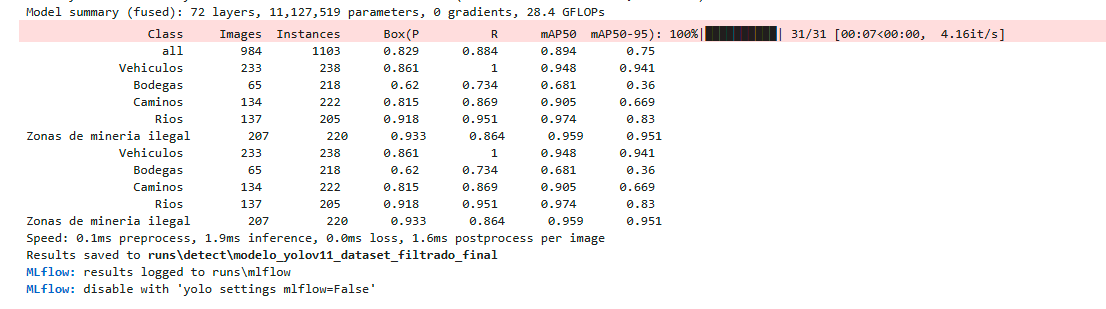

### Modelo Completo - 150 Epocas

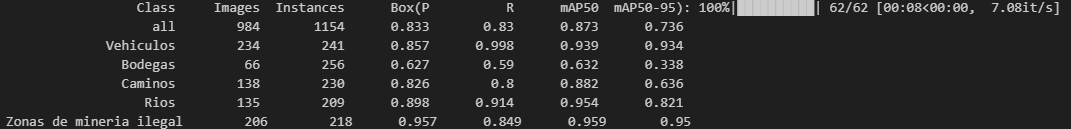

### Modelo Filtrado con preprocesamiento - 150 Epocas

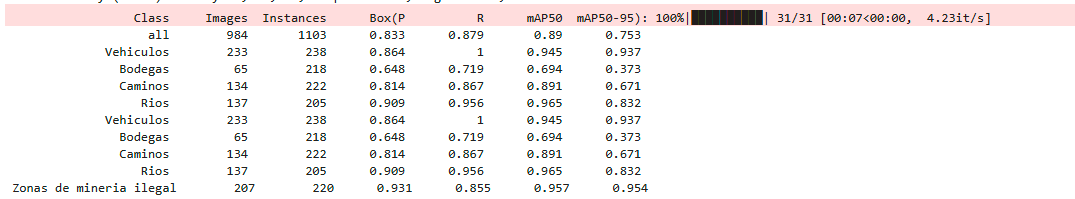

### Modelo completo con preprocesamiento - 150 Epocas

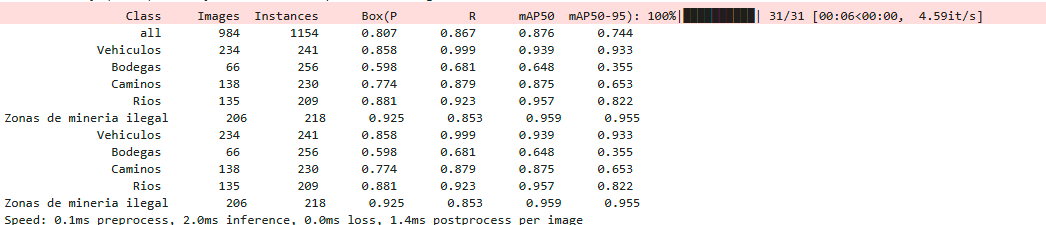

# Finetuning

In [29]:
import os


def finetune_yolo_model(
    model_path,
    dataset_yaml_path,
    save_dir,
    run_name,
    lr=0.0005,
    epochs=15,
    imgsz=640,
    batch=16,
):
    """
    Fine-tunes only the detection head of a YOLOv8 model (freezing the backbone).
    
    Args:
        model_path (str): Path to the pre-trained YOLO model (.pt).
        dataset_yaml_path (str): Path to the dataset YAML file.
        save_dir (str): Base directory to save the run.
        run_name (str): Name of the training run.
        lr (float): Initial learning rate (suggested: 1e-4 to 1e-3).
        epochs (int): Number of fine-tuning epochs.
        imgsz (int): Image size for training.
        batch (int): Batch size.
        device (int or str): Device to use ('cpu', 0, 1, etc.).
    """
    assert os.path.exists(model_path), f"Modelo no encontrado: {model_path}"
    assert os.path.exists(dataset_yaml_path), f"YAML no encontrado: {dataset_yaml_path}"
    
    model = YOLO(model_path)

    model.train(
        data=dataset_yaml_path,
        epochs=epochs,
        patience=3,
        lr0=lr,
        imgsz=imgsz,
        batch=batch,
        project=save_dir,
        name=run_name,
        optimizer="Adam",          
        cos_lr=True,             
        verbose=True,
        seed=42,
        deterministic=True,
        single_cls=False,
        rect=False,
        freeze=10                
    )


## Finetuning - completo

In [30]:
finetune_yolo_model(
    model_path="final_model_modelo_yolov11_dataset_completo_final_v2/best_model_final.pt",
    dataset_yaml_path="modelo_yolov11_dataset_completo/dataset.yaml",
    save_dir="finetuning_resultados",
    run_name="finetuning_complete_dataset_v2",
)

New https://pypi.org/project/ultralytics/8.3.141 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=final_model_modelo_yolov11_dataset_completo_final_v2/best_model_final.pt, data=modelo_yolov11_dataset_completo/dataset.yaml, epochs=15, time=None, patience=3, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=finetuning_resultados, name=finetuning_complete_dataset_v2, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_completo\train\labels.cache... 8233 images, 2034 backgrounds, 0 corrupt: 100%|██████████| 8233/8233 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 840.7371.0 MB/s, size: 284.4 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_completo\val\labels.cache... 984 images, 240 backgrounds, 0 corrupt: 100%|██████████| 984/984 [00:00<?, ?it/s]


Plotting labels to finetuning_resultados\finetuning_complete_dataset_v2\labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/21 08:45:49 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(d8e2c0219d5b4e108c7e3226d26a264c) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to finetuning_resultados\finetuning_complete_dataset_v2
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      1.97G     0.6282     0.5286      0.939         14        640: 100%|██████████| 515/515 [01:46<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.46it/s]

                   all        984       1154      0.812      0.836       0.87       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      2.16G     0.6179     0.5191     0.9378         27        640: 100%|██████████| 515/515 [01:37<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  3.89it/s]

                   all        984       1154      0.792      0.851      0.875       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      2.16G     0.6279     0.5356     0.9478         35        640: 100%|██████████| 515/515 [01:37<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  3.89it/s]

                   all        984       1154      0.842       0.82      0.874      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      2.16G     0.6327     0.5321     0.9488         17        640: 100%|██████████| 515/515 [01:36<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.36it/s]

                   all        984       1154      0.817      0.823      0.865      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      2.16G      0.622     0.5225     0.9448         34        640: 100%|██████████| 515/515 [01:37<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.24it/s]

                   all        984       1154      0.838      0.816      0.866      0.716
EarlyStopping: Training stopped early as no improvement observed in last 3 epochs. Best results observed at epoch 2, best model saved as best.pt.
To update EarlyStopping(patience=3) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



5 epochs completed in 0.149 hours.
Optimizer stripped from finetuning_resultados\finetuning_complete_dataset_v2\weights\last.pt, 22.5MB
Optimizer stripped from finetuning_resultados\finetuning_complete_dataset_v2\weights\best.pt, 22.5MB

Validating finetuning_resultados\finetuning_complete_dataset_v2\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.81it/s]


                   all        984       1154      0.792      0.851      0.875       0.72
             Vehiculos        234        241      0.855          1      0.947      0.929
               Bodegas         66        256      0.608      0.605      0.624      0.337
               Caminos        138        230      0.767      0.857      0.886      0.603
                  Rios        135        209      0.876      0.933      0.963      0.794
Zonas de mineria ilegal        206        218      0.853      0.862      0.956      0.939
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to finetuning_resultados\finetuning_complete_dataset_v2
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'


### Finetuning - Filtrado

In [31]:
finetune_yolo_model(
    model_path="final_model_modelo_yolov11_dataset_filtrado_final_v2/best_model_final.pt",
    dataset_yaml_path="modelo_yolov11_dataset_filtrado/dataset.yaml",
    save_dir="finetuning_resultados",
    run_name="finetuning_filtered_dataset_v2",
)

New https://pypi.org/project/ultralytics/8.3.141 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=final_model_modelo_yolov11_dataset_filtrado_final_v2/best_model_final.pt, data=modelo_yolov11_dataset_filtrado/dataset.yaml, epochs=15, time=None, patience=3, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=finetuning_resultados, name=finetuning_filtered_dataset_v2, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_filtrado\train\labels.cache... 8258 images, 2062 backgrounds, 0 corrupt: 100%|██████████| 8258/8258 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 20.07.2 MB/s, size: 327.3 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_filtrado\val\labels.cache... 984 images, 237 backgrounds, 0 corrupt: 100%|██████████| 984/984 [00:00<?, ?it/s]


Plotting labels to finetuning_resultados\finetuning_filtered_dataset_v2\labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/21 11:14:18 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(7dc9ad5b9e5f40cea5d3679be785e888) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to finetuning_resultados\finetuning_filtered_dataset_v2
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      1.72G     0.6437     0.5412     0.9505          2        640: 100%|██████████| 517/517 [01:36<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.55it/s]

                   all        984       1103      0.825       0.88      0.887       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15       1.9G     0.6366      0.531     0.9528          6        640: 100%|██████████| 517/517 [01:28<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.72it/s]

                   all        984       1103      0.822      0.876      0.889      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15       1.9G     0.6464     0.5426     0.9571          2        640: 100%|██████████| 517/517 [01:28<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.64it/s]

                   all        984       1103      0.817      0.884      0.891      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15       1.9G      0.641     0.5417      0.957          3        640: 100%|██████████| 517/517 [01:26<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.75it/s]

                   all        984       1103       0.83      0.859       0.89      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15       1.9G     0.6372      0.537     0.9532          7        640: 100%|██████████| 517/517 [01:27<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.69it/s]

                   all        984       1103      0.836      0.869      0.889       0.73


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15       1.9G     0.5257     0.4506     0.8962          1        640: 100%|██████████| 517/517 [01:23<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.78it/s]

                   all        984       1103      0.828      0.881      0.882      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15       1.9G     0.5113     0.4404     0.8906          1        640: 100%|██████████| 517/517 [01:24<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.73it/s]

                   all        984       1103       0.82      0.876      0.887      0.728
EarlyStopping: Training stopped early as no improvement observed in last 3 epochs. Best results observed at epoch 4, best model saved as best.pt.
To update EarlyStopping(patience=3) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



7 epochs completed in 0.194 hours.
Optimizer stripped from finetuning_resultados\finetuning_filtered_dataset_v2\weights\last.pt, 22.5MB
Optimizer stripped from finetuning_resultados\finetuning_filtered_dataset_v2\weights\best.pt, 22.5MB

Validating finetuning_resultados\finetuning_filtered_dataset_v2\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.34it/s]


                   all        984       1103       0.83      0.859       0.89      0.731
             Vehiculos        233        238      0.863          1      0.947      0.929
               Bodegas         65        218      0.655      0.678      0.691      0.357
               Caminos        134        222      0.811      0.824      0.888      0.647
                  Rios        137        205      0.907      0.937      0.969       0.79
Zonas de mineria ilegal        207        220      0.915      0.855      0.954      0.934
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to finetuning_resultados\finetuning_filtered_dataset_v2
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'


### Finetuning - Completo con preprocesamiento

In [32]:
finetune_yolo_model(
    model_path="final_model_preprocesamiento_modelo_yolov11_dataset_completo_preprocesado_v2/best_model_final.pt",
    dataset_yaml_path="preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/dataset.yaml",
    save_dir="finetuning_resultados",
    run_name="finetuning_complete_preprocessed_dataset_v2",
)

New https://pypi.org/project/ultralytics/8.3.141 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=final_model_preprocesamiento_modelo_yolov11_dataset_completo_preprocesado_v2/best_model_final.pt, data=preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/dataset.yaml, epochs=15, time=None, patience=3, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=finetuning_resultados, name=finetuning_complete_preprocessed_dataset_v2, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, pl

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_completo_preprocesado\train\labels.cache... 8233 images, 2034 backgrounds, 0 corrupt: 100%|██████████| 8233/8233 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.60.1 ms, read: 29.66.3 MB/s, size: 424.0 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_completo_preprocesado\val\labels.cache... 984 images, 240 backgrounds, 0 corrupt: 100%|██████████| 984/984 [00:00<?, ?it/s]


Plotting labels to finetuning_resultados\finetuning_complete_preprocessed_dataset_v2\labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/21 11:27:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(c17633d984294d0db2a78eecd35b24f0) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to finetuning_resultados\finetuning_complete_preprocessed_dataset_v2
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      1.62G     0.6071     0.5202     0.9303         14        640: 100%|██████████| 515/515 [01:34<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.87it/s]


                   all        984       1154      0.803      0.857      0.872      0.719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      1.81G     0.6003      0.516     0.9308         27        640: 100%|██████████| 515/515 [01:28<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.18it/s]

                   all        984       1154      0.827      0.844      0.878       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      1.81G     0.6139     0.5217     0.9421         35        640: 100%|██████████| 515/515 [01:36<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.15it/s]

                   all        984       1154      0.816      0.862      0.882      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      1.81G     0.6151     0.5238     0.9438         17        640: 100%|██████████| 515/515 [01:30<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.28it/s]

                   all        984       1154      0.821      0.834      0.878      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      1.81G     0.6081     0.5147     0.9389         34        640: 100%|██████████| 515/515 [01:25<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.72it/s]

                   all        984       1154      0.832       0.83      0.868      0.721
EarlyStopping: Training stopped early as no improvement observed in last 3 epochs. Best results observed at epoch 2, best model saved as best.pt.
To update EarlyStopping(patience=3) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



5 epochs completed in 0.138 hours.
Optimizer stripped from finetuning_resultados\finetuning_complete_preprocessed_dataset_v2\weights\last.pt, 22.5MB
Optimizer stripped from finetuning_resultados\finetuning_complete_preprocessed_dataset_v2\weights\best.pt, 22.5MB

Validating finetuning_resultados\finetuning_complete_preprocessed_dataset_v2\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.46it/s]


                   all        984       1154      0.825      0.845      0.879       0.73
             Vehiculos        234        241       0.86          1      0.937      0.918
               Bodegas         66        256      0.625      0.612      0.636       0.35
               Caminos        138        230        0.8      0.851      0.899      0.643
                  Rios        135        209       0.91      0.919      0.965      0.802
Zonas de mineria ilegal        206        218      0.931      0.844      0.956      0.939
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to finetuning_resultados\finetuning_complete_preprocessed_dataset_v2
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'


### Finetuning - Filtrado con preprocesamiento

In [33]:
finetune_yolo_model(
    model_path="final_model_preprocesamiento_modelo_yolov11_dataset_filtrado_preprocesado_v2/best_model_final.pt",
    dataset_yaml_path="preprocesamiento/modelo_yolov11_dataset_filtrado_preprocesado/dataset.yaml",
    save_dir="finetuning_resultados",
    run_name="finetuning_filtered_preprocessed_dataset_v2",
)

New https://pypi.org/project/ultralytics/8.3.141 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=final_model_preprocesamiento_modelo_yolov11_dataset_filtrado_preprocesado_v2/best_model_final.pt, data=preprocesamiento/modelo_yolov11_dataset_filtrado_preprocesado/dataset.yaml, epochs=15, time=None, patience=3, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=finetuning_resultados, name=finetuning_filtered_preprocessed_dataset_v2, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, pl

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado\train\labels.cache... 8258 images, 2062 backgrounds, 0 corrupt: 100%|██████████| 8258/8258 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.70.2 ms, read: 36.28.7 MB/s, size: 452.5 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado\val\labels.cache... 984 images, 237 backgrounds, 0 corrupt: 100%|██████████| 984/984 [00:00<?, ?it/s]


Plotting labels to finetuning_resultados\finetuning_filtered_preprocessed_dataset_v2\labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/21 11:37:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(e3c531893b9f4df69b42f83bd4cf237a) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to finetuning_resultados\finetuning_filtered_preprocessed_dataset_v2
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      1.68G     0.6238     0.5264     0.9404          2        640: 100%|██████████| 517/517 [01:36<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  3.98it/s]

                   all        984       1103      0.835       0.87      0.881      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      1.87G     0.6147     0.5194     0.9424          6        640: 100%|██████████| 517/517 [01:42<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.55it/s]

                   all        984       1103      0.839       0.88      0.892      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      1.87G     0.6222     0.5288     0.9473          2        640: 100%|██████████| 517/517 [01:29<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.53it/s]

                   all        984       1103      0.821      0.876      0.873      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      1.87G     0.6255     0.5331      0.951          3        640: 100%|██████████| 517/517 [01:28<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]

                   all        984       1103      0.848      0.838      0.883      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      1.87G      0.614     0.5258     0.9441          7        640: 100%|██████████| 517/517 [01:28<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.53it/s]

                   all        984       1103      0.844      0.848      0.874      0.724
EarlyStopping: Training stopped early as no improvement observed in last 3 epochs. Best results observed at epoch 2, best model saved as best.pt.
To update EarlyStopping(patience=3) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



5 epochs completed in 0.140 hours.
Optimizer stripped from finetuning_resultados\finetuning_filtered_preprocessed_dataset_v2\weights\last.pt, 22.5MB
Optimizer stripped from finetuning_resultados\finetuning_filtered_preprocessed_dataset_v2\weights\best.pt, 22.5MB

Validating finetuning_resultados\finetuning_filtered_preprocessed_dataset_v2\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.05it/s]


                   all        984       1103       0.84      0.878      0.892      0.739
             Vehiculos        233        238      0.867          1      0.949      0.931
               Bodegas         65        218      0.656       0.71      0.695      0.353
               Caminos        134        222      0.812       0.86      0.879      0.653
                  Rios        137        205        0.9      0.961      0.976      0.814
Zonas de mineria ilegal        207        220      0.964      0.858      0.959      0.944
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to finetuning_resultados\finetuning_filtered_preprocessed_dataset_v2
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'


# Resultados Finetuning

## Filtrado

### Preprocesamiento

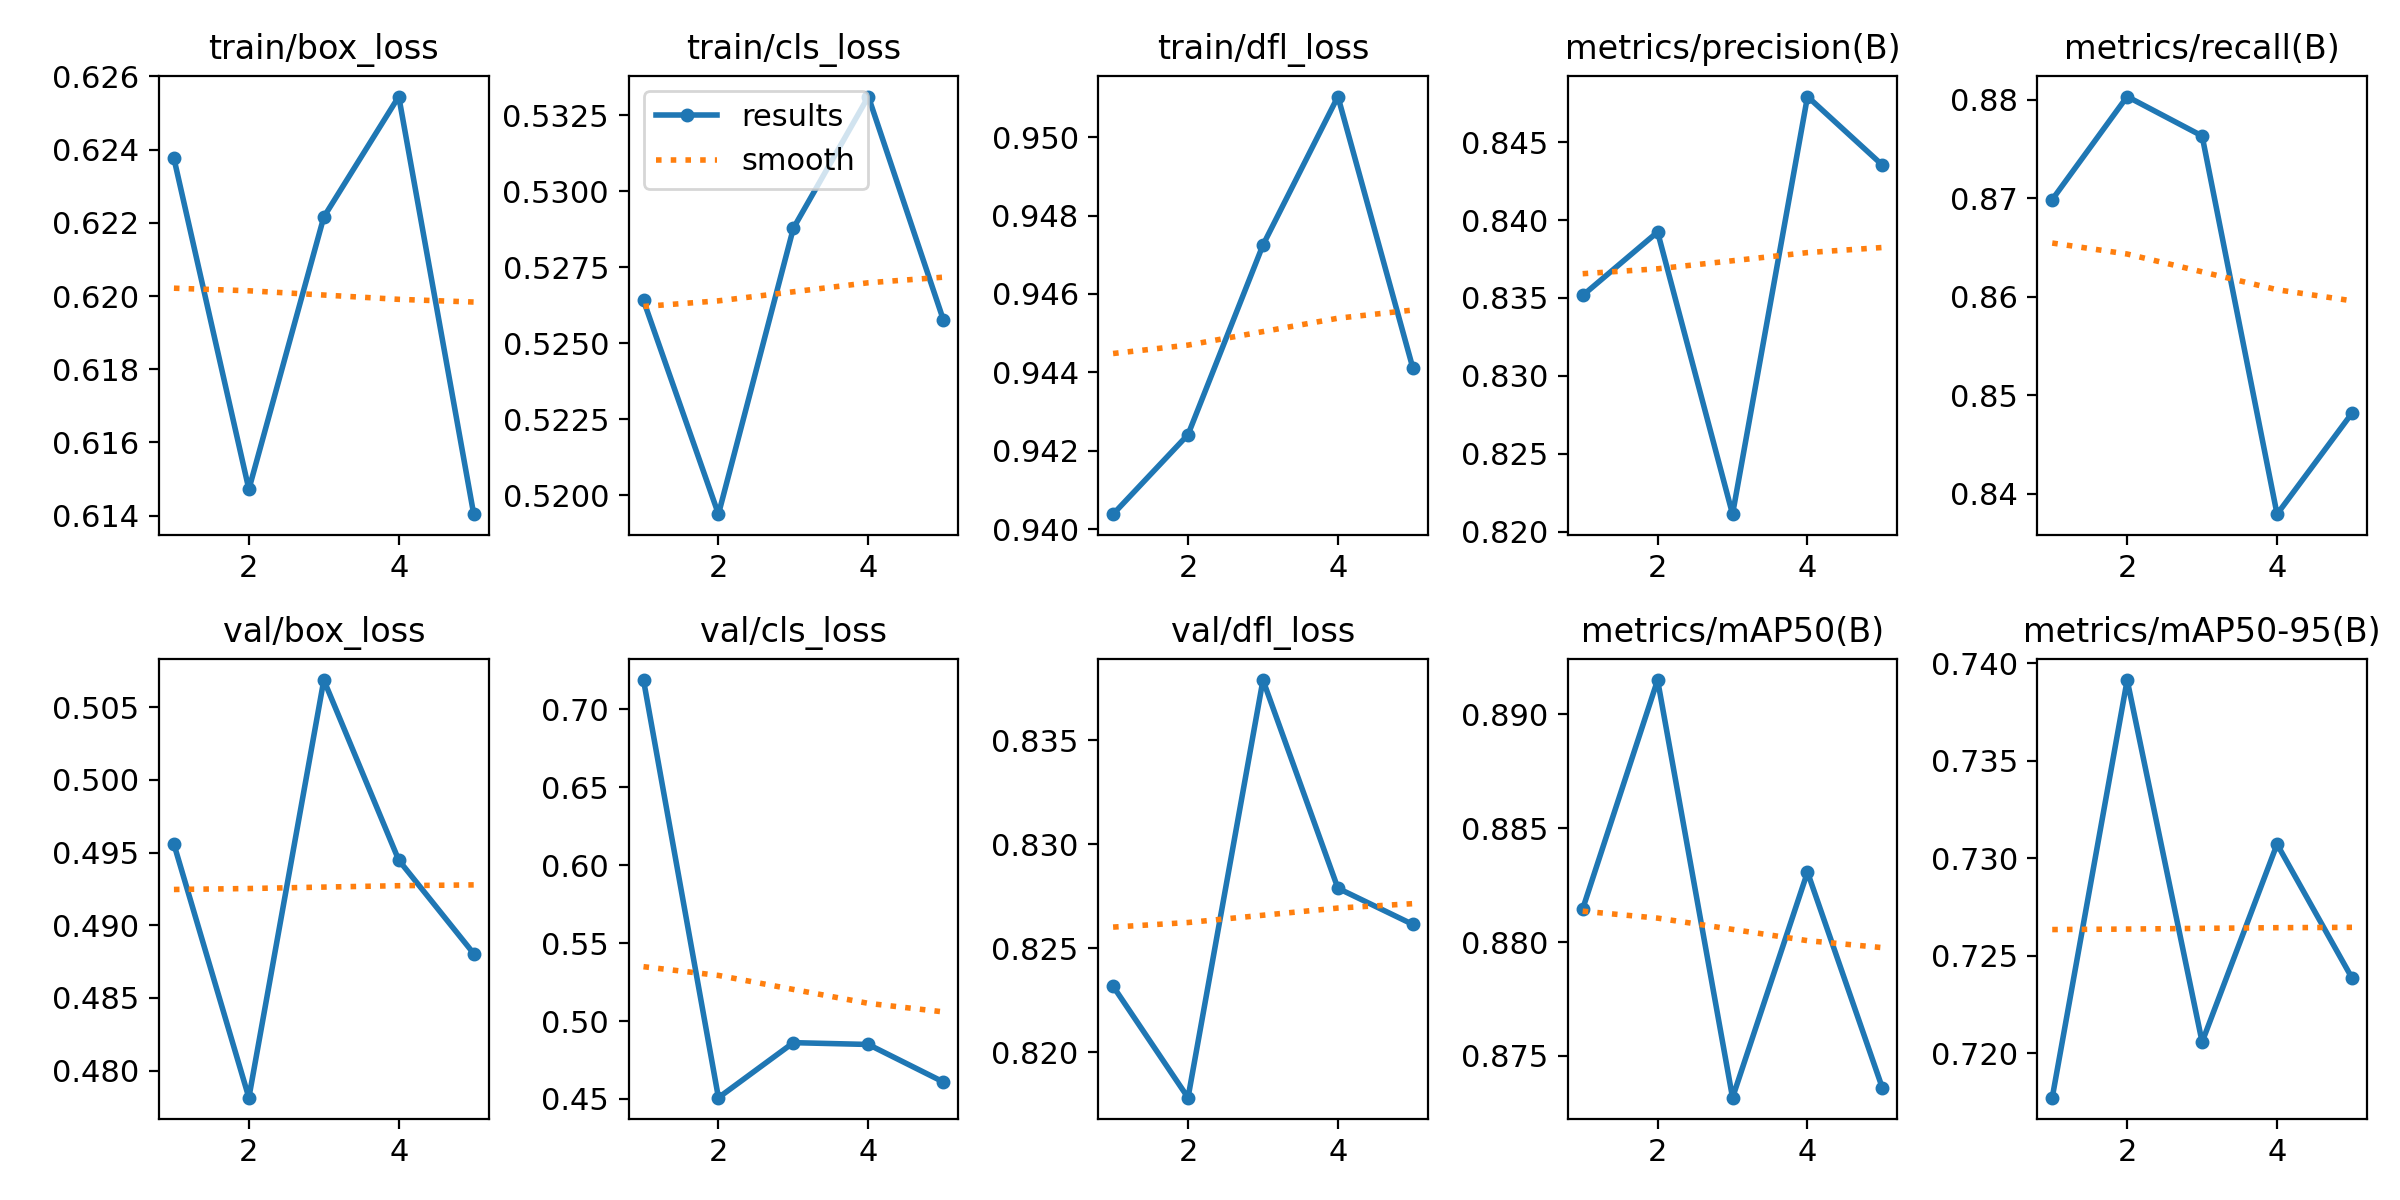

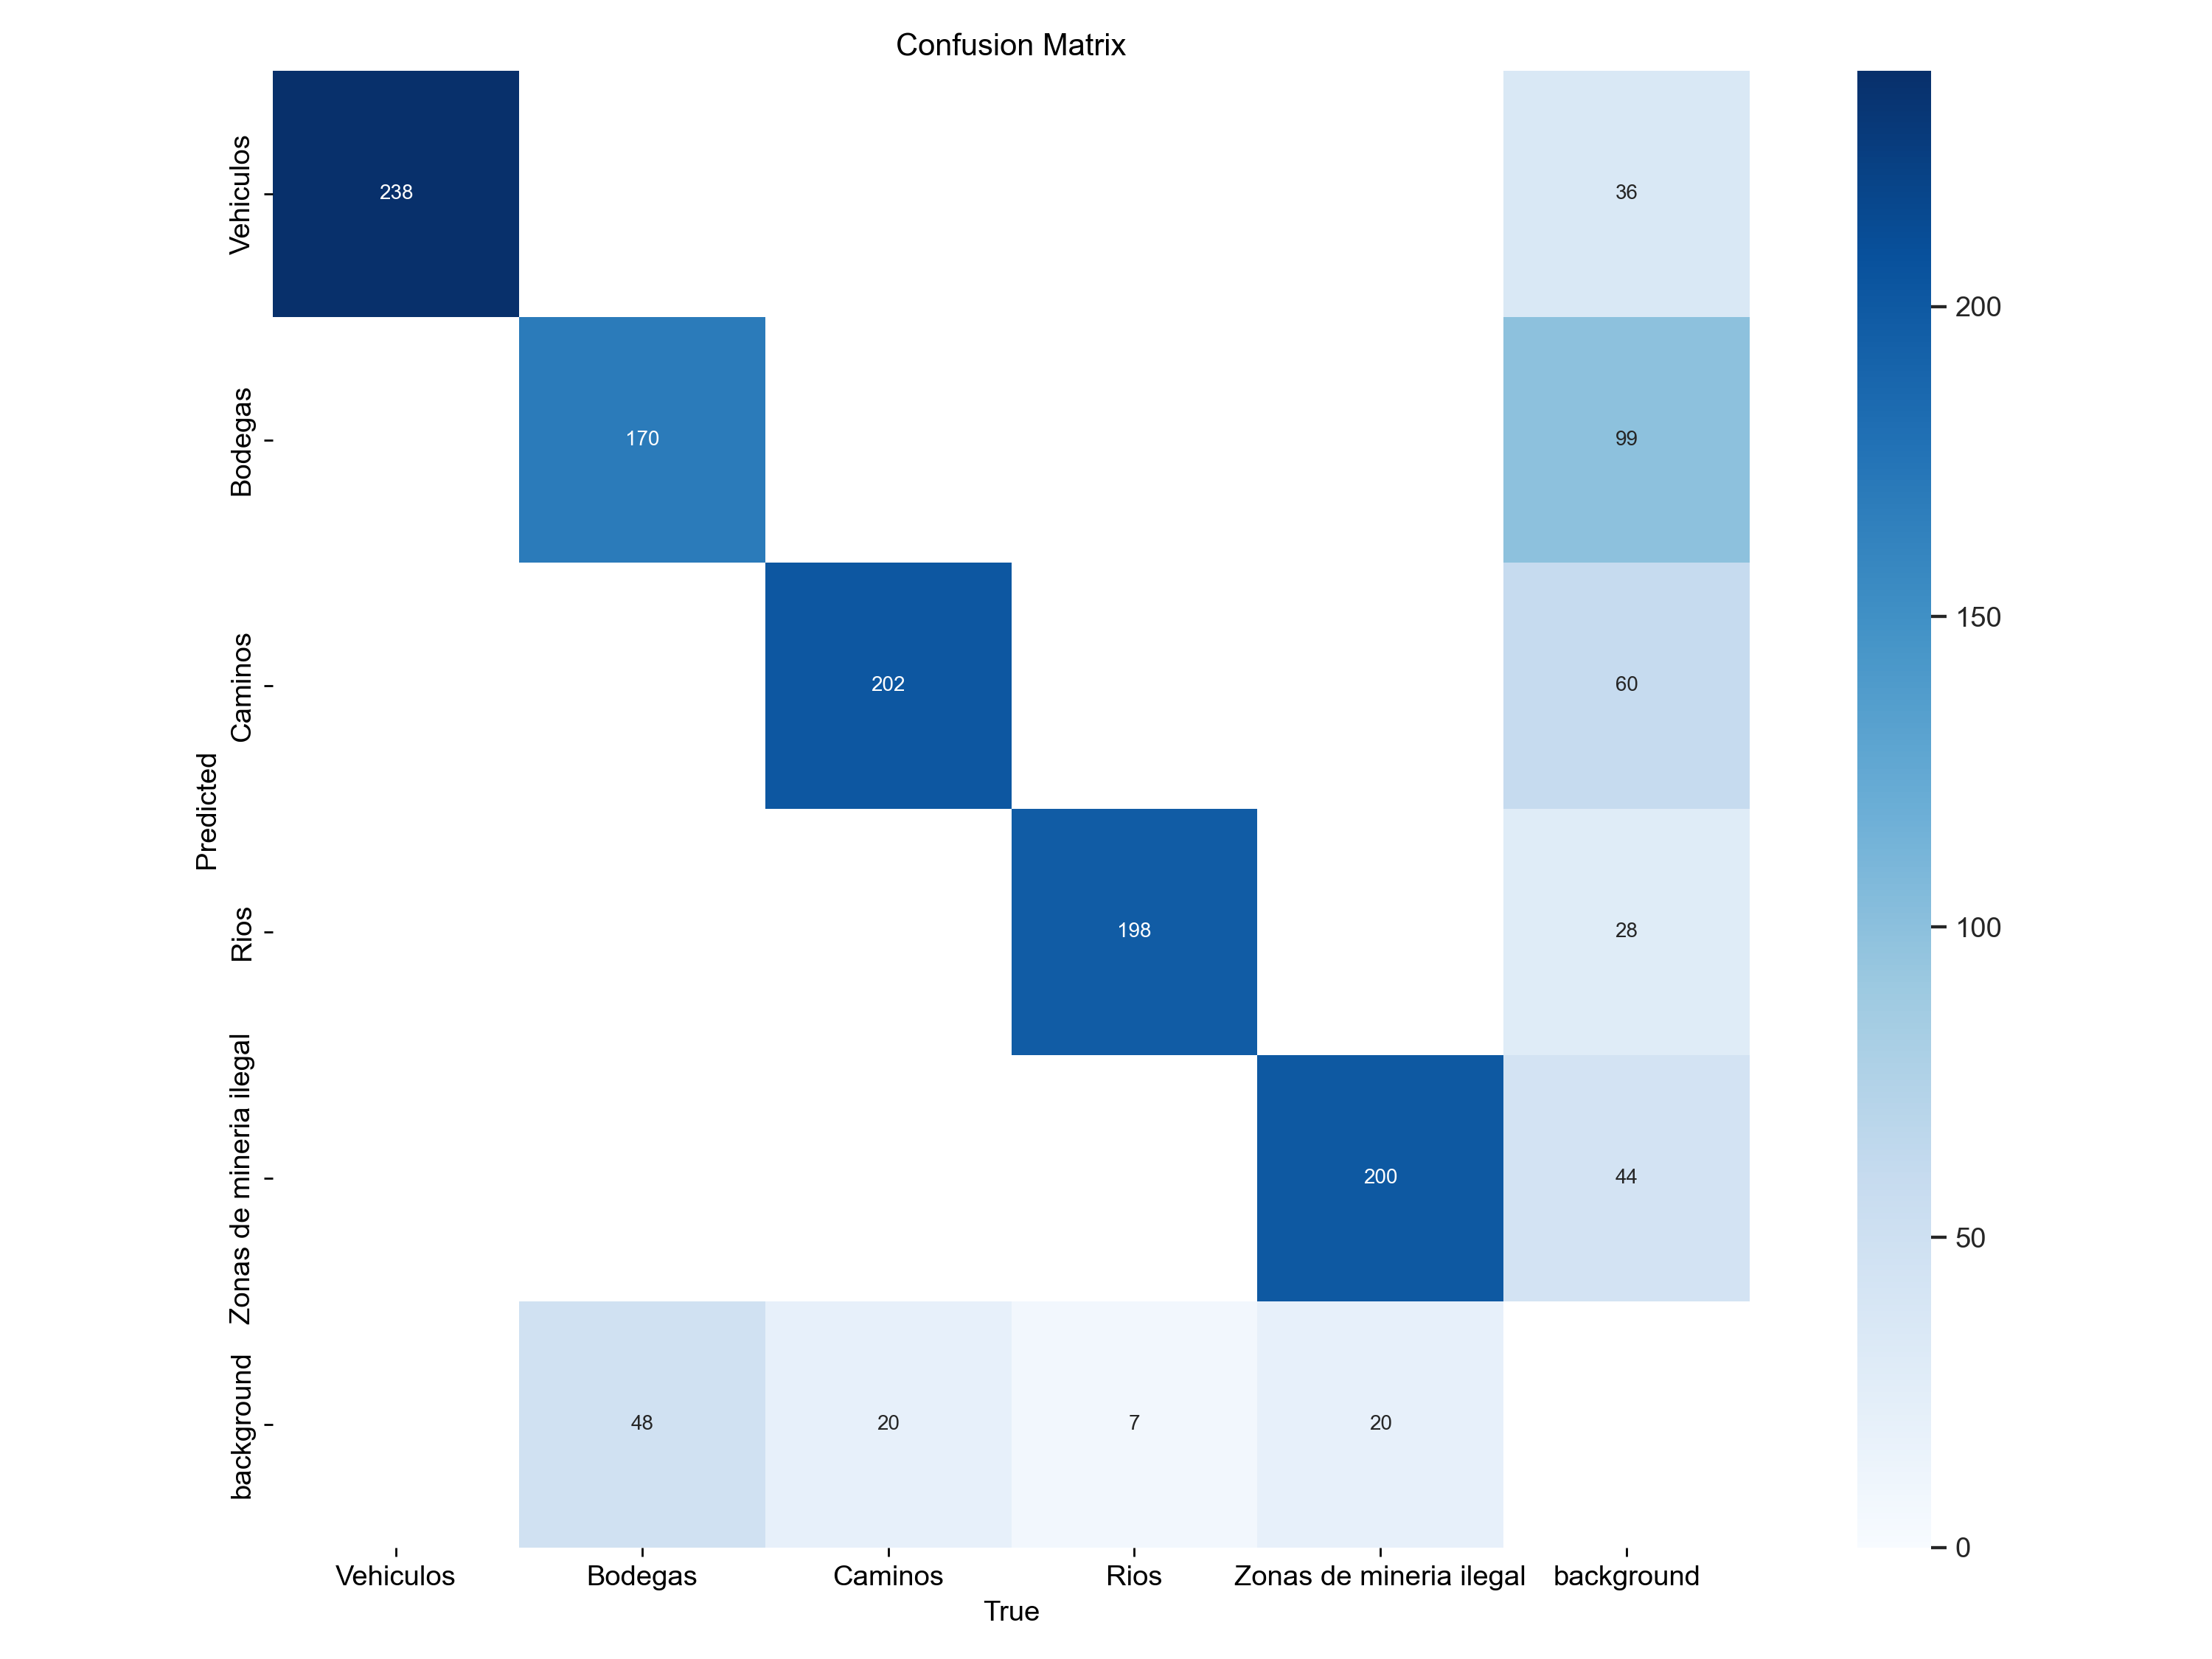

In [34]:
from PIL import Image as PImage
display(PImage.open('finetuning_resultados/finetuning_filtered_preprocessed_dataset_v2/results.png'))

display(PImage.open('finetuning_resultados/finetuning_filtered_preprocessed_dataset_v2/confusion_matrix.png'))

### Sin - Preprocesamiento

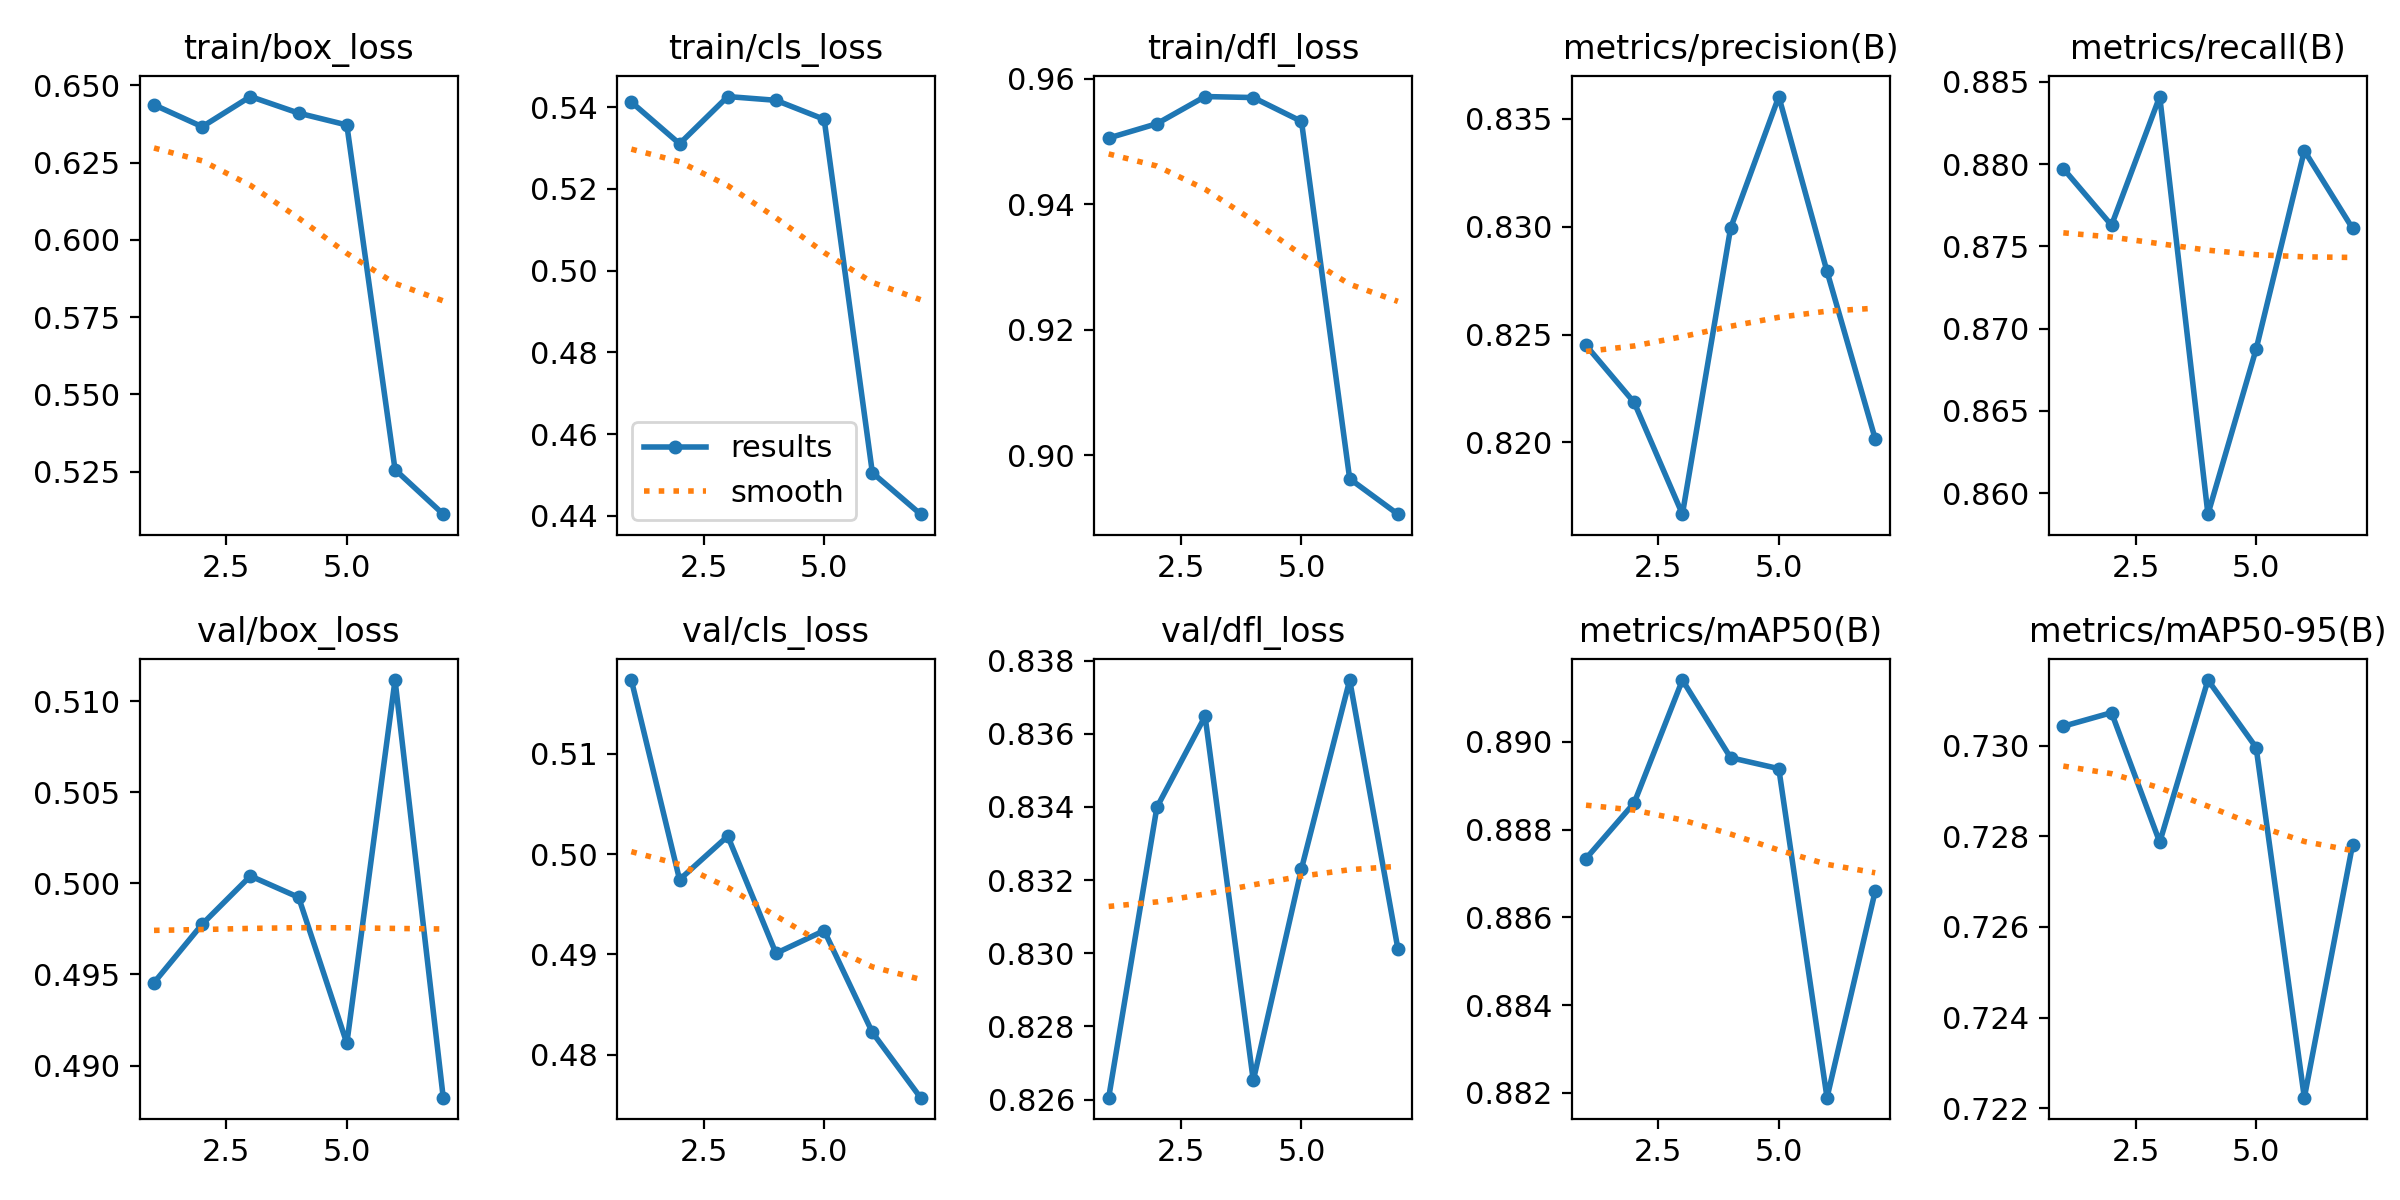

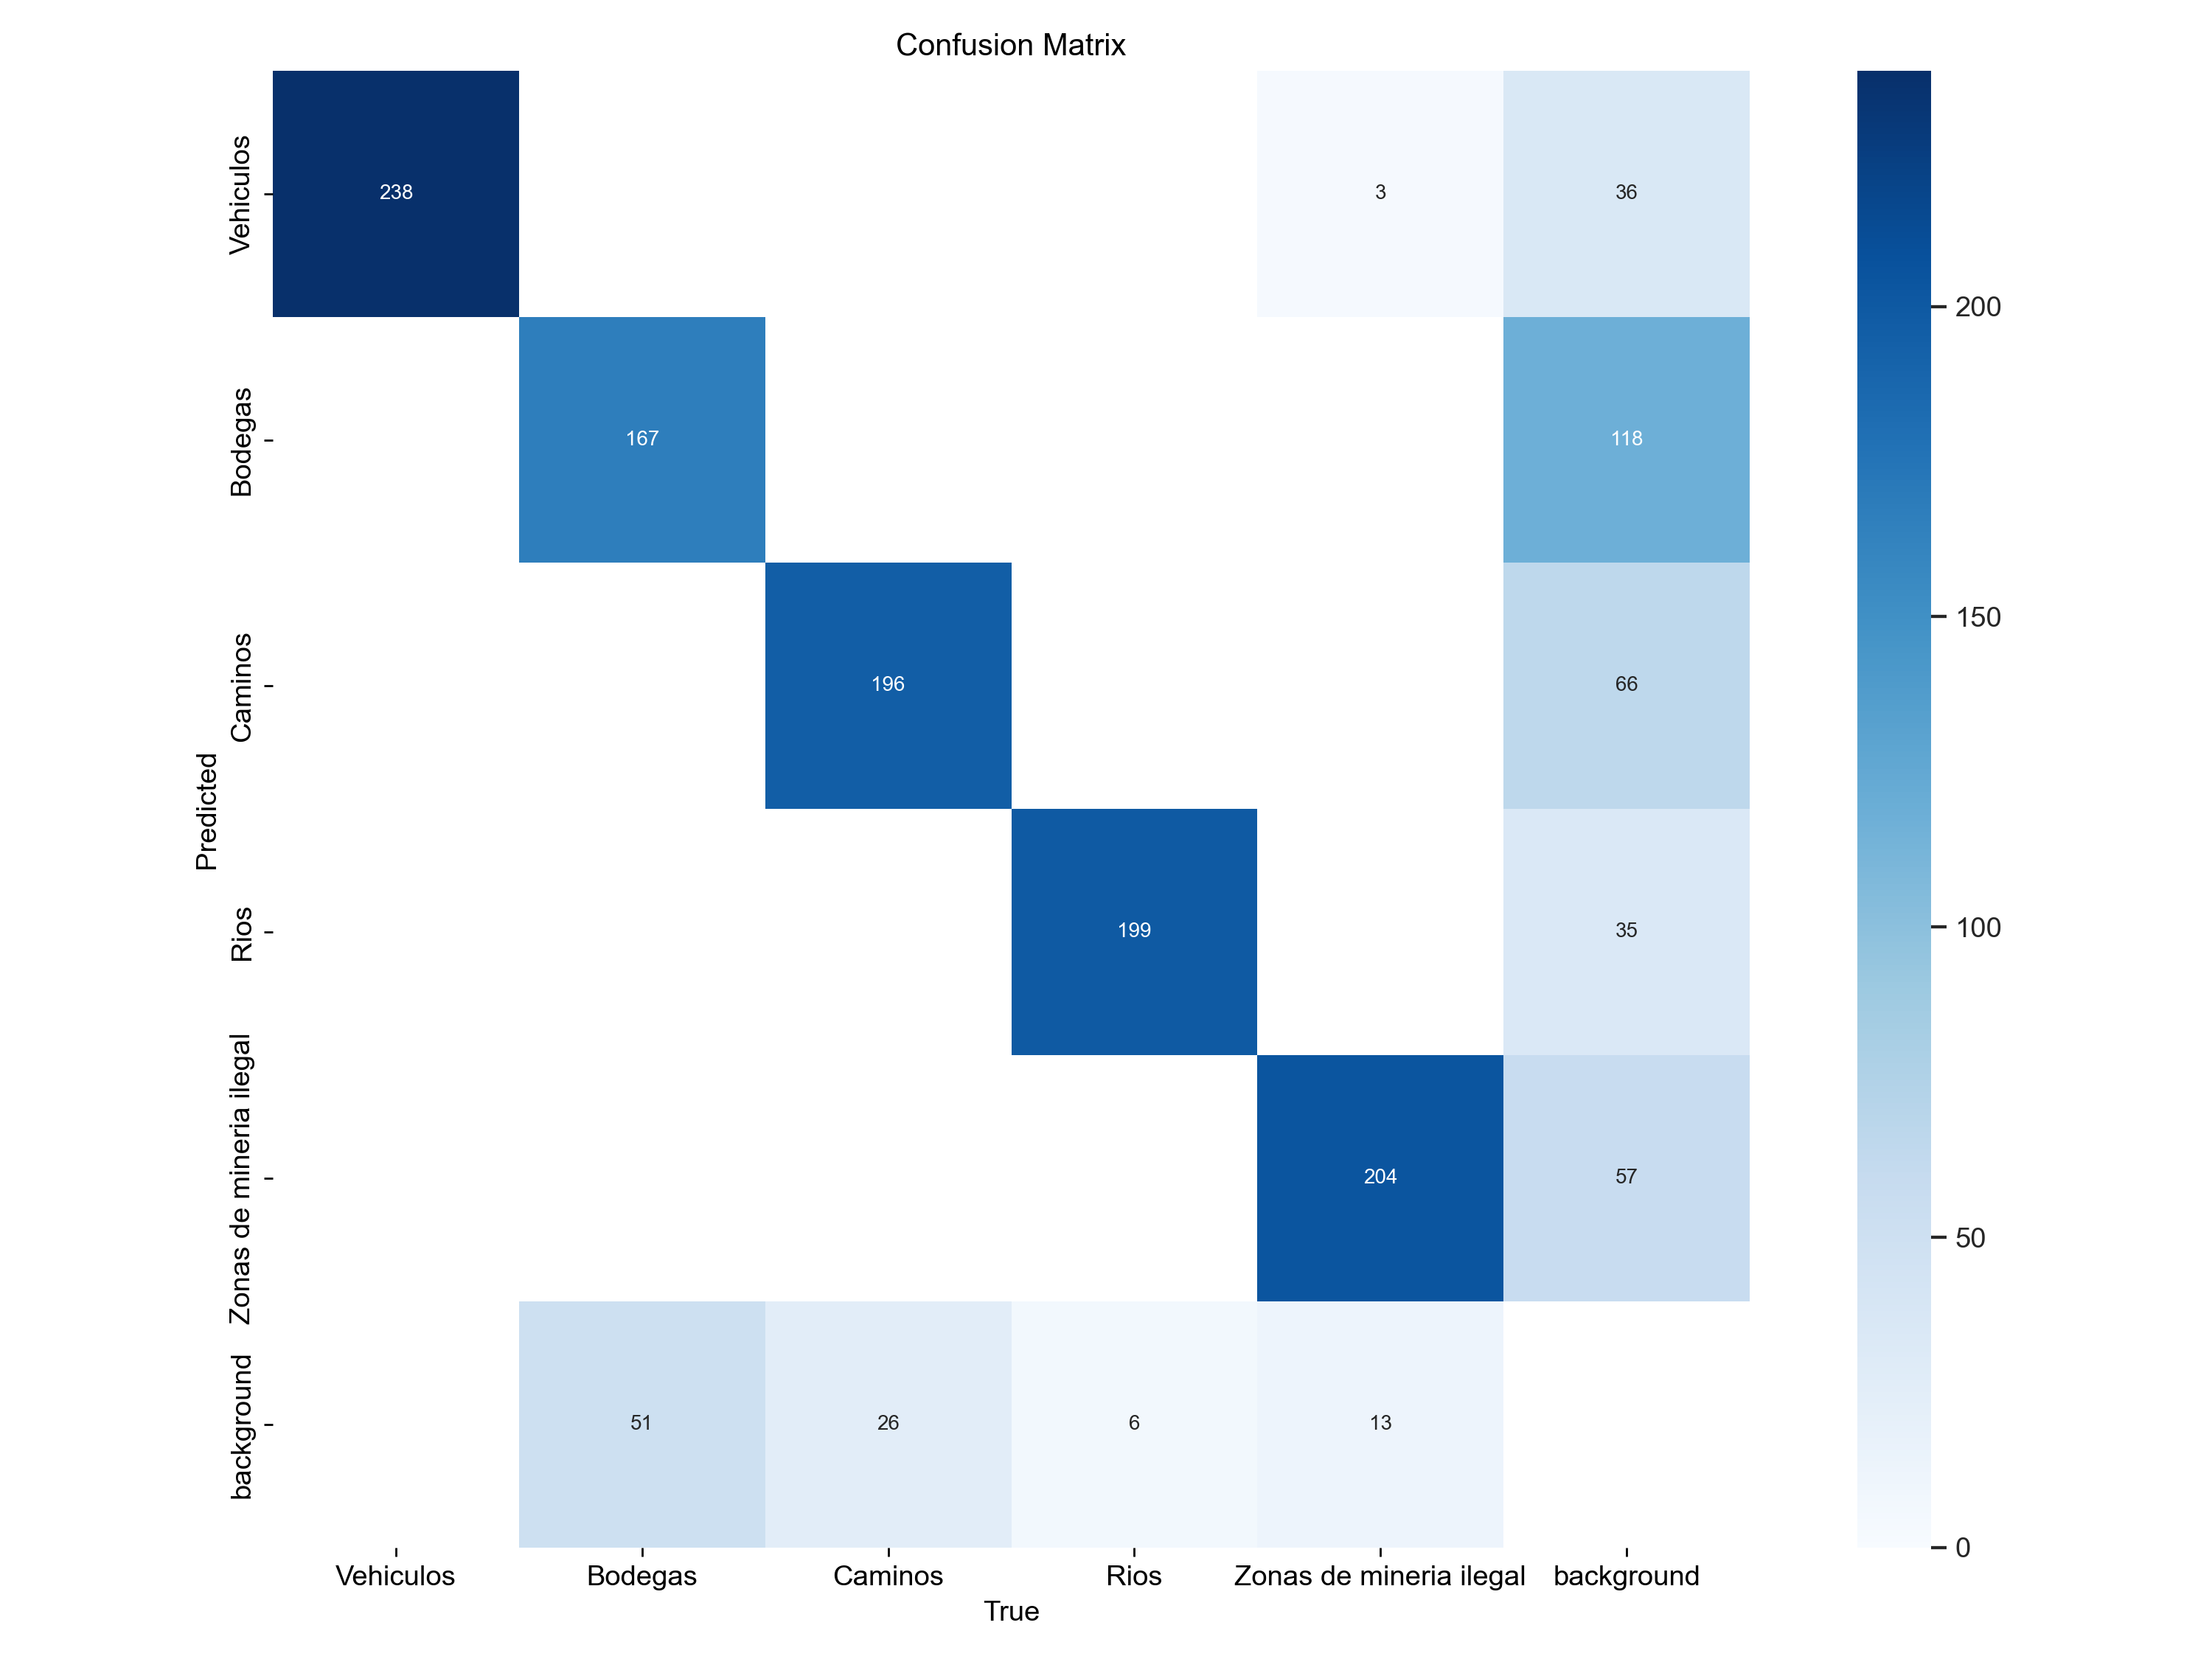

In [35]:
from PIL import Image as PImage
display(PImage.open('finetuning_resultados/finetuning_filtered_dataset_v2/results.png'))

display(PImage.open('finetuning_resultados/finetuning_filtered_dataset_v2/confusion_matrix.png'))

## Completo

### Preprocesamiento

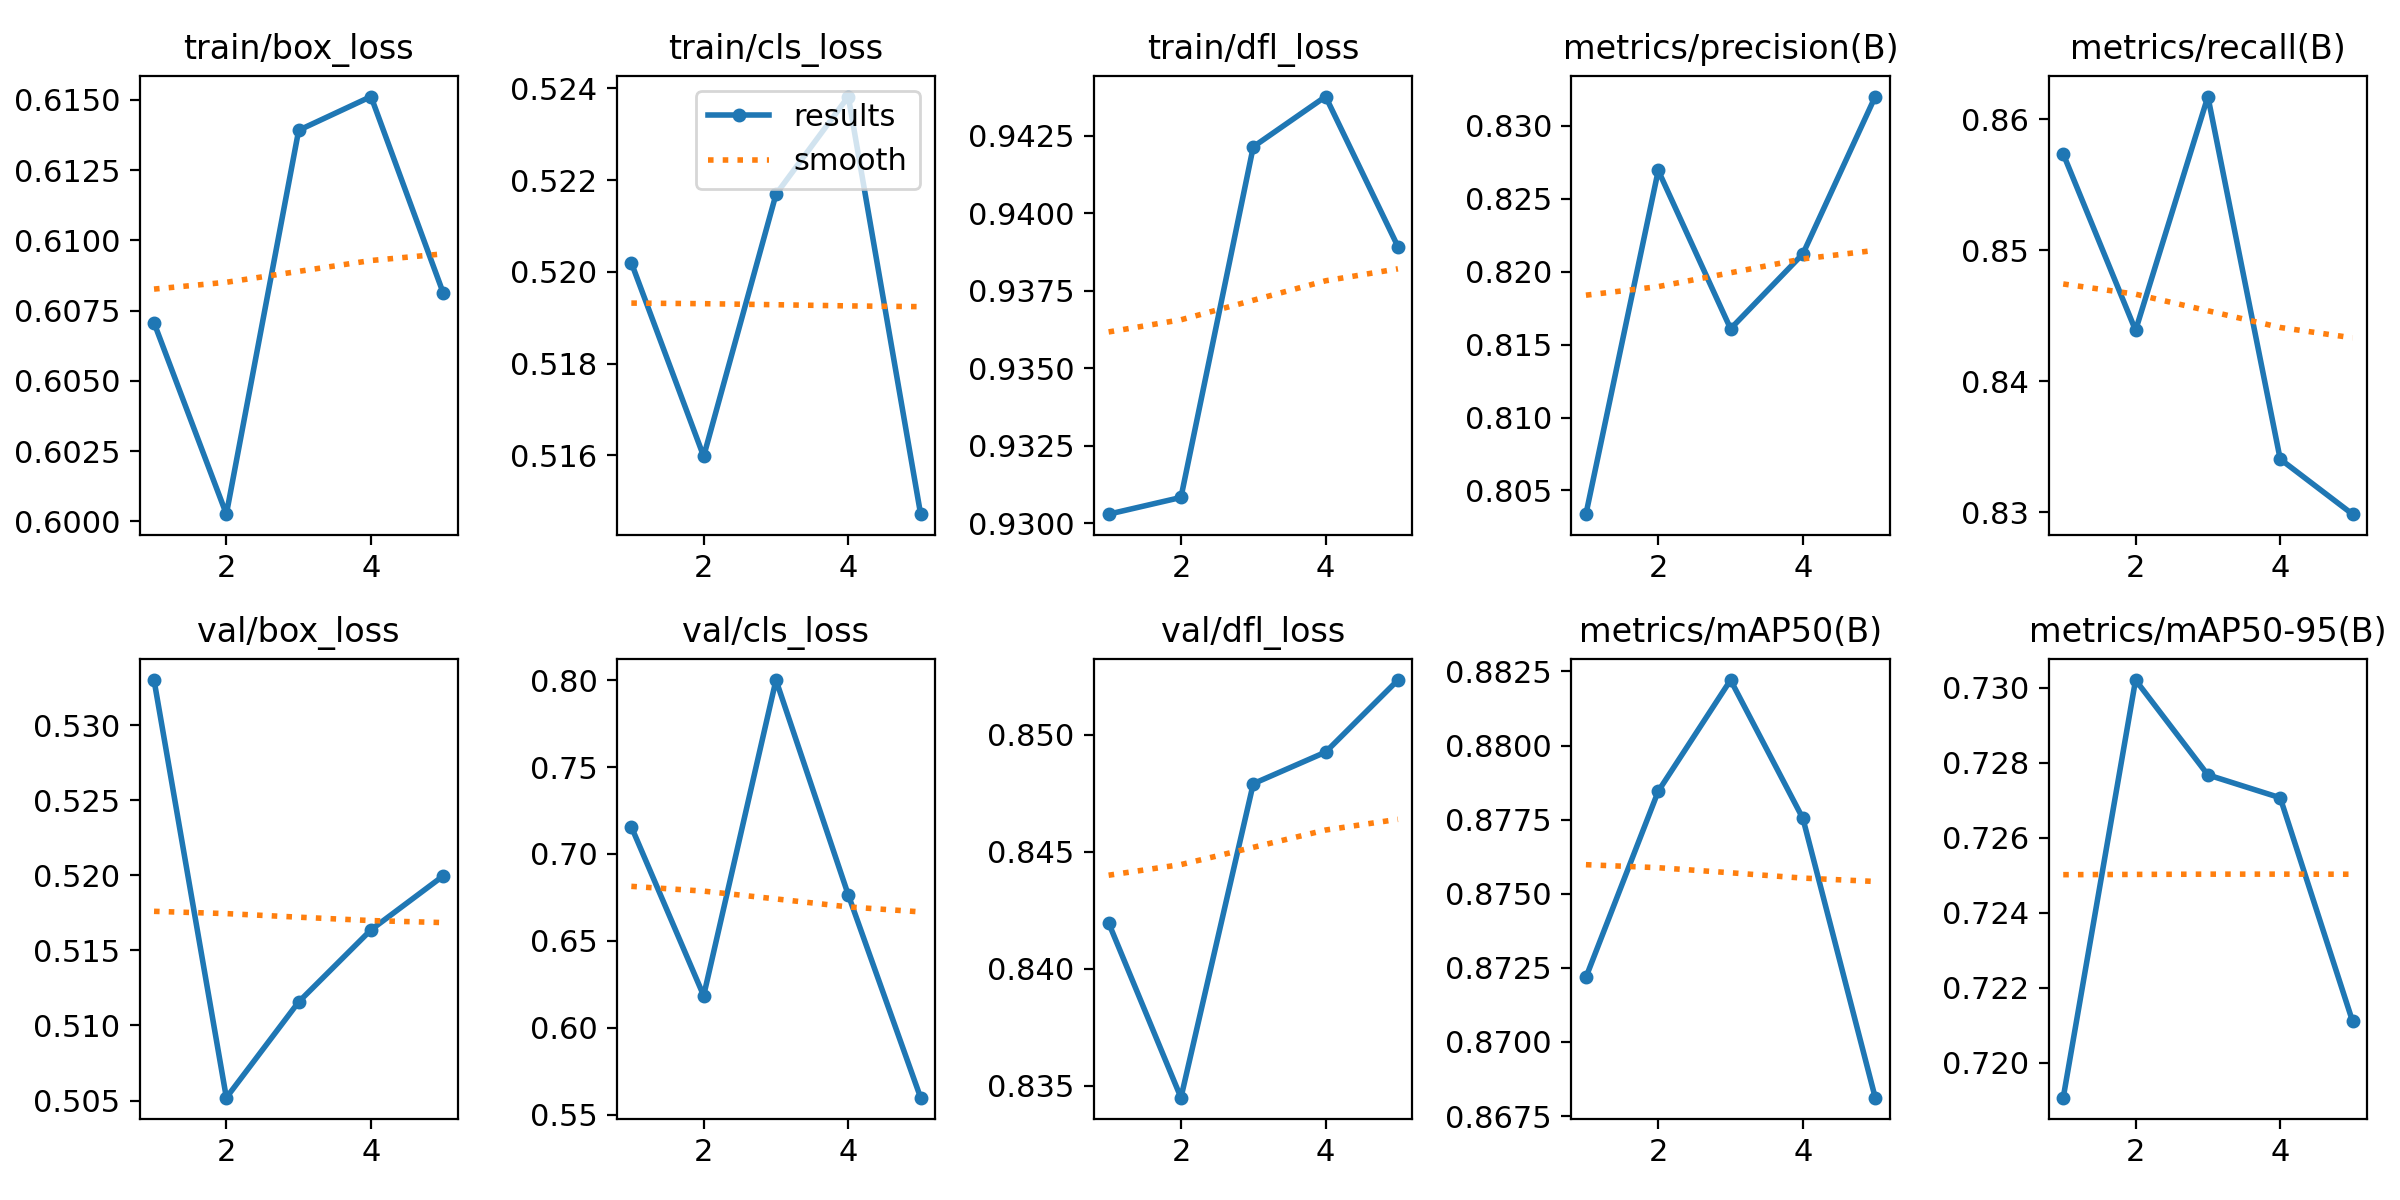

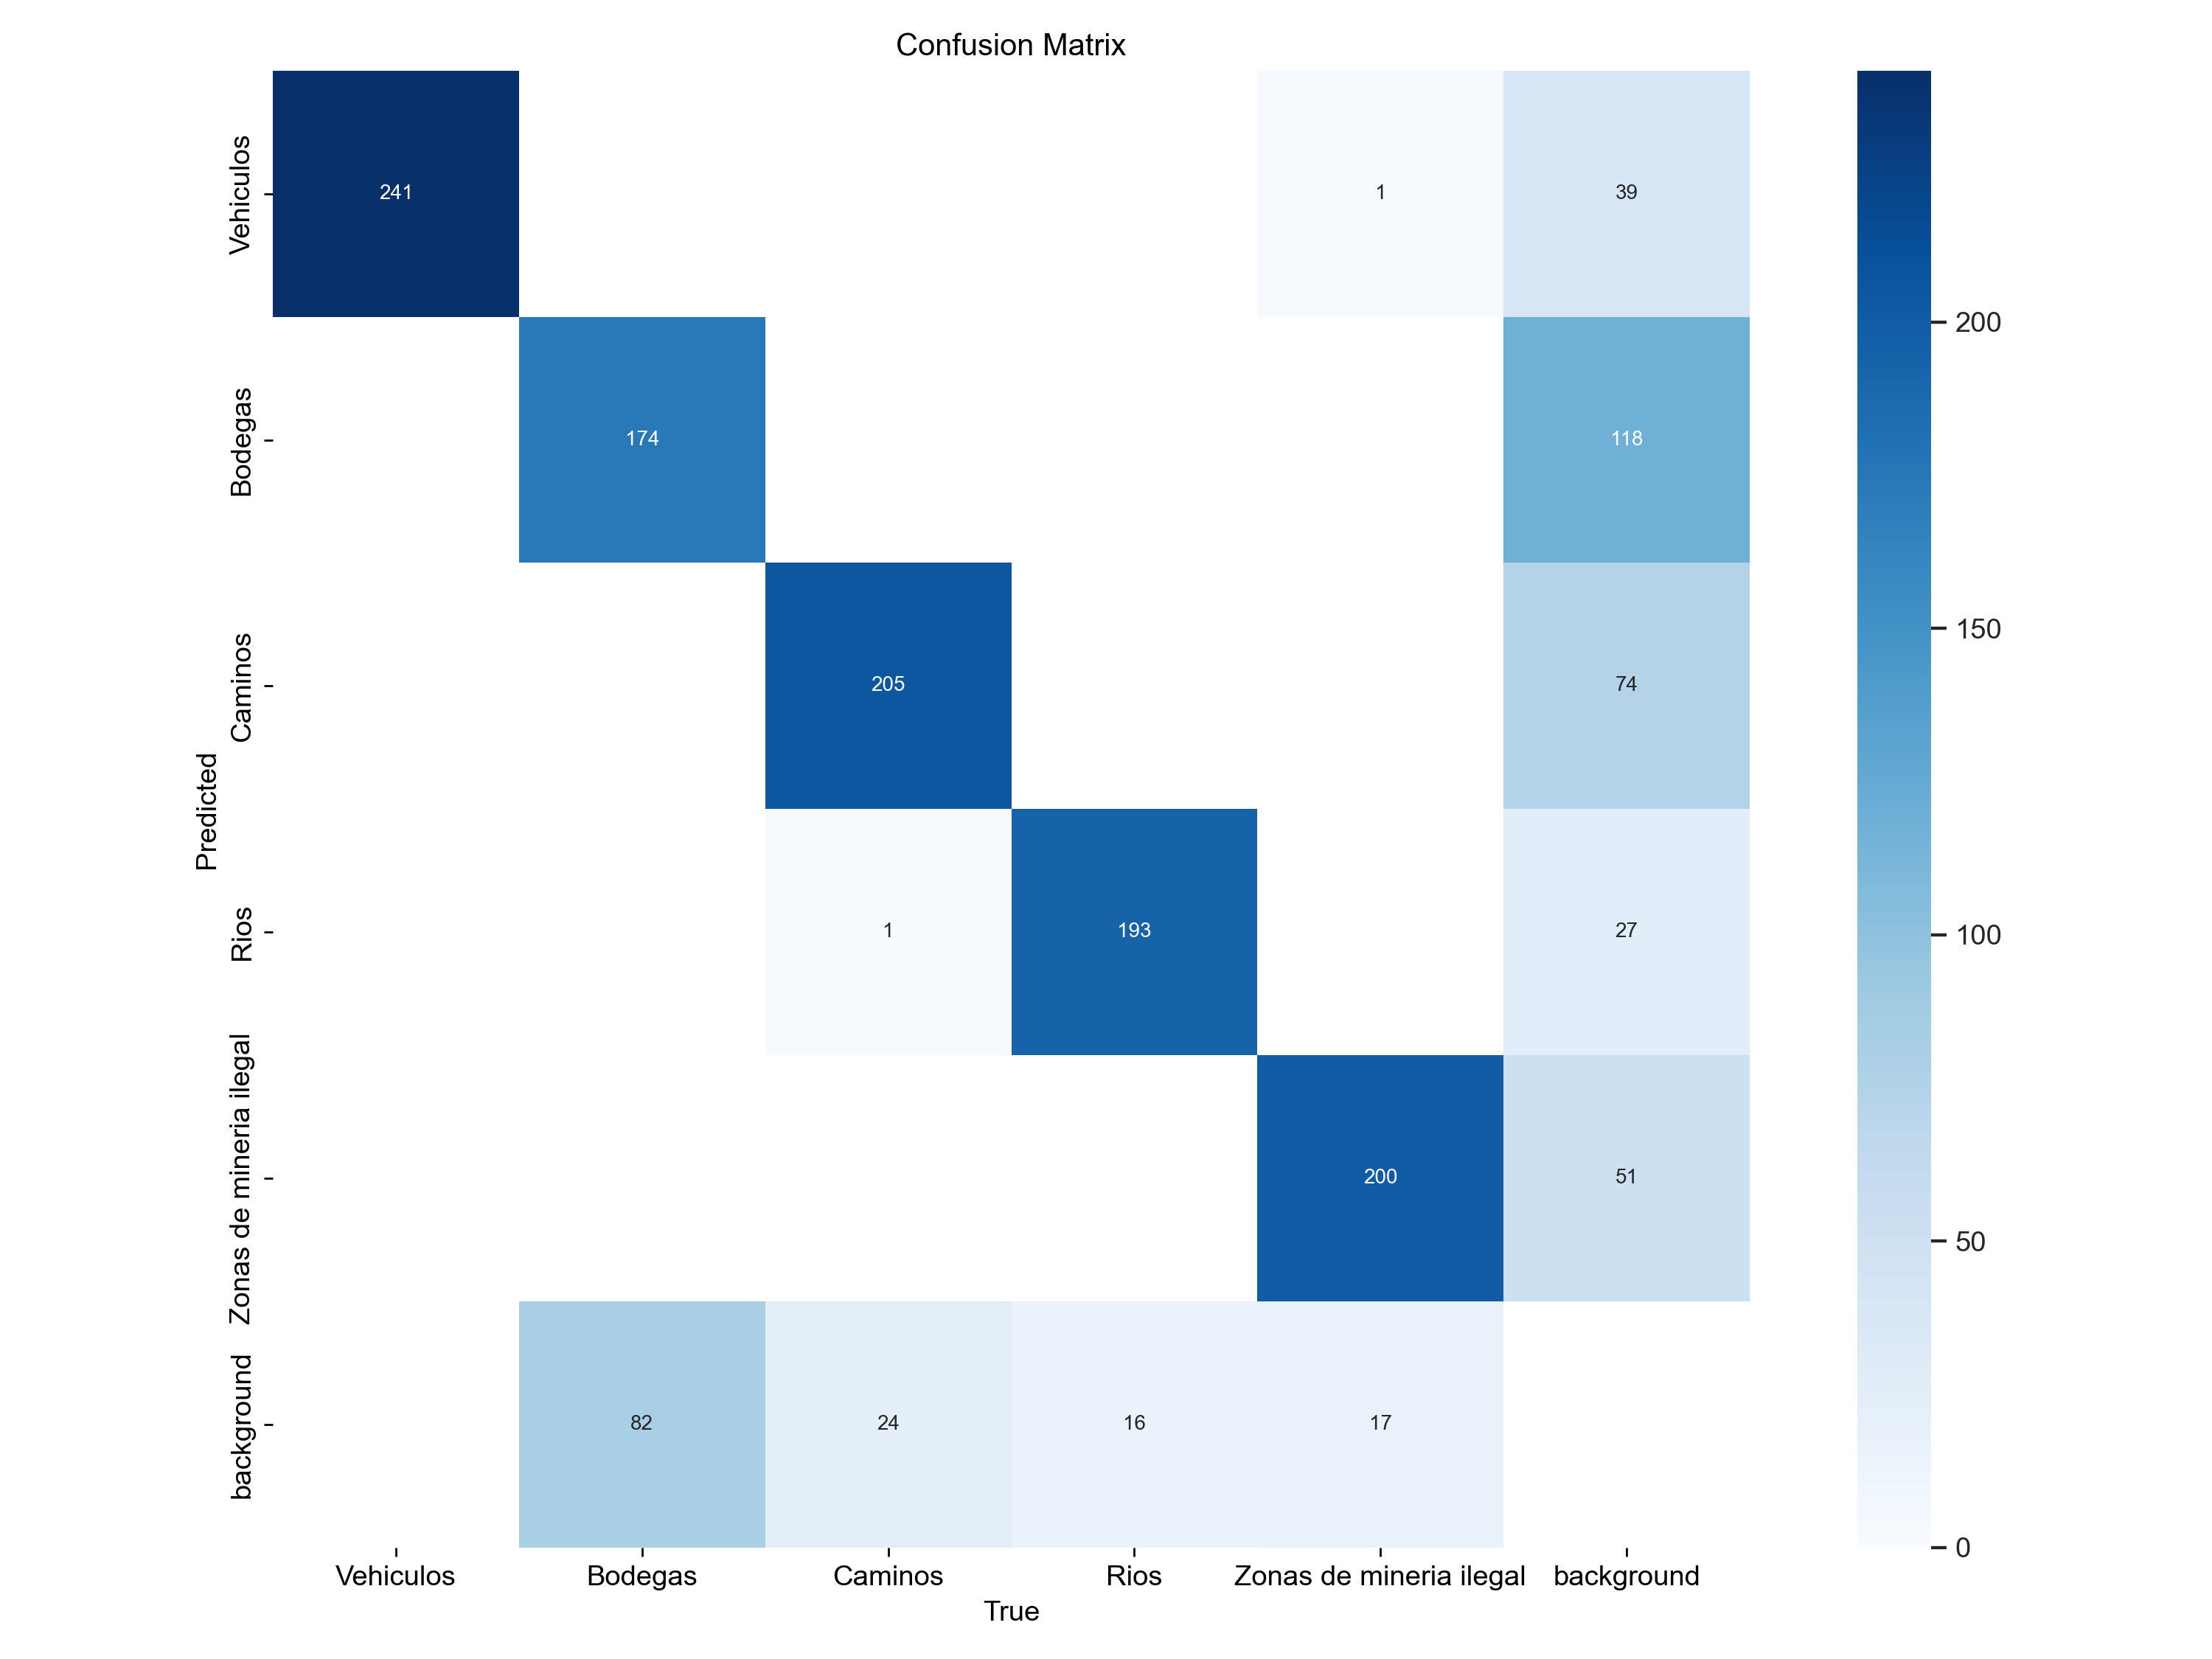

In [36]:
from PIL import Image as PImage
display(PImage.open('finetuning_resultados/finetuning_complete_preprocessed_dataset_v2/results.png'))

display(PImage.open('finetuning_resultados/finetuning_complete_preprocessed_dataset_v2/confusion_matrix.png'))

### Sin Preprocesamiento

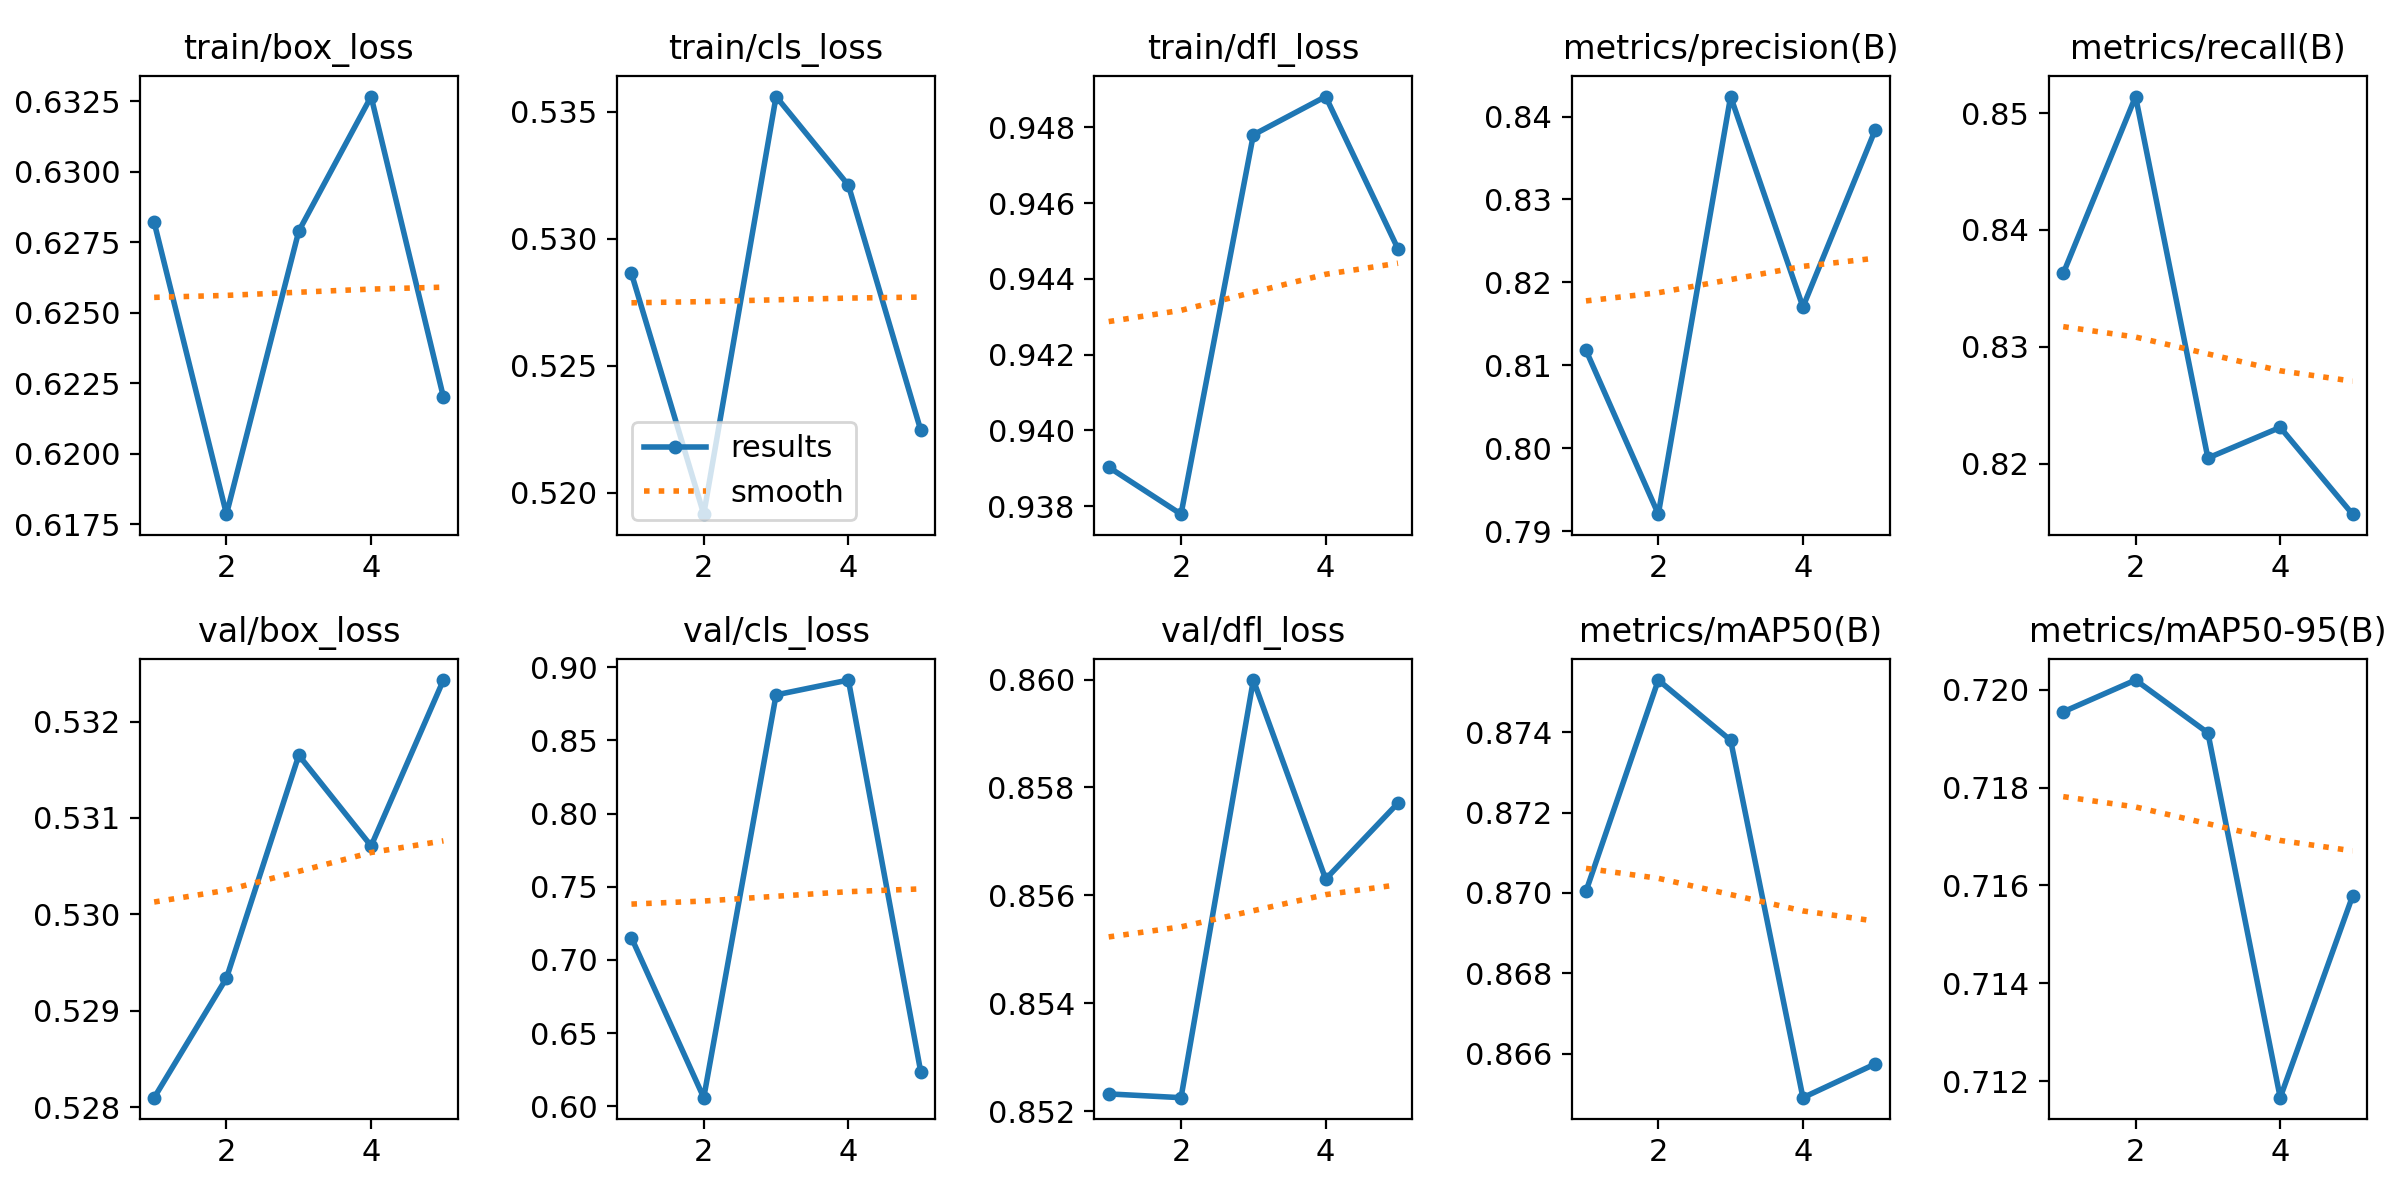

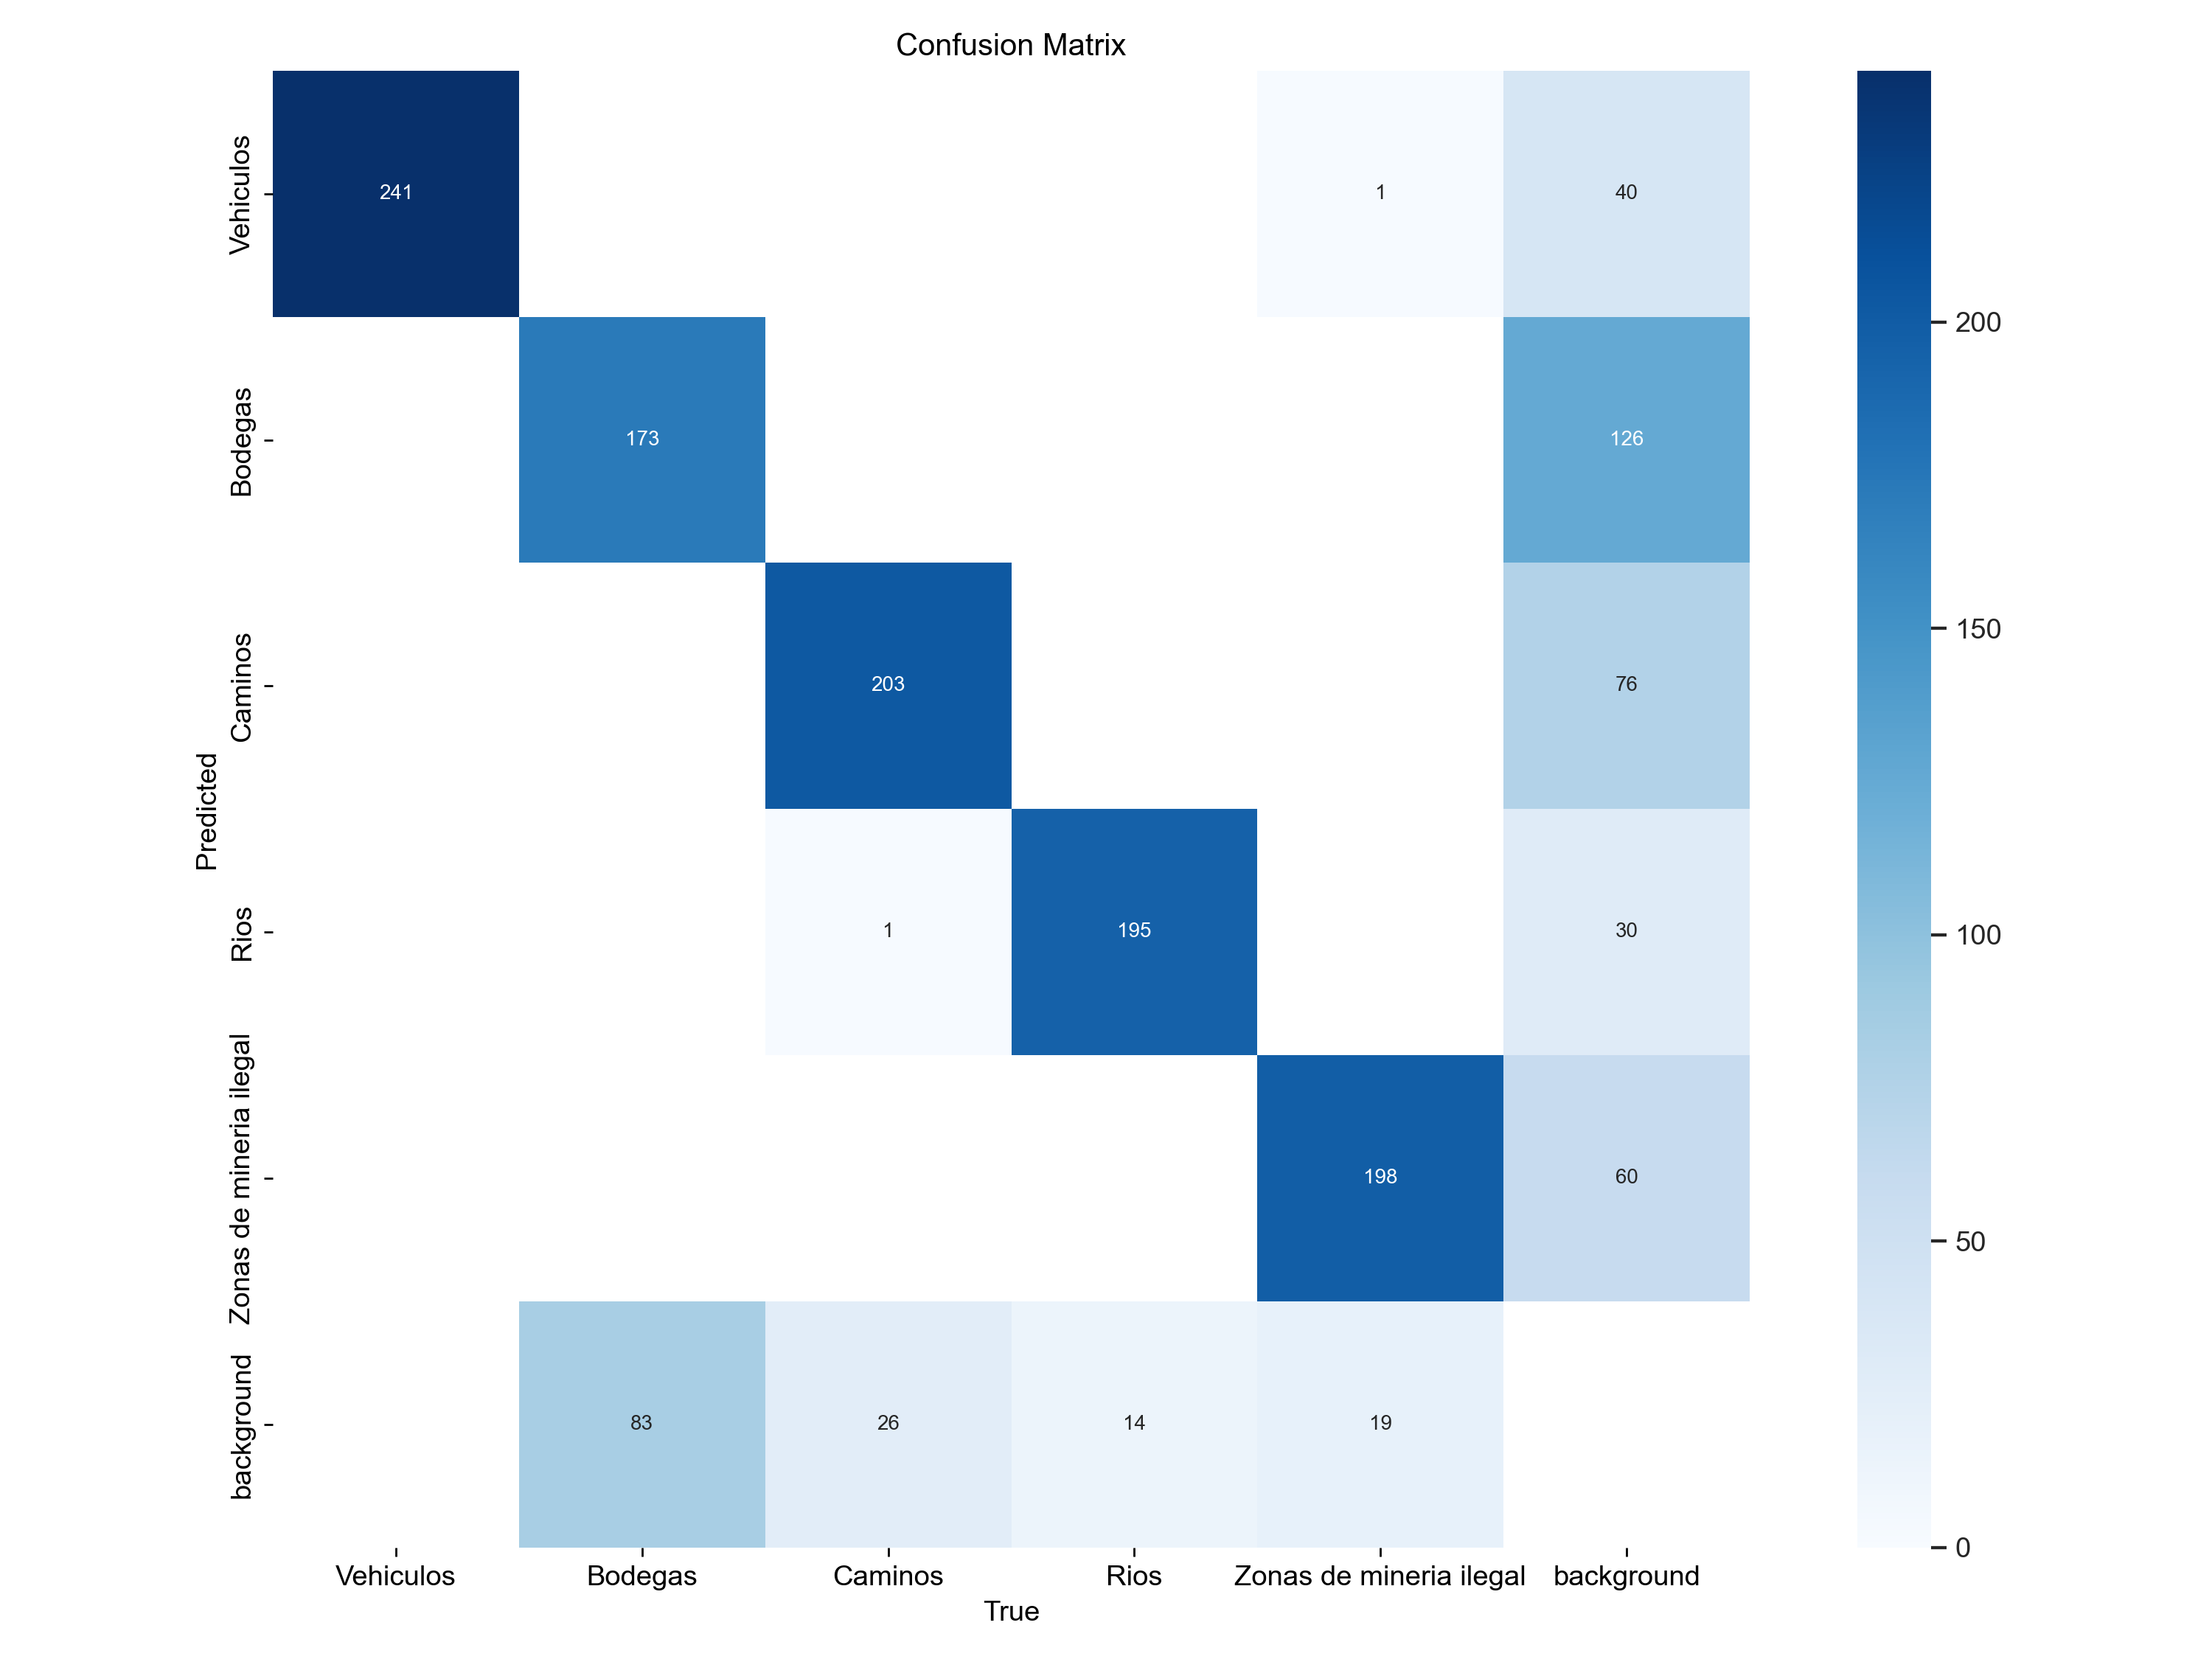

In [37]:
from PIL import Image as PImage
display(PImage.open('finetuning_resultados/finetuning_complete_dataset_v2/results.png'))

display(PImage.open('finetuning_resultados/finetuning_complete_dataset_v2/confusion_matrix.png'))

# Finetuning con freeze de 0 y 1

In [48]:
import os

def finetune_yolo_model(
    model_path,
    dataset_yaml_path,
    save_dir,
    run_name,
    lr=0.0005,
    epochs=15,
    imgsz=640,
    batch=16,
    freeze=0
):
    """
    Fine-tunes a YOLOv8 model with optional layer freezing.
    """
    assert os.path.exists(model_path), f"Modelo no encontrado: {model_path}"
    assert os.path.exists(dataset_yaml_path), f"YAML no encontrado: {dataset_yaml_path}"

    model = YOLO(model_path)

    model.train(
        data=dataset_yaml_path,
        epochs=epochs,
        patience=2,
        lr0=lr,
        imgsz=imgsz,
        batch=batch,
        project=save_dir,
        name=f"{run_name}_freeze{freeze}",
        optimizer="Adam",
        cos_lr=True,
        verbose=True,
        seed=42,
        deterministic=True,
        single_cls=False,
        rect=False,
        freeze=freeze
    )

# Modelos y datasets
configs = [
    (
        "final_model_modelo_yolov11_dataset_completo_final_v2/best_model_final.pt",
        "modelo_yolov11_dataset_completo/dataset.yaml",
        "finetuning_resultados",
        "finetuning_complete_dataset_v2"
    ),
    (
        "final_model_modelo_yolov11_dataset_filtrado_final_v2/best_model_final.pt",
        "modelo_yolov11_dataset_filtrado/dataset.yaml",
        "finetuning_resultados",
        "finetuning_filtered_dataset_v2"
    ),
    (
        "final_model_preprocesamiento_modelo_yolov11_dataset_completo_preprocesado_v2/best_model_final.pt",
        "preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/dataset.yaml",
        "finetuning_resultados",
        "finetuning_complete_preprocessed_dataset_v2"
    ),
    (
        "final_model_preprocesamiento_modelo_yolov11_dataset_filtrado_preprocesado_v2/best_model_final.pt",
        "preprocesamiento/modelo_yolov11_dataset_filtrado_preprocesado/dataset.yaml",
        "finetuning_resultados",
        "finetuning_filtered_preprocessed_dataset_v2"
    )
]

# Ejecutar fine-tuning con freeze=0 y freeze=1
for model_path, yaml_path, save_dir, run_name in configs:
    finetune_yolo_model(model_path, yaml_path, save_dir, run_name, freeze=0, lr=1e-4)
    finetune_yolo_model(model_path, yaml_path, save_dir, run_name, freeze=1, lr=5e-4)



New https://pypi.org/project/ultralytics/8.3.141 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=final_model_modelo_yolov11_dataset_completo_final_v2/best_model_final.pt, data=modelo_yolov11_dataset_completo/dataset.yaml, epochs=15, time=None, patience=2, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=finetuning_resultados, name=finetuning_complete_dataset_v2_freeze0, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=0, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, vi

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_completo\train\labels.cache... 8233 images, 2034 backgrounds, 0 corrupt: 100%|██████████| 8233/8233 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.0 ms, read: 18.313.7 MB/s, size: 284.4 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_completo\val\labels.cache... 984 images, 240 backgrounds, 0 corrupt: 100%|██████████| 984/984 [00:00<?, ?it/s]


Plotting labels to finetuning_resultados\finetuning_complete_dataset_v2_freeze0\labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/21 13:42:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(2a99e83e58d14689a513464a61442f9c) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to finetuning_resultados\finetuning_complete_dataset_v2_freeze0
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      3.51G     0.7439      0.606     0.9879         14        640: 100%|██████████| 515/515 [02:18<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.14it/s]

                   all        984       1154      0.839       0.81      0.862      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15       3.7G     0.6454     0.5203     0.9502         27        640: 100%|██████████| 515/515 [02:10<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.38it/s]

                   all        984       1154      0.816      0.838       0.88       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15       3.7G     0.6094     0.5027     0.9409         35        640: 100%|██████████| 515/515 [02:08<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.11it/s]

                   all        984       1154      0.825      0.837      0.871      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15       3.7G     0.5872     0.4845     0.9331         17        640: 100%|██████████| 515/515 [02:08<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.07it/s]

                   all        984       1154       0.82       0.83      0.863      0.722
EarlyStopping: Training stopped early as no improvement observed in last 2 epochs. Best results observed at epoch 2, best model saved as best.pt.
To update EarlyStopping(patience=2) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



4 epochs completed in 0.155 hours.
Optimizer stripped from finetuning_resultados\finetuning_complete_dataset_v2_freeze0\weights\last.pt, 22.5MB
Optimizer stripped from finetuning_resultados\finetuning_complete_dataset_v2_freeze0\weights\best.pt, 22.5MB

Validating finetuning_resultados\finetuning_complete_dataset_v2_freeze0\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.77it/s]


                   all        984       1154      0.816      0.838       0.88       0.73
             Vehiculos        234        241      0.857      0.997      0.938      0.928
               Bodegas         66        256      0.584      0.604      0.637      0.329
               Caminos        138        230      0.803      0.822        0.9      0.635
                  Rios        135        209       0.91      0.909      0.966      0.808
Zonas de mineria ilegal        206        218      0.926      0.858      0.959       0.95
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to finetuning_resultados\finetuning_complete_dataset_v2_freeze0
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'
New https://pypi.org/project/ultralytics/8.3.141 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_completo\train\labels.cache... 8233 images, 2034 backgrounds, 0 corrupt: 100%|██████████| 8233/8233 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 760.0314.1 MB/s, size: 284.4 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_completo\val\labels.cache... 984 images, 240 backgrounds, 0 corrupt: 100%|██████████| 984/984 [00:00<?, ?it/s]


Plotting labels to finetuning_resultados\finetuning_complete_dataset_v2_freeze1\labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/21 13:53:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(e98782158348417b8a89440c672471fc) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to finetuning_resultados\finetuning_complete_dataset_v2_freeze1
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      3.24G     0.7706     0.6326     0.9983         14        640: 100%|██████████| 515/515 [02:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.15it/s]

                   all        984       1154      0.816      0.802      0.853      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      3.44G     0.7513     0.6123     0.9947         27        640: 100%|██████████| 515/515 [01:59<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.50it/s]

                   all        984       1154      0.805      0.821      0.866      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      3.44G      0.777      0.641      1.012         35        640: 100%|██████████| 515/515 [01:59<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  3.99it/s]

                   all        984       1154      0.793      0.863      0.866      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      3.44G     0.7874     0.6426      1.017         17        640: 100%|██████████| 515/515 [02:05<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.00it/s]

                   all        984       1154      0.789      0.836      0.862       0.68
EarlyStopping: Training stopped early as no improvement observed in last 2 epochs. Best results observed at epoch 2, best model saved as best.pt.
To update EarlyStopping(patience=2) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



4 epochs completed in 0.147 hours.
Optimizer stripped from finetuning_resultados\finetuning_complete_dataset_v2_freeze1\weights\last.pt, 22.5MB
Optimizer stripped from finetuning_resultados\finetuning_complete_dataset_v2_freeze1\weights\best.pt, 22.5MB

Validating finetuning_resultados\finetuning_complete_dataset_v2_freeze1\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.75it/s]


                   all        984       1154        0.8      0.824      0.866      0.683
             Vehiculos        234        241      0.856          1      0.945      0.905
               Bodegas         66        256      0.638      0.504      0.613      0.302
               Caminos        138        230      0.764      0.839      0.859      0.559
                  Rios        135        209      0.883      0.914       0.96      0.742
Zonas de mineria ilegal        206        218      0.863      0.862      0.953      0.904
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to finetuning_resultados\finetuning_complete_dataset_v2_freeze1
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'
New https://pypi.org/project/ultralytics/8.3.141 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_filtrado\train\labels.cache... 8258 images, 2062 backgrounds, 0 corrupt: 100%|██████████| 8258/8258 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.30.1 ms, read: 20.87.3 MB/s, size: 327.3 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_filtrado\val\labels.cache... 984 images, 237 backgrounds, 0 corrupt: 100%|██████████| 984/984 [00:00<?, ?it/s]


Plotting labels to finetuning_resultados\finetuning_filtered_dataset_v2_freeze0\labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/21 14:03:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(54553cc7d5c549c69752278b3588a1aa) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to finetuning_resultados\finetuning_filtered_dataset_v2_freeze0
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      3.63G     0.7627     0.6169     0.9997          2        640: 100%|██████████| 517/517 [02:18<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.83it/s]

                   all        984       1103      0.834      0.827      0.868      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      3.81G     0.6742     0.5363     0.9642          6        640: 100%|██████████| 517/517 [02:09<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.20it/s]

                   all        984       1103      0.817      0.882      0.893      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      3.81G     0.6255     0.5094     0.9494          2        640: 100%|██████████| 517/517 [02:06<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.21it/s]

                   all        984       1103      0.819      0.876      0.885      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      3.81G     0.5958     0.4926     0.9392          3        640: 100%|██████████| 517/517 [02:06<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.16it/s]

                   all        984       1103      0.838      0.868      0.889      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      3.81G     0.5903     0.4898     0.9326          7        640: 100%|██████████| 517/517 [01:59<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.55it/s]

                   all        984       1103      0.836      0.872      0.896       0.75


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      3.81G     0.5094      0.413     0.8874          1        640: 100%|██████████| 517/517 [01:58<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.59it/s]

                   all        984       1103      0.834      0.862      0.891      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      3.81G     0.4791     0.3959     0.8768          1        640: 100%|██████████| 517/517 [01:57<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.45it/s]

                   all        984       1103      0.836      0.863      0.885      0.738
EarlyStopping: Training stopped early as no improvement observed in last 2 epochs. Best results observed at epoch 5, best model saved as best.pt.
To update EarlyStopping(patience=2) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



7 epochs completed in 0.270 hours.
Optimizer stripped from finetuning_resultados\finetuning_filtered_dataset_v2_freeze0\weights\last.pt, 22.5MB
Optimizer stripped from finetuning_resultados\finetuning_filtered_dataset_v2_freeze0\weights\best.pt, 22.5MB

Validating finetuning_resultados\finetuning_filtered_dataset_v2_freeze0\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.24it/s]


                   all        984       1103      0.837      0.875      0.896       0.75
             Vehiculos        233        238      0.864          1       0.95      0.938
               Bodegas         65        218      0.625      0.704      0.693      0.363
               Caminos        134        222      0.829      0.849      0.905      0.667
                  Rios        137        205      0.916      0.951      0.976      0.834
Zonas de mineria ilegal        207        220       0.95      0.868      0.956      0.948
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to finetuning_resultados\finetuning_filtered_dataset_v2_freeze0
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'
New https://pypi.org/project/ultralytics/8.3.141 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_filtrado\train\labels.cache... 8258 images, 2062 backgrounds, 0 corrupt: 100%|██████████| 8258/8258 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 1074.0246.4 MB/s, size: 327.3 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_filtrado\val\labels.cache... 984 images, 237 backgrounds, 0 corrupt: 100%|██████████| 984/984 [00:00<?, ?it/s]


Plotting labels to finetuning_resultados\finetuning_filtered_dataset_v2_freeze1\labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/21 14:21:26 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(8e4b6f4f2e2b42ad90c1aa01650607af) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to finetuning_resultados\finetuning_filtered_dataset_v2_freeze1
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      3.39G     0.7901     0.6461      1.011          2        640: 100%|██████████| 517/517 [02:02<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.38it/s]

                   all        984       1103      0.815      0.853      0.866      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      3.58G     0.7776     0.6271       1.01          6        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.53it/s]

                   all        984       1103      0.821      0.869      0.887       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      3.58G     0.7888     0.6448      1.021          2        640: 100%|██████████| 517/517 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.46it/s]

                   all        984       1103      0.814      0.866      0.876      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      3.58G     0.7904       0.65      1.024          3        640: 100%|██████████| 517/517 [01:53<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.55it/s]

                   all        984       1103      0.824       0.85      0.885      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      3.58G     0.7867     0.6435      1.021          7        640: 100%|██████████| 517/517 [01:57<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.46it/s]

                   all        984       1103       0.84       0.84      0.879      0.685


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      3.58G     0.7264     0.5723     0.9876          1        640: 100%|██████████| 517/517 [01:52<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.40it/s]

                   all        984       1103      0.832      0.851      0.877      0.679
EarlyStopping: Training stopped early as no improvement observed in last 2 epochs. Best results observed at epoch 4, best model saved as best.pt.
To update EarlyStopping(patience=2) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



6 epochs completed in 0.215 hours.
Optimizer stripped from finetuning_resultados\finetuning_filtered_dataset_v2_freeze1\weights\last.pt, 22.5MB
Optimizer stripped from finetuning_resultados\finetuning_filtered_dataset_v2_freeze1\weights\best.pt, 22.5MB

Validating finetuning_resultados\finetuning_filtered_dataset_v2_freeze1\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.11it/s]


                   all        984       1103      0.824       0.85      0.885      0.693
             Vehiculos        233        238      0.868          1      0.945      0.886
               Bodegas         65        218      0.658      0.644      0.706      0.346
               Caminos        134        222      0.779      0.806      0.855       0.58
                  Rios        137        205      0.902      0.932      0.963      0.736
Zonas de mineria ilegal        207        220      0.913      0.868      0.959      0.915
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to finetuning_resultados\finetuning_filtered_dataset_v2_freeze1
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'
New https://pypi.org/project/ultralytics/8.3.141 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_completo_preprocesado\train\labels.cache... 8233 images, 2034 backgrounds, 0 corrupt: 100%|██████████| 8233/8233 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.30.1 ms, read: 30.39.6 MB/s, size: 424.0 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_completo_preprocesado\val\labels.cache... 984 images, 240 backgrounds, 0 corrupt: 100%|██████████| 984/984 [00:00<?, ?it/s]


Plotting labels to finetuning_resultados\finetuning_complete_preprocessed_dataset_v2_freeze0\labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/21 14:35:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(5227761772f14d65bd74e429efdbd477) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to finetuning_resultados\finetuning_complete_preprocessed_dataset_v2_freeze0
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      3.48G     0.7283     0.5958     0.9807         14        640: 100%|██████████| 515/515 [02:08<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.55it/s]

                   all        984       1154      0.806      0.828      0.868        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      3.68G      0.636     0.5201     0.9467         27        640: 100%|██████████| 515/515 [02:00<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.47it/s]

                   all        984       1154       0.81      0.845      0.874      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      3.68G     0.5919     0.4901     0.9343         35        640: 100%|██████████| 515/515 [01:58<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.68it/s]

                   all        984       1154      0.808      0.861      0.874      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      3.68G     0.5713     0.4764      0.926         17        640: 100%|██████████| 515/515 [01:57<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.56it/s]


                   all        984       1154      0.824       0.84      0.875      0.736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      3.68G     0.5617     0.4695     0.9216         34        640: 100%|██████████| 515/515 [01:57<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.55it/s]


                   all        984       1154      0.818      0.826      0.869      0.731
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      3.68G     0.4874     0.4082     0.8768          5        640: 100%|██████████| 515/515 [01:57<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.48it/s]

                   all        984       1154      0.817      0.836      0.875      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      3.68G     0.4619     0.3906     0.8658          4        640: 100%|██████████| 515/515 [01:57<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.58it/s]

                   all        984       1154      0.822      0.827      0.874      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      3.68G     0.4445     0.3797       0.86         10        640: 100%|██████████| 515/515 [01:57<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.52it/s]

                   all        984       1154      0.802      0.845      0.869      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      3.68G     0.4364      0.377     0.8572         10        640: 100%|██████████| 515/515 [01:57<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.66it/s]


                   all        984       1154      0.802      0.849       0.87      0.733
EarlyStopping: Training stopped early as no improvement observed in last 2 epochs. Best results observed at epoch 7, best model saved as best.pt.
To update EarlyStopping(patience=2) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

9 epochs completed in 0.327 hours.
Optimizer stripped from finetuning_resultados\finetuning_complete_preprocessed_dataset_v2_freeze0\weights\last.pt, 22.5MB
Optimizer stripped from finetuning_resultados\finetuning_complete_preprocessed_dataset_v2_freeze0\weights\best.pt, 22.5MB

Validating finetuning_resultados\finetuning_complete_preprocessed_dataset_v2_freeze0\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.04it/s]


                   all        984       1154      0.821      0.827      0.874      0.739
             Vehiculos        234        241      0.858      0.996      0.943      0.933
               Bodegas         66        256      0.628      0.586       0.64       0.35
               Caminos        138        230      0.793      0.791      0.875      0.651
                  Rios        135        209        0.9      0.904      0.954       0.81
Zonas de mineria ilegal        206        218      0.926      0.858      0.957       0.95
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to finetuning_resultados\finetuning_complete_preprocessed_dataset_v2_freeze0
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'
New https://pypi.org/project/ultralytics/8.3.141 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_completo_preprocesado\train\labels.cache... 8233 images, 2034 backgrounds, 0 corrupt: 100%|██████████| 8233/8233 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 1181.8371.7 MB/s, size: 424.0 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_completo_preprocesado\val\labels.cache... 984 images, 240 backgrounds, 0 corrupt: 100%|██████████| 984/984 [00:00<?, ?it/s]


Plotting labels to finetuning_resultados\finetuning_complete_preprocessed_dataset_v2_freeze1\labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/21 14:57:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(e1b34f6f403a4367971b20d9cd869663) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to finetuning_resultados\finetuning_complete_preprocessed_dataset_v2_freeze1
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      3.24G     0.7578     0.6222     0.9947         14        640: 100%|██████████| 515/515 [02:01<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.36it/s]

                   all        984       1154      0.814      0.805      0.854      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      3.45G     0.7361     0.6058     0.9913         27        640: 100%|██████████| 515/515 [02:00<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.46it/s]


                   all        984       1154      0.778       0.85       0.87      0.685

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      3.45G     0.7566     0.6309      1.009         35        640: 100%|██████████| 515/515 [01:56<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.49it/s]


                   all        984       1154      0.806      0.827      0.862      0.684

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      3.45G     0.7715      0.635      1.015         17        640: 100%|██████████| 515/515 [01:53<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.44it/s]

                   all        984       1154      0.795      0.842      0.855      0.671
EarlyStopping: Training stopped early as no improvement observed in last 2 epochs. Best results observed at epoch 2, best model saved as best.pt.
To update EarlyStopping(patience=2) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



4 epochs completed in 0.140 hours.
Optimizer stripped from finetuning_resultados\finetuning_complete_preprocessed_dataset_v2_freeze1\weights\last.pt, 22.5MB
Optimizer stripped from finetuning_resultados\finetuning_complete_preprocessed_dataset_v2_freeze1\weights\best.pt, 22.5MB

Validating finetuning_resultados\finetuning_complete_preprocessed_dataset_v2_freeze1\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.05it/s]


                   all        984       1154      0.779       0.85       0.87      0.685
             Vehiculos        234        241      0.857          1      0.948      0.899
               Bodegas         66        256      0.623       0.59      0.658      0.336
               Caminos        138        230      0.669      0.861      0.834      0.542
                  Rios        135        209       0.87      0.928      0.956      0.723
Zonas de mineria ilegal        206        218      0.878      0.872      0.956      0.927
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to finetuning_resultados\finetuning_complete_preprocessed_dataset_v2_freeze1
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'
New https://pypi.org/project/ultralytics/8.3.141 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado\train\labels.cache... 8258 images, 2062 backgrounds, 0 corrupt: 100%|██████████| 8258/8258 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.60.1 ms, read: 29.43.5 MB/s, size: 452.5 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado\val\labels.cache... 984 images, 237 backgrounds, 0 corrupt: 100%|██████████| 984/984 [00:00<?, ?it/s]


Plotting labels to finetuning_resultados\finetuning_filtered_preprocessed_dataset_v2_freeze0\labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/21 15:07:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(aaa6e82d463547ff91e655316f325ac5) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to finetuning_resultados\finetuning_filtered_preprocessed_dataset_v2_freeze0
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      3.48G     0.7442     0.6096     0.9918          2        640: 100%|██████████| 517/517 [02:08<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.63it/s]

                   all        984       1103      0.834      0.863      0.888      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      3.67G     0.6444     0.5223     0.9525          6        640: 100%|██████████| 517/517 [02:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.54it/s]

                   all        984       1103      0.838       0.87      0.891      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      3.67G     0.6053     0.4969     0.9395          2        640: 100%|██████████| 517/517 [01:59<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.59it/s]

                   all        984       1103      0.817      0.879      0.888       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      3.67G     0.5799     0.4799      0.932          3        640: 100%|██████████| 517/517 [01:58<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.52it/s]

                   all        984       1103      0.837      0.848      0.885      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      3.67G     0.5707     0.4772     0.9253          7        640: 100%|██████████| 517/517 [01:58<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.50it/s]

                   all        984       1103      0.844      0.865      0.886      0.743


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      3.67G     0.4903     0.4039     0.8791          1        640: 100%|██████████| 517/517 [01:58<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.63it/s]

                   all        984       1103       0.84      0.859      0.884      0.739
EarlyStopping: Training stopped early as no improvement observed in last 2 epochs. Best results observed at epoch 4, best model saved as best.pt.
To update EarlyStopping(patience=2) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



6 epochs completed in 0.224 hours.
Optimizer stripped from finetuning_resultados\finetuning_filtered_preprocessed_dataset_v2_freeze0\weights\last.pt, 22.5MB
Optimizer stripped from finetuning_resultados\finetuning_filtered_preprocessed_dataset_v2_freeze0\weights\best.pt, 22.5MB

Validating finetuning_resultados\finetuning_filtered_preprocessed_dataset_v2_freeze0\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.09it/s]


                   all        984       1103      0.837      0.848      0.885      0.746
             Vehiculos        233        238      0.865          1      0.945      0.932
               Bodegas         65        218      0.643      0.642      0.669      0.362
               Caminos        134        222      0.841      0.806      0.884      0.665
                  Rios        137        205      0.913      0.937      0.971      0.827
Zonas de mineria ilegal        207        220      0.923      0.855      0.955      0.946
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to finetuning_resultados\finetuning_filtered_preprocessed_dataset_v2_freeze0
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'
New https://pypi.org/project/ultralytics/8.3.141 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado\train\labels.cache... 8258 images, 2062 backgrounds, 0 corrupt: 100%|██████████| 8258/8258 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 1074.6488.9 MB/s, size: 452.5 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado\val\labels.cache... 984 images, 237 backgrounds, 0 corrupt: 100%|██████████| 984/984 [00:00<?, ?it/s]


Plotting labels to finetuning_resultados\finetuning_filtered_preprocessed_dataset_v2_freeze1\labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/21 15:22:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(b47b49efd2934886bd78f4a9347a5961) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to finetuning_resultados\finetuning_filtered_preprocessed_dataset_v2_freeze1
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      3.25G     0.7758      0.633      1.005          2        640: 100%|██████████| 517/517 [02:02<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.55it/s]

                   all        984       1103      0.828      0.839      0.868      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      3.44G     0.7549     0.6132      1.004          6        640: 100%|██████████| 517/517 [01:56<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.69it/s]

                   all        984       1103      0.834      0.833      0.879      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      3.44G     0.7756     0.6337      1.015          2        640: 100%|██████████| 517/517 [01:54<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.48it/s]

                   all        984       1103      0.812      0.854      0.869      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      3.44G     0.7804     0.6419      1.019          3        640: 100%|██████████| 517/517 [01:54<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.85it/s]

                   all        984       1103      0.822      0.842      0.882      0.689
EarlyStopping: Training stopped early as no improvement observed in last 2 epochs. Best results observed at epoch 2, best model saved as best.pt.
To update EarlyStopping(patience=2) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



4 epochs completed in 0.139 hours.
Optimizer stripped from finetuning_resultados\finetuning_filtered_preprocessed_dataset_v2_freeze1\weights\last.pt, 22.5MB
Optimizer stripped from finetuning_resultados\finetuning_filtered_preprocessed_dataset_v2_freeze1\weights\best.pt, 22.5MB

Validating finetuning_resultados\finetuning_filtered_preprocessed_dataset_v2_freeze1\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.33it/s]


                   all        984       1103      0.835      0.833      0.878      0.693
             Vehiculos        233        238      0.851      0.983      0.945      0.899
               Bodegas         65        218      0.688      0.586      0.665      0.321
               Caminos        134        222      0.804      0.802       0.86      0.571
                  Rios        137        205      0.877      0.937      0.966      0.753
Zonas de mineria ilegal        207        220      0.955      0.858      0.956       0.92
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to finetuning_resultados\finetuning_filtered_preprocessed_dataset_v2_freeze1
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'


# Metricas

In [51]:
def evaluate_yolo_model_by_class(model_path, dataset_yaml_path, class_idx=4, class_name=None, split='test', imgsz=640, device=0):
    from ultralytics import YOLO
    import os
    import torch

    assert os.path.exists(model_path), f"Modelo no encontrado: {model_path}"
    assert os.path.exists(dataset_yaml_path), f"YAML no encontrado: {dataset_yaml_path}"

    model = YOLO(model_path)

    metrics = model.val(
        data=dataset_yaml_path,
        split=split,
        imgsz=imgsz,
        device=device,
        iou=0.5,
        verbose=True
    )

    # Métricas generales
    overall_metrics = {
        'precision_all': metrics.box.p.mean().item(),
        'recall_all': metrics.box.r.mean().item(),
        'mAP50_all': metrics.box.map50.mean().item(),
        'mAP50-95_all': metrics.box.map.mean().item()
    }

    # Verifica si las métricas son por clase (tensores) o escalares
    try:
        p_cls = metrics.box.p[class_idx].item()
        r_cls = metrics.box.r[class_idx].item()
        map50_cls = metrics.box.map50[class_idx].item()
        map_cls = metrics.box.map[class_idx].item()

        class_metrics = {
            'precision': p_cls,
            'recall': r_cls,
            'mAP50': map50_cls,
            'mAP50-95': map_cls
        }

        print(f"\n🔎 Métricas para la clase '{class_name or class_idx}' en modelo '{os.path.basename(model_path)}':")
        for k, v in class_metrics.items():
            print(f"{k}: {v:.4f}")

    except (IndexError, TypeError):
        print(f"\n⚠️  El modelo '{os.path.basename(model_path)}' no tiene métricas por clase (posiblemente fue entrenado con `single_cls=True`)")
        class_metrics = {
            'precision': None,
            'recall': None,
            'mAP50': None,
            'mAP50-95': None
        }

    return overall_metrics, class_metrics


In [52]:
# Lista de modelos (ruta, yaml, nombre)
models_info = [
    # Originales
    ("finetuning_resultados/finetuning_complete_dataset_v2/weights/best.pt", "modelo_yolov11_dataset_completo/dataset.yaml", "completo"),
    ("finetuning_resultados/finetuning_complete_preprocessed_dataset_v2/weights/best.pt", "preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/dataset.yaml", "completo_preprocesado"),
    ("finetuning_resultados/finetuning_filtered_dataset_v2/weights/best.pt", "modelo_yolov11_dataset_filtrado/dataset.yaml", "filtrado"),
    ("finetuning_resultados/finetuning_filtered_preprocessed_dataset_v2/weights/best.pt", "preprocesamiento/modelo_yolov11_dataset_filtrado_preprocesado/dataset.yaml", "filtrado_preprocesado"),

    # Nuevos con freeze=0
    ("finetuning_resultados/finetuning_complete_dataset_v2_freeze0/weights/best.pt", "modelo_yolov11_dataset_completo/dataset.yaml", "completo_freeze0"),
    ("finetuning_resultados/finetuning_complete_preprocessed_dataset_v2_freeze0/weights/best.pt", "preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/dataset.yaml", "completo_preprocesado_freeze0"),
    ("finetuning_resultados/finetuning_filtered_dataset_v2_freeze0/weights/best.pt", "modelo_yolov11_dataset_filtrado/dataset.yaml", "filtrado_freeze0"),
    ("finetuning_resultados/finetuning_filtered_preprocessed_dataset_v2_freeze0/weights/best.pt", "preprocesamiento/modelo_yolov11_dataset_filtrado_preprocesado/dataset.yaml", "filtrado_preprocesado_freeze0"),

    # Nuevos con freeze=1
    ("finetuning_resultados/finetuning_complete_dataset_v2_freeze1/weights/best.pt", "modelo_yolov11_dataset_completo/dataset.yaml", "completo_freeze1"),
    ("finetuning_resultados/finetuning_complete_preprocessed_dataset_v2_freeze1/weights/best.pt", "preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/dataset.yaml", "completo_preprocesado_freeze1"),
    ("finetuning_resultados/finetuning_filtered_dataset_v2_freeze1/weights/best.pt", "modelo_yolov11_dataset_filtrado/dataset.yaml", "filtrado_freeze1"),
    ("finetuning_resultados/finetuning_filtered_preprocessed_dataset_v2_freeze1/weights/best.pt", "preprocesamiento/modelo_yolov11_dataset_filtrado_preprocesado/dataset.yaml", "filtrado_preprocesado_freeze1"),
]

# Ejecutar evaluación en todos
results_all = {}
for model_path, yaml_path, label in models_info:
    overall, class_metrics = evaluate_yolo_model_by_class(
        model_path=model_path,
        dataset_yaml_path=yaml_path,
        class_idx=4,
        class_name="Zonas de minería ilegal"
    )
    results_all[label] = {
        "overall": overall,
        "class_4": class_metrics
    }


Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.1 ms, read: 1059.7279.4 MB/s, size: 253.4 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_completo\test\labels.cache... 2424 images, 617 backgrounds, 0 corrupt: 100%|██████████| 2424/2424 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:21<00:00,  7.07it/s]


                   all       2424       2764      0.813      0.827      0.868      0.732
             Vehiculos        475        489       0.85          1      0.955      0.936
               Bodegas        164        561      0.591      0.501      0.584      0.326
               Caminos        346        572      0.801      0.864      0.884      0.648
                  Rios        358        578      0.892      0.901      0.957      0.803
Zonas de mineria ilegal        530        564      0.932       0.87      0.959      0.946
Speed: 0.2ms preprocess, 3.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\val7

⚠️  El modelo 'best.pt' no tiene métricas por clase (posiblemente fue entrenado con `single_cls=True`)
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.20.1 ms, read: 32.716.7 MB/s, size

val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_completo_preprocesado\test\labels.cache... 2424 images, 617 backgrounds, 0 corrupt: 100%|██████████| 2424/2424 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:23<00:00,  6.35it/s]


                   all       2424       2764      0.785      0.862      0.869      0.734
             Vehiculos        475        489       0.85          1      0.957       0.94
               Bodegas        164        561      0.547      0.578      0.576      0.327
               Caminos        346        572      0.784      0.902        0.9      0.669
                  Rios        358        578      0.902      0.905      0.954      0.793
Zonas de mineria ilegal        530        564      0.842      0.926      0.957      0.941
Speed: 0.1ms preprocess, 3.6ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\val8

⚠️  El modelo 'best.pt' no tiene métricas por clase (posiblemente fue entrenado con `single_cls=True`)
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.20.1 ms, read: 26.39.5 MB/s, size:

val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_filtrado\test\labels.cache... 2416 images, 615 backgrounds, 0 corrupt: 100%|██████████| 2416/2416 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 151/151 [00:22<00:00,  6.80it/s]


                   all       2416       2712      0.818      0.865      0.879      0.731
             Vehiculos        465        472       0.84          1      0.935       0.92
               Bodegas        157        515      0.631      0.668      0.682      0.367
               Caminos        353        591      0.802      0.853      0.876      0.648
                  Rios        348        561      0.892      0.931      0.946      0.782
Zonas de mineria ilegal        537        573      0.926      0.871      0.957      0.936
Speed: 0.1ms preprocess, 3.5ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs\detect\val9

⚠️  El modelo 'best.pt' no tiene métricas por clase (posiblemente fue entrenado con `single_cls=True`)
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.30.2 ms, read: 33.22.8 MB/s, size:

val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado\test\labels.cache... 2416 images, 615 backgrounds, 0 corrupt: 100%|██████████| 2416/2416 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 151/151 [00:21<00:00,  6.95it/s]


                   all       2416       2712      0.823      0.856      0.877      0.745
             Vehiculos        465        472      0.842          1      0.952       0.94
               Bodegas        157        515      0.626      0.656       0.67      0.373
               Caminos        353        591      0.789      0.836      0.859      0.658
                  Rios        348        561      0.901      0.924       0.95      0.814
Zonas de mineria ilegal        537        573      0.956      0.864      0.956      0.941
Speed: 0.2ms preprocess, 3.5ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs\detect\val10

⚠️  El modelo 'best.pt' no tiene métricas por clase (posiblemente fue entrenado con `single_cls=True`)
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.20.2 ms, read: 1007.5385.4 MB/s, 

val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_completo\test\labels.cache... 2424 images, 617 backgrounds, 0 corrupt: 100%|██████████| 2424/2424 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:21<00:00,  7.12it/s]


                   all       2424       2764      0.793      0.842      0.864      0.737
             Vehiculos        475        489      0.849      0.998      0.952      0.941
               Bodegas        164        561      0.526      0.554      0.571      0.323
               Caminos        346        572      0.769      0.865      0.883      0.664
                  Rios        358        578      0.898       0.91      0.952      0.805
Zonas de mineria ilegal        530        564      0.926      0.884      0.963      0.952
Speed: 0.1ms preprocess, 3.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\val11

⚠️  El modelo 'best.pt' no tiene métricas por clase (posiblemente fue entrenado con `single_cls=True`)
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1310.6150.2 MB/s, 

val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_completo_preprocesado\test\labels.cache... 2424 images, 617 backgrounds, 0 corrupt: 100%|██████████| 2424/2424 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:20<00:00,  7.24it/s]


                   all       2424       2764       0.82      0.822      0.868      0.741
             Vehiculos        475        489      0.851      0.996      0.952      0.944
               Bodegas        164        561      0.594      0.499      0.571      0.319
               Caminos        346        572      0.808      0.831      0.896      0.685
                  Rios        358        578      0.918      0.917      0.963      0.813
Zonas de mineria ilegal        530        564      0.927      0.869      0.956      0.946
Speed: 0.1ms preprocess, 3.5ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\val12

⚠️  El modelo 'best.pt' no tiene métricas por clase (posiblemente fue entrenado con `single_cls=True`)
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 816.1333.8 MB/s, s

val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_filtrado\test\labels.cache... 2416 images, 615 backgrounds, 0 corrupt: 100%|██████████| 2416/2416 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 151/151 [00:23<00:00,  6.38it/s]


                   all       2416       2712      0.826       0.86      0.888      0.756
             Vehiculos        465        472      0.841          1      0.952      0.943
               Bodegas        157        515      0.618      0.662      0.675      0.374
               Caminos        353        591      0.821       0.86      0.901       0.69
                  Rios        348        561      0.903      0.918      0.959      0.826
Zonas de mineria ilegal        537        573      0.948      0.862      0.955      0.947
Speed: 0.2ms preprocess, 3.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\val13

⚠️  El modelo 'best.pt' no tiene métricas por clase (posiblemente fue entrenado con `single_cls=True`)
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.1 ms, read: 1536.2546.7 MB/s, 

val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado\test\labels.cache... 2416 images, 615 backgrounds, 0 corrupt: 100%|██████████| 2416/2416 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 151/151 [00:21<00:00,  7.11it/s]


                   all       2416       2712      0.821      0.855      0.882      0.751
             Vehiculos        465        472      0.841          1      0.951      0.941
               Bodegas        157        515      0.613      0.646      0.659       0.36
               Caminos        353        591      0.816      0.834      0.885      0.681
                  Rios        348        561      0.905      0.918      0.955      0.823
Zonas de mineria ilegal        537        573       0.93      0.877      0.958      0.952
Speed: 0.1ms preprocess, 3.5ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\val14

⚠️  El modelo 'best.pt' no tiene métricas por clase (posiblemente fue entrenado con `single_cls=True`)
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1247.4242.1 MB/s, 

val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_completo\test\labels.cache... 2424 images, 617 backgrounds, 0 corrupt: 100%|██████████| 2424/2424 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:21<00:00,  6.95it/s]


                   all       2424       2764      0.778       0.85      0.854      0.688
             Vehiculos        475        489      0.845          1      0.953      0.913
               Bodegas        164        561      0.559      0.531      0.557      0.297
               Caminos        346        572      0.728      0.885      0.853       0.57
                  Rios        358        578      0.882       0.92      0.943      0.738
Zonas de mineria ilegal        530        564      0.878      0.913      0.963      0.923
Speed: 0.2ms preprocess, 3.5ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs\detect\val15

⚠️  El modelo 'best.pt' no tiene métricas por clase (posiblemente fue entrenado con `single_cls=True`)
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1600.9370.8 MB/s, 

val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_completo_preprocesado\test\labels.cache... 2424 images, 617 backgrounds, 0 corrupt: 100%|██████████| 2424/2424 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:27<00:00,  5.58it/s]


                   all       2424       2764      0.804      0.824      0.858      0.689
             Vehiculos        475        489      0.847          1      0.951      0.904
               Bodegas        164        561       0.59      0.485      0.575      0.308
               Caminos        346        572      0.747      0.871      0.861      0.579
                  Rios        358        578       0.91      0.893      0.945      0.728
Zonas de mineria ilegal        530        564      0.927      0.873      0.959      0.927
Speed: 0.2ms preprocess, 3.6ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs\detect\val16

⚠️  El modelo 'best.pt' no tiene métricas por clase (posiblemente fue entrenado con `single_cls=True`)
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.20.1 ms, read: 846.9434.7 MB/s, s

val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_filtrado\test\labels.cache... 2416 images, 615 backgrounds, 0 corrupt: 100%|██████████| 2416/2416 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 151/151 [00:22<00:00,  6.58it/s]


                   all       2416       2712      0.798      0.864       0.87      0.685
             Vehiculos        465        472       0.84          1      0.947      0.887
               Bodegas        157        515      0.611       0.65      0.651       0.33
               Caminos        353        591      0.751      0.868      0.864      0.585
                  Rios        348        561      0.864      0.915      0.934      0.714
Zonas de mineria ilegal        537        573      0.923      0.885      0.954       0.91
Speed: 0.2ms preprocess, 3.5ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\val17

⚠️  El modelo 'best.pt' no tiene métricas por clase (posiblemente fue entrenado con `single_cls=True`)
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.1 ms, read: 981.5433.3 MB/s, s

val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado\test\labels.cache... 2416 images, 615 backgrounds, 0 corrupt: 100%|██████████| 2416/2416 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 151/151 [00:21<00:00,  7.15it/s]


                   all       2416       2712      0.804      0.848       0.87      0.696
             Vehiculos        465        472      0.832      0.994      0.947      0.906
               Bodegas        157        515      0.609      0.633       0.65      0.333
               Caminos        353        591      0.754      0.827      0.858      0.589
                  Rios        348        561      0.873      0.923      0.941      0.732
Zonas de mineria ilegal        537        573       0.95       0.86      0.954      0.918
Speed: 0.2ms preprocess, 3.5ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\val18

⚠️  El modelo 'best.pt' no tiene métricas por clase (posiblemente fue entrenado con `single_cls=True`)


El mejor desempeño se obtuvo utilizando el dataset completo preprocesado para la clase de minería ilegal, evaluado principalmente con base en la métrica de recall. Esta elección se justifica porque, en este contexto, un falso negativo —es decir, que el modelo indique que no hay minería ilegal cuando en realidad sí la hay— representa un costo mucho mayor en términos de impacto ambiental, social y legal, que un falso positivo, donde el modelo señala minería ilegal en una zona que no la presenta. Por lo tanto, se prioriza maximizar el recall para reducir al mínimo la omisión de zonas ilegales reales, aunque eso implique un incremento moderado en falsos positivos.

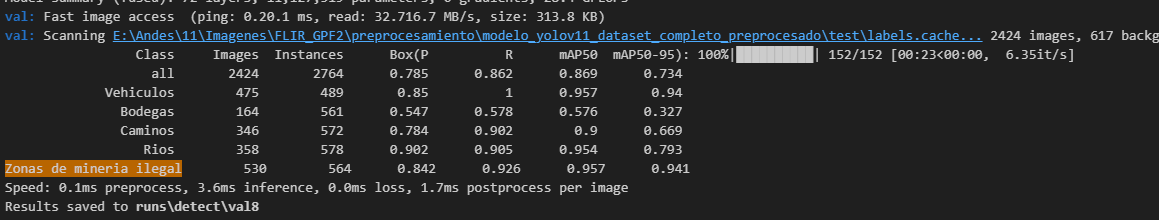

In [54]:
import os
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cv2

def show_predictions_minery_zone(model_path, dataset_path, class_index=4, count=25, imgsz=640, device=0):
    """
    Muestra un grid 5x5 con predicciones sobre imágenes que contienen la clase 'zonas de minería ilegal'.

    Args:
        model_path (str): Ruta al modelo YOLO entrenado (.pt).
        dataset_path (str): Ruta a la carpeta raíz del dataset (donde está /test/images y /test/labels).
        class_index (int): Índice de la clase "Zonas de minería ilegal".
        count (int): Número de imágenes a mostrar.
    """
    model = YOLO(model_path)

    labels_dir = os.path.join(dataset_path, 'test', 'labels')
    images_dir = os.path.join(dataset_path, 'test', 'images')

    matching_files = []
    for file in os.listdir(labels_dir):
        label_path = os.path.join(labels_dir, file)
        with open(label_path, 'r') as f:
            lines = f.readlines()
            if any(int(line.split()[0]) == class_index for line in lines):
                matching_files.append(file.replace('.txt', '.jpg'))

    selected_images = random.sample(matching_files, min(count, len(matching_files)))

    fig, axes = plt.subplots(5, 5, figsize=(18, 18))
    fig.suptitle("Predicciones sobre zonas de minería ilegal", fontsize=20)

    for ax, img_name in zip(axes.flat, selected_images):
        img_path = os.path.join(images_dir, img_name)
        results = model(img_path, imgsz=imgsz, device=device, verbose=False)
        pred_img = results[0].plot()

        # Convertir de BGR a RGB
        pred_img_rgb = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

        ax.imshow(pred_img_rgb)
        ax.set_title(img_name, fontsize=8)
        ax.axis("off")
        
    plt.tight_layout()
    plt.savefig("grid_25_mineria.png", dpi=300)
    plt.show()



In [55]:
show_predictions_minery_zone(
    model_path="finetuning_resultados/finetuning_complete_preprocessed_dataset_v2/weights/best.pt",
    dataset_path="preprocesamiento/modelo_yolov11_dataset_completo_preprocesado",
    class_index=4, 
    count=25,
    imgsz=640,
    device=0
)

<Figure size 1800x1800 with 25 Axes>